# Prepare data
TODOs (Dec 12)
1. Prepare parquets for COVID. Upload to Zenodo. (Parquets are ready.)
2. Check that the numbers match
   - ~~works tagged with COVID, COVID authors,~~
   - ~~outbreak science works and authors during the TW~~
   - ~~split of newcomers, bellwethers, experts~~
   - ~~split of works experience %~~
3. Prepare other parquets - LitCOVID, COVID + PH

Data Analysis
1.  ~~Re-write run method, making it a separate class, normalize the nomenclature~~
2.  Write monthly stats to CSVs,
3.  generate data pickles 

Data Viz
1. ~~Make Fig 1 using plotly. Reuse existing code.~~
2. Almost there, need yearly plots. panel (A)

In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.extend(['../', '../../'])

from utils import *

In [12]:
def get_monthly_stats(topic, topic_dfs_dict, topic_work_ids_tw=None,):
    """
    Get monthly stats for topics
    """
    key_concepts, expert_concepts, start_date_tw, \
    end_date_tw, start_date_ow, end_date_ow = get_topic_info(topic=topic)

    observation_window = pd.date_range(start_date_ow, end_date_ow, freq='M')
    training_window = pd.date_range(start_date_tw, end_date_tw, freq='M')
    print(f'Training window: {start_date_tw.to_period("D")} to {end_date_tw.to_period("D")}')
    print(f'Observation window: {start_date_ow.to_period("D")} to {end_date_ow.to_period("D")}')
    
    if len(topic_dfs_dict[topic]['TW']) != 3:
        works_tw, works_authors_tw, works_concepts_tw = filter_dataframes_timerange(works, works_authors, 
                                                                                    works_concepts, start_date_tw, end_date_tw)
    else:
        works_tw, works_authors_tw, works_concepts_tw = topic_dfs_dict[topic]['TW']['works'], topic_dfs_dict[topic]['TW']['works_authors'], topic_dfs_dict[topic]['TW']['works_concepts']
    
    if len(topic_dfs_dict[topic]['OW']) != 3:
        works_ow, works_authors_ow, works_concepts_ow = filter_dataframes_timerange(works, works_authors, 
                                                                                    works_concepts, start_date_ow, end_date_ow)
    else:
        works_ow, works_authors_ow, works_concepts_ow = topic_dfs_dict[topic]['OW']['works'], topic_dfs_dict[topic]['OW']['works_authors'], topic_dfs_dict[topic]['OW']['works_concepts']
        
    # initialize these sets at the start of the Observation Window. 
    existing_authors_tw = set(   # all authors active in the last 5 years
        works_authors_tw
        .author_id
    )

    expert_work_ids_tw = set(  # work ids of expert concepts in the TW
        works_concepts_tw
        .query('concept_id.isin(@expert_concepts)')
        .work_id
    )

    expert_author_ids_tw = set(         # wrote a paper on the expert concepts in the TW 
        works_authors_tw
        .query('work_id.isin(@expert_work_ids_tw)')
        .author_id
    )
    
    if topic_work_ids_tw is None:
        litcovid = False
        topic_work_ids_tw = set(   # work ids of papers on topic in TW
            works_concepts_tw
            .query('concept_id.isin(@key_concepts)')
            .work_id
        )
    else:
        litcovid = True
        print(f'Using {len(topic_work_ids_tw):,} supplied work ids for concept tags.')
                          
    existing_topic_authors = set(         # wrote a paper on the topic in the TW
        works_authors_tw
        .query('work_id.isin(@topic_work_ids_tw)')
        .author_id
    )
    
    print(f'Existing topic authors: {len(existing_topic_authors):,} at start of OW')
    topic_experts = existing_topic_authors | expert_author_ids_tw
    print(f'Topic experts: {len(topic_experts):,}')
    
    rows, topic_monthly_author_dfs = [], []
    shuffled_monthly_stats_dfs = []
    
    with tqdm(observation_window) as pbar:
        for i, month_end_date in enumerate(observation_window):
            month_start_date = month_end_date - pd.offsets.MonthBegin()
            assert month_start_date.day==1 and month_start_date.month==month_end_date.month
            pbar.set_description(f'{topic!r} {month_start_date.to_period("D")}')
            
            works_month, works_authors_month, works_concepts_month = filter_dataframes_timerange(works_ow, works_authors_ow, 
                                                                                                 works_concepts_ow, 
                                                                                                 month_start_date, month_end_date)

            all_authors_month = set(works_authors_month.author_id)  # set of all authors for that month

            if litcovid: # passed work ids from LitCOVID
                topic_work_ids_month = set(
                    works_month
                    .query('index.isin(@topic_work_ids_tw)')
                    .index
                )
            else:  
                topic_work_ids_month = set(     # set of works tagged with topic
                    works_concepts_month
                    .query('concept_id.isin(@key_concepts)')
                    .work_id
                )
                
            topic_works_authors_month = (    # works authorships for topic papers 
                works_authors_month
                .query('work_id.isin(@topic_work_ids_month)')
            )

            topic_authors_month = set(       # set of authors who wrote something tagged with topic
                topic_works_authors_month
                .author_id
            )
            
            # experts -> authors who wrote a paper in that month who are experts
            experts_month = topic_authors_month & topic_experts
            experts_first_month = experts_month - existing_topic_authors

            # newcomers -> new topic authors who were not active in the TW
            newcomers_month =  topic_authors_month - existing_authors_tw  # authors who wrote a topic paper, but no paper in TW
            newcomers_first_month = newcomers_month - existing_topic_authors  # newcomers appearing for the first time
            
            # bellwethers -> authors active in TW who did not write on topic or expert concepts
            bellwethers_month = (topic_authors_month & existing_authors_tw) - topic_experts
            bellwethers_first_month = bellwethers_month - existing_topic_authors  # first time bellwethers
            
            shared_authors = (newcomers_month & bellwethers_month) | (bellwethers_month & experts_month) | (experts_month & newcomers_month)
            assert len(shared_authors)==0, f'The sets share {len(shared_authors):,} authors'
            
            topic_repeat_authors_month = topic_authors_month & existing_topic_authors
                
            monthly_author_count = get_monthly_works_authors_stats(
                topic=topic, month_idx=i+1, date=month_end_date,
                topic_works_authors=topic_works_authors_month,
                topic_newcomers_month=newcomers_month,
                topic_bellwethers_month=bellwethers_month,
                topic_experts_month=experts_month,
                topic_repeat_authors_month=topic_repeat_authors_month,
            )
            
            topic_monthly_author_dfs.append(monthly_author_count)

            rows.append(
                dict(
                    topic=topic, date=month_end_date.date(), month_idx=i+1, 
                    all_works=len(works_month), all_authors=len(all_authors_month),
                    topic_works=len(topic_work_ids_month), topic_authors=len(topic_authors_month),
                    topic_newcomers=len(newcomers_month), topic_newcomers_first=len(newcomers_first_month),
                    topic_bellwethers=len(bellwethers_month), topic_bellwethers_first=len(bellwethers_first_month),
                    topic_experts=len(experts_month), topic_experts_first=len(experts_first_month), 
                    topic_repeat_authors=len(topic_repeat_authors_month),
                    existing_topic_authors_overall=len(existing_topic_authors),
                )
            )
            existing_topic_authors.update(topic_authors_month)
            pbar.update(1)
            
    ## add phase info and exp class info
    aggregated_stats = combine_and_assign_author_classes(pd.DataFrame(rows))
    monthly_works_authors_stats = combine_and_assign_author_classes(topic_monthly_author_dfs)

    ## aggregated data
    existing_topic_authors = set(         # wrote a paper on the topic in the TW (gets overwritten inside the loop)
        works_authors_tw
        .query('work_id.isin(@topic_work_ids_tw)')
        .author_id
    )
    
    topic_work_ids_ow = set(   # work ids of papers on topic in OW
        works_concepts_ow
        [(works_concepts_ow.concept_id.isin(topic_ids))]
        .work_id
    )
    topic_author_ids_ow = set(
        works_authors_ow
        [works_authors_ow.work_id.isin(topic_work_ids_ow)]
        .author_id
    )
    # topic_expert_authors = (expert_author_ids_tw | existing_topic_authors_tw) & topic_author_ids_ow
    topic_newcomer_authors = (topic_author_ids_ow - existing_authors_tw)
    topic_bellwether_authors = topic_author_ids_ow - topic_experts

    data = dict(
        topic=topic,
        experts=topic_experts,
        bellwethers=topic_bellwether_authors,
        newcomers=topic_newcomer_authors,
        work_ids_ow=topic_work_ids_ow,
        author_ids_ow=topic_author_ids_ow,
        ## extra
        work_ids_tw=topic_work_ids_tw,  # topic works in TW
        author_ids_tw=existing_topic_authors,
        expert_work_ids_tw=expert_work_ids_tw,  # ALL expert works in TW
        expert_author_ids_tw=expert_author_ids_tw,  # ALL expert authors in TW
    )
    
    return data, aggregated_stats, monthly_works_authors_stats


In [16]:
def generate_data(topic_dfs_dict, topic='COVID', topic_work_ids_ow=None, overwrite=False):
    """
    Run data 
    """
    csv_path = Path('./csvs/')
    author_types_path = csv_path / f'{topic}_author_types.csv'
    work_types_path = csv_path / f'{topic}_work_types.csv'
    pickle_path = Path(f'./pickles/{topic}.pkl')
    
    if not overwrite and all_paths_exist(author_types_path, work_types_path, pickle_path):
        author_types_df = pd.read_csv(author_types_path)
        work_types_df = pd.read_csv(work_types_path)
        agg_data = load_pickle(pickle_path)
        
    else:
        agg_data, agg_stats, monthly_works_authors_stats = get_monthly_stats(
            topic=topic, topic_dfs_dict=topic_dfs_dict
        )
        dump_pickle(agg_data, pickle_path)
    
        ## write to CSVs 
        author_types_df = (
            agg_stats
            .assign(
                experts_frac=lambda df_: df_.topic_experts.div(df_.topic_authors),
                bellwethers_frac=lambda df_: df_.topic_bellwethers.div(df_.topic_authors),
                newcomers_frac=lambda df_: df_.topic_newcomers.div(df_.topic_authors),
            )
        )
        display(author_types_df.head())
        author_types_df.to_csv(author_types_path, index=False)
        
        ## write to CSVs (work types)
        work_types_df = (
            pd.concat([
                monthly_works_authors_stats
                .groupby(['topic', 'date'], sort=False)
                .class_
                .value_counts(normalize=False)
                .rename('works_count')
                .to_frame(),
                monthly_works_authors_stats
                .groupby(['topic', 'date'], sort=False)
                .class_
                .value_counts(normalize=True)
                .rename('works_frac')
                .to_frame()], 
                axis=1
            )
            .reset_index()
        )
        display(work_types_df.head())
        
        work_types_df.to_csv(work_types_path, index=False)
    return agg_data, author_types_df, work_types_df

# Download data

In [5]:
%%bash
cd data
wget https://zenodo.org/api/records/10368779/files-archive

In [6]:
%%bash
cd data
unzip files-archive
unzip COVID.zip

Archive:  files-archive
 extracting: litcovid_work_ids.pkl.gz  
 extracting: COVID.zip               
 extracting: concepts.csv.gz         


In [5]:
# download data
parq_path = Path('./data/COVID')
assert (parq_path / 'works.parquet').exists()

In [6]:
## read the parquet
works = read_parquet(parq_path / 'works')
works_authors = read_parquet(parq_path / 'works_authors')
works_concepts = read_parquet(parq_path / 'works_concepts')


Reading 'works' from 'data/COVID/works.parquet' using engine='fastparquet'
Read 33,221,670 rows from 'works' in 9.10 sec.
Converting dtypes took 15.48 sec. Size before: 3.42GB, after: 3.32GB


doi          type publication_date  \
work_id                                                                      
4794            10.1007/978-3-319-10076-0_1  book-chapter       2015-04-01   
27109    10.1016/b978-0-12-397025-1.00296-7  book-chapter       2015-07-15   
32085               10.4324/9781315233307-6  book-chapter       2017-07-05   

         publication_year  num_authors  shuffled_date  publication_month  
work_id                                                                   
4794                 2015            9           True                  4  
27109                2015            2           True                  7  
32085                2017            4          False                  7


Reading 'works_authors' from 'data/COVID/works_authors.parquet' using engine='fastparquet'
Read 157,732,496 rows from 'works_authors' in 10.30 sec.
Converting dtypes took 0.95 sec. Size before: 4.99GB, after: 4.99GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01
632324               979452944  5083970693              2015       2015-10-01


Reading 'works_concepts' from 'data/COVID/works_concepts.parquet' using engine='fastparquet'
Read 288,800,828 rows from 'works_concepts' in 15.37 sec.
Converting dtypes took 2.69 sec. Size before: 8.07GB, after: 7.53GB


work_id  concept_id     score  publication_year
__null_dask_index__                                                   
463354               406922932   137620995  0.907227              2015
463355               406922932   161879069  0.680176              2015
463356               406922932    86554907  0.658203              2015

# start of computation

In [7]:
topic = 'COVID'
topic_ids, topic_ids_exp, start_date_tw, end_date_tw, start_date_ow, end_date_ow = get_topic_info(topic)

'COVID' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31


In [13]:
topic_dfs_dict = {}  # store the different tables

In [15]:
# dictionary to store the filtered topic dfs, 'TW', 'OW'
if topic not in topic_dfs_dict:
    topic_dfs_dict[topic] = {'TW': {}, 'OW': {}}

# generate filtered dfs, for TW
if len(topic_dfs_dict[topic]['TW']) != 3:
    dfs = filter_dataframes_timerange(
        works, works_authors, works_concepts, start_date_tw, end_date_tw
    )
    topic_dfs_dict[topic]['TW'] = {'works': dfs[0], 'works_authors': dfs[1], 'works_concepts': dfs[2]}

# for OW
if len(topic_dfs_dict[topic]['OW']) != 3:
    dfs = filter_dataframes_timerange(
        works, works_authors, works_concepts, start_date_ow, end_date_ow
    )
    topic_dfs_dict[topic]['OW'] = {'works': dfs[0], 'works_authors': dfs[1], 'works_concepts': dfs[2]}
del dfs

In [18]:
agg_data, author_types_df, work_types_df = generate_data(
    topic=topic, topic_dfs_dict=topic_dfs_dict, overwrite=True,
)

'COVID' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
Existing topic authors: 18,486 at start of OW
Topic experts: 341,335


  0%|          | 0/36 [00:00<?, ?it/s]

Pickle saved at 'pickles/COVID.pkl'


topic       date  month_idx  all_works  all_authors  topic_works  \
0  COVID 2020-01-31          1     240300       908929         1631   
1  COVID 2020-02-29          2     327456      1206925         2204   
2  COVID 2020-03-31          3     391183      1377583         4123   
3  COVID 2020-04-30          4     373790      1326454         8000   
4  COVID 2020-05-31          5     379011      1362998        10892   

   topic_authors  topic_newcomers  topic_newcomers_first  topic_bellwethers  \
0           8046             1959                   1959               4502   
1          11319             2289                   2247               6232   
2          20410             3948                   3791              11444   
3          37371             7018                   6622              22460   
4          53114            10360                   9384              32039   

   topic_bellwethers_first  topic_experts  topic_experts_first  \
0                     4502           1585                 1161   
1                     5944           2798                 1903   
2                    10307           5018                 3125   
3                    19589           7893                 4932   
4                    25750          10715                 6023   

   topic_repeat_authors  existing_topic_authors_overall  experts_frac  \
0                   424                           18486      0.196992   
1                  1225                           26108      0.247195   
2                  3187                           36202      0.245860   
3                  6228                           53425      0.211207   
4                 11957                           84568      0.201736   

   bellwethers_frac  newcomers_frac  
0          0.559533        0.243475  
1          0.550579        0.202226  
2          0.560706        0.193435  
3          0.601001        0.187793  
4          0.603212        0.195052

topic       date  class_  works_count  works_frac
0  COVID 2020-01-31      0%          996    0.610668
1  COVID 2020-01-31   1-50%          480    0.294298
2  COVID 2020-01-31  51-99%           96    0.058860
3  COVID 2020-01-31    100%           59    0.036174
4  COVID 2020-02-29      0%         1011    0.458711

## plots 

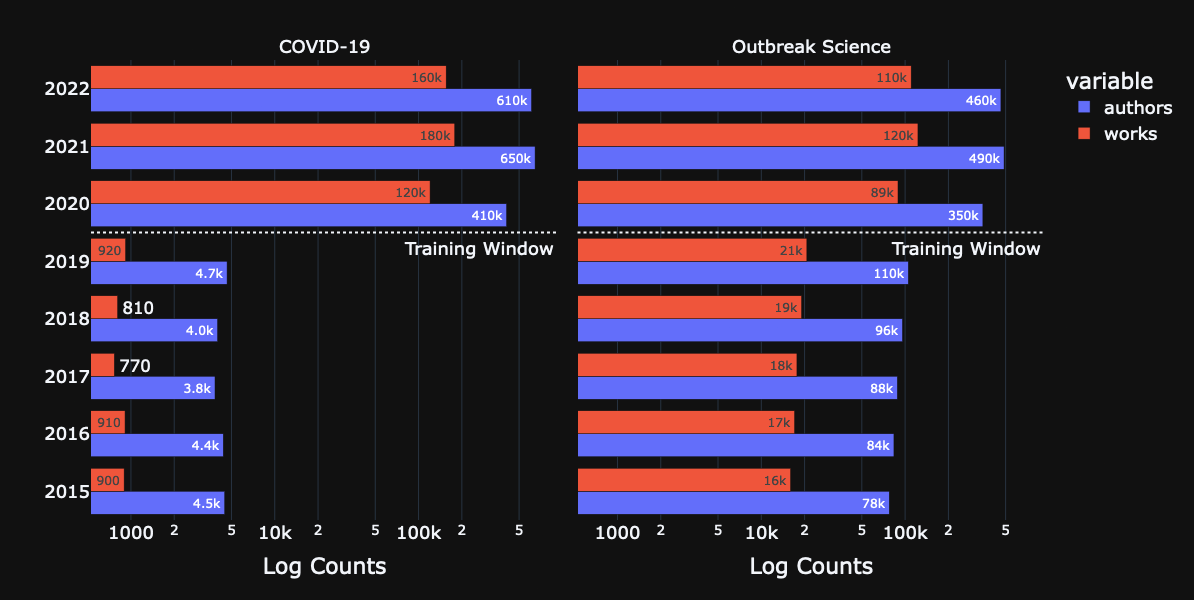

In [19]:
plot_yearly_works_authors(works_authors=works_authors, all_covid_works=all_covid_works, all_outbreak_science_works=all_outbreak_science_works)

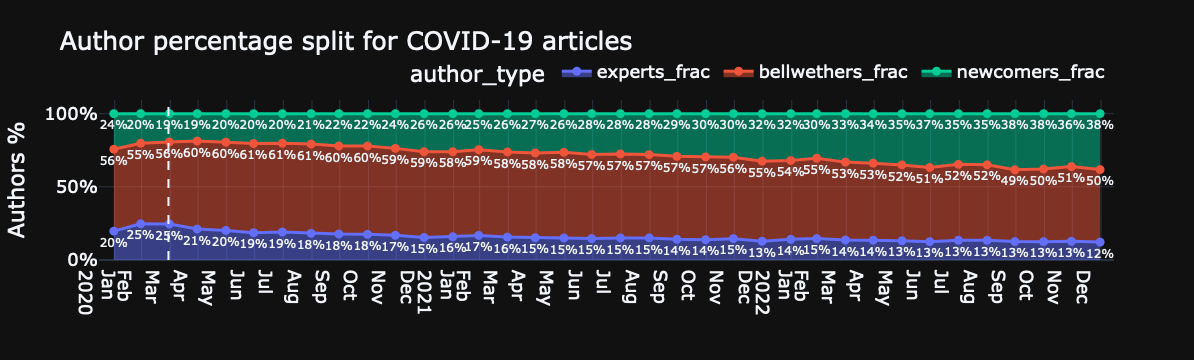

In [19]:
plot_author_types_timeline(author_types_df)

/N/scratch/ssikdar/envs/newcomers/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



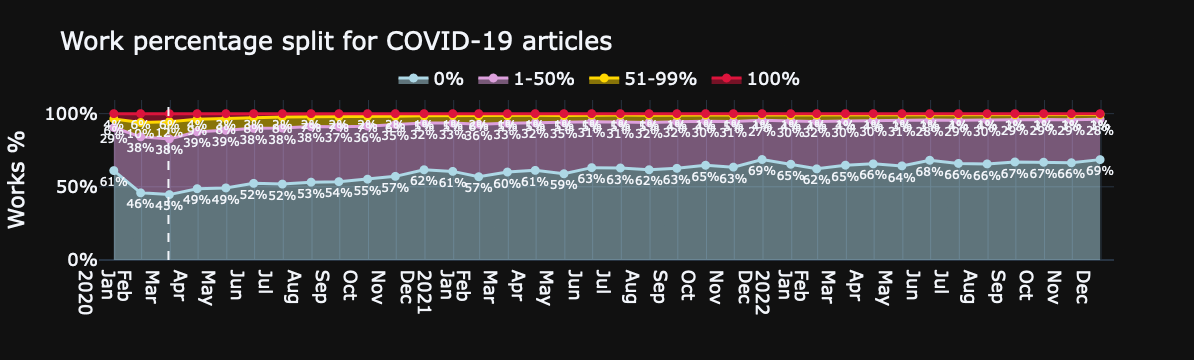

In [23]:
plot_work_types_timeline(work_types_df)

In [51]:
dump_pickle(litcovid_work_ids, './pickles/litcovid_work_ids.pkl.gz')

Pickle saved at 'pickles/litcovid_work_ids.pkl.gz'


In [42]:
litcovid_data = load_pickle('/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/pickles/litCOVID_agg.pkl')

In [43]:
litcovid_data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [47]:
lc = litcovid_data['work_ids_ow']

In [50]:
(
    works_authors_ow
    .query('work_id.isin(@litcovid_work_ids)')
    .nunique()
)

work_id             275998
author_id           929144
publication_year         3
publication_date      1096
dtype: int64

In [48]:
(
    works_authors
    .query('work_id.isin(@lc)')
    .nunique()
)

work_id             275998
author_id           929144
publication_year         3
publication_date      1096
dtype: int64

### find most frequent concepts by bellwethers in the EW

In [39]:
works_concepts_01 = (  # get all rows, even scores < 0.3
    read_parquet(basepath / 'works_concepts', convert_dtypes=False)
    .query('level<2')
)
works_concepts_01 = (
    works_concepts_01
    [
        works_concepts_01.publication_date.between(start_date_tw, end_date_tw)
    ]
    .drop(columns=['publication_year', 'publication_month'])
)
works_concepts_01


Reading 'works_concepts' using engine='fastparquet'
Read 937,659,394 rows from 'works_concepts' in 206.45 sec.


work_id  concept_id           concept_name  level  \
__null_dask_index__                                                      
4926557                 4600  2779478453   Modularity (biology)      2   
4926558                 4600  2776154427           Constitution      2   
4926559                 4600  2779343474  Context (archaeology)      2   

                        score  publication_month  publication_year  \
__null_dask_index__                                                  
4926557              0.802246                  9              2013   
4926558              0.761719                  9              2013   
4926559              0.538086                  9              2013   

                    publication_date  
__null_dask_index__                   
4926557                   2013-09-05  
4926558                   2013-09-05  
4926559                   2013-09-05

/tmp/ipykernel_37923/3332009940.py:3: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query('level<2')


work_id  concept_id          concept_name  level  \
__null_dask_index__                                                        
4926560                    4600   144024400             Sociology      0   
4926561                    4600    17744445     Political science      0   
4926562                    4600   205649164             Geography      0   
4926563                    4600    78458016  Evolutionary biology      1   
4926564                    4600    86803240               Biology      0   
...                         ...         ...                   ...    ...   
6266197              2583011715   545542383     Medical emergency      1   
6266198              2583011715    54355233              Genetics      1   
6266199              2583011715   121332964               Physics      0   
6266200              2583011715    24890656             Acoustics      1   
6266201              2583011715    86803240               Biology      0   

                        score  publication_month  publication_year  \
__null_dask_index__                                                  
4926560              0.321045                  9              2013   
4926561              0.308838                  9              2013   
4926562              0.303223                  9              2013   
4926563              0.156250                  9              2013   
4926564              0.141602                  9              2013   
...                       ...                ...               ...   
6266197              0.243286                  5              2017   
6266198              0.000000                  5              2017   
6266199              0.000000                  5              2017   
6266200              0.000000                  5              2017   
6266201              0.000000                  5              2017   

                    publication_date  
__null_dask_index__                   
4926560                   2013-09-05  
4926561                   2013-09-05  
4926562                   2013-09-05  
4926563                   2013-09-05  
4926564                   2013-09-05  
...                              ...  
6266197                   2017-05-01  
6266198                   2017-05-01  
6266199                   2017-05-01  
6266200                   2017-05-01  
6266201                   2017-05-01  

[497898383 rows x 8 columns]

In [114]:
def get_author_past_concept_vectors(auths, top_k=5):
    """
    For each author, get top k most frequent aggregated concept vectors in the TW/EW 
    levels 0 and 1 only
    """
    authors_works_concepts = (
        authors_works_concepts_all
        [authors_works_concepts_all.author_id.isin(auths)]
        .groupby(['author_id', 'concept_id'], sort=False, as_index=False)
        .agg(
            counts=('work_id', 'count'),
            counts_gt_0=('score', lambda grp: (grp>0).sum()),
            concept_name=('concept_name', 'first'),
            level=('level', 'first'),
            mean_score=('score', 'mean'),
            median_score=('score', 'median'),
            min_score=('score', 'min'),
            max_score=('score', 'max'),
        )
        .sort_values(by='counts', ascending=False)
        .groupby('author_id', sort=False)
        .head(top_k)
    )
    return authors_works_concepts

def get_most_frequent_concepts(authors_works_concepts, top_k=10):
    """
    Return the top k most frequent concepts within the authors works concepts dataframe
    """
    return (
        authors_works_concepts
        .groupby('concept_id', sort=False, as_index=False)
        .agg(
            concept_name=('concept_name', 'first'),
            level=('level', 'first'),
            total_counts=('counts', 'sum'),
            total_counts_gt_0=('counts_gt_0', 'sum'),
        )
        .assign(
            rank=lambda df_: df_.total_counts.rank(ascending=False, method='min').astype('int'),
            rank_gt_0=lambda df_: df_.total_counts_gt_0.rank(ascending=False, method='min').astype('int'),
        )
        .sort_values(by='rank')
        .query('rank<=@top_k')
    )

In [116]:
authors_works_concepts_all = (
    works_concepts_01
    .merge(
        works_authors_ew
        [works_authors_ew.author_id.isin(covid_bellwethers)]
        .drop(columns=['publication_date']),
        on='work_id',
        how='inner',
    )
)
authors_works_concepts_all

ERROR! Session/line number was not unique in database. History logging moved to new session 2790


work_id  concept_id         concept_name  level     score  \
0           31594704   171250308       Nanotechnology      1  0.459961   
1           31594704   159467904     Chemical physics      1  0.444580   
2           31594704   121864883  Statistical physics      1  0.410400   
3           31594704   192562407    Materials science      0  0.350586   
4           31594704   121332964              Physics      0  0.307129   
...              ...         ...                  ...    ...       ...   
66080097  2585080952   178790620    Organic chemistry      1  0.091797   
66080098  2585080952   178790620    Organic chemistry      1  0.091797   
66080099  2585080952    86803240              Biology      0  0.055542   
66080100  2585080952    86803240              Biology      0  0.055542   
66080101  2585080952    86803240              Biology      0  0.055542   

         publication_date   author_id  
0              2015-09-09  4358200548  
1              2015-09-09  4358200548  
2              2015-09-09  4358200548  
3              2015-09-09  4358200548  
4              2015-09-09  4358200548  
...                   ...         ...  
66080097       2017-03-01  4358037017  
66080098       2017-03-01  4358252863  
66080099       2017-03-01  4356831935  
66080100       2017-03-01  4358037017  
66080101       2017-03-01  4358252863  

[66080102 rows x 7 columns]

In [115]:
auths = list(covid_bellwethers)[: 10]
print(auths)
authors_past_works_concepts = get_author_past_concept_vectors(auths)
get_most_frequent_concepts(authors_past_works_concepts)

[2623537152, 2336227332, 4332716042, 4336910349, 2799697934, 2898264084, 4349493269, 2747269141, 2166358036, 4355784730]


concept_id       concept_name  level  total_counts  total_counts_gt_0  \
0     71924100           Medicine      0            38                 38   
1     86803240            Biology      0            21                 17   
3    203014093         Immunology      1            16                 16   
5    126322002  Internal medicine      1            14                 13   
2     17744445  Political science      0            11                  9   
4      1862650   Physical therapy      1             8                  8   
6     16005928        Dermatology      1             7                  7   
13    33923547        Mathematics      0             6                  4   
7    144133560           Business      0             5                  5   
8     29456083         Gynecology      1             4                  4   
14    41008148   Computer science      0             4                  4   

    rank  rank_gt_0  
0      1          1  
1      2          2  
3      3          3  
5      4          4  
2      5          5  
4      6          6  
6      7          7  
13     8          9  
7      9          8  
8     10          9  
14    10          9

* for each bellwether during each month
 - pick the 5 most frequent level 0 and 1 concepts (based on their prior works)
 - make a ranked list of concepts over time 


In [117]:
observation_window = pd.date_range(start_date_ow, end_date_ow, freq='M')
concept_rank_dfs = []
with tqdm(observation_window) as pbar:
    for i, month_end_date in enumerate(observation_window):       
        month_start_date = month_end_date - pd.offsets.MonthBegin()
        assert month_start_date.day==1 and month_start_date.month==month_end_date.month
        pbar.set_description(f'COVID-19 {month_start_date.to_period("D")}')

        covid_works_month = set(
            covid_works
            [covid_works.publication_date.between(month_start_date, month_end_date)]
            .index
        )

        covid_authors_month = set(
            covid_works_authors
            [covid_works_authors.work_id.isin(covid_works_month)]
            .author_id
        )

        covid_bellwethers_month = covid_authors_month & covid_bellwethers
        
        # print(f'{month_start_date.date()}: COVID works: {len(covid_works_month):,} \t authors: {len(covid_authors_month):,} \t bellwethers: {len(covid_bellwethers_month):,}')

        concept_rank_month_df = (
            get_most_frequent_concepts(get_author_past_concept_vectors(covid_bellwethers_month))
            .assign(
                date=month_end_date.date(), month_idx=i+1,
            )
        )
        concept_rank_dfs.append(concept_rank_month_df)
        pbar.update(1)

  0%|          | 0/36 [00:00<?, ?it/s]

In [118]:
combined_ranks_df = pd.concat(concept_rank_dfs)
combined_ranks_df

concept_id       concept_name  level  total_counts  total_counts_gt_0  \
7     71924100           Medicine      0         23337              22838   
9    126322002  Internal medicine      1         11639              11422   
5     86803240            Biology      0         11403               9316   
1     41008148   Computer science      0          7314               6911   
3    185592680          Chemistry      0          6157               5772   
..         ...                ...    ...           ...                ...   
0    185592680          Chemistry      0         20427              19283   
6    121332964            Physics      0         12158               8673   
28   141071460            Surgery      1         10849              10793   
40    54355233           Genetics      1         10652               7168   
4    127413603        Engineering      0         10520               8167   

    rank  rank_gt_0        date  month_idx  
7      1          1  2020-01-31          1  
9      2          2  2020-01-31          1  
5      3          3  2020-01-31          1  
1      4          4  2020-01-31          1  
3      5          5  2020-01-31          1  
..   ...        ...         ...        ...  
0      6          6  2022-12-31         36  
6      7         10  2022-12-31         36  
28     8          7  2022-12-31         36  
40     9         14  2022-12-31         36  
4     10         11  2022-12-31         36  

[360 rows x 9 columns]

In [119]:
combined_ranks_df.to_csv('./csvs/COVID_bellwethers_monthly_ranks.csv', index=False)

In [154]:
monthly_ranks = (
    combined_ranks_df
    .assign(
        label=lambda df_: df_.apply(lambda row: f'{row.concept_name} ({row.total_counts:,})', axis=1)
    )
    .pivot(
        index='rank_gt_0',
        columns='date',
        values='concept_name'
    )
)
monthly_ranks

date              2020-01-31         2020-02-29         2020-03-31  \
rank_gt_0                                                            
1                   Medicine           Medicine           Medicine   
2          Internal medicine          Chemistry            Biology   
3                    Biology            Biology          Chemistry   
4           Computer science   Computer science   Computer science   
5                  Chemistry  Materials science  Materials science   
6          Materials science  Internal medicine  Internal medicine   
7                Engineering            Physics            Physics   
8                    Surgery        Engineering        Engineering   
9                    Physics       Biochemistry       Biochemistry   
10                Psychology                NaN                NaN   
11                       NaN           Genetics           Genetics   
12                       NaN                NaN                NaN   
13                       NaN                NaN                NaN   
14                       NaN                NaN                NaN   
15                       NaN                NaN                NaN   

date              2020-04-30         2020-05-31         2020-06-30  \
rank_gt_0                                                            
1                   Medicine           Medicine           Medicine   
2          Internal medicine  Internal medicine  Internal medicine   
3                    Biology            Biology            Biology   
4                  Chemistry   Computer science   Computer science   
5           Computer science          Chemistry          Chemistry   
6          Materials science  Materials science  Materials science   
7                    Physics            Surgery            Surgery   
8                    Surgery            Physics            Physics   
9                Engineering        Engineering         Psychology   
10                       NaN         Psychology        Engineering   
11              Biochemistry                NaN                NaN   
12                       NaN                NaN                NaN   
13                       NaN                NaN                NaN   
14                       NaN                NaN                NaN   
15                       NaN                NaN                NaN   

date              2020-07-31         2020-08-31         2020-09-30  \
rank_gt_0                                                            
1                   Medicine           Medicine           Medicine   
2          Internal medicine  Internal medicine  Internal medicine   
3                    Biology            Biology            Biology   
4           Computer science   Computer science   Computer science   
5                  Chemistry          Chemistry          Chemistry   
6          Materials science  Materials science  Materials science   
7                    Surgery            Surgery            Surgery   
8                    Physics            Physics         Psychology   
9                Engineering        Engineering            Physics   
10                Psychology         Psychology        Engineering   
11                       NaN                NaN                NaN   
12                       NaN                NaN                NaN   
13                       NaN                NaN                NaN   
14                       NaN                NaN                NaN   
15                       NaN                NaN                NaN   

date              2020-10-31  ...         2022-03-31         2022-04-30  \
rank_gt_0                     ...                                         
1                   Medicine  ...           Medicine           Medicine   
2          Internal medicine  ...  Internal medicine  Internal medicine   
3                    Biology  ...            Biology            Biology   
4           Computer science  ...   Computer science

In [126]:
combined_ranks_df

concept_id       concept_name  level  total_counts  total_counts_gt_0  \
7     71924100           Medicine      0         23337              22838   
9    126322002  Internal medicine      1         11639              11422   
5     86803240            Biology      0         11403               9316   
1     41008148   Computer science      0          7314               6911   
3    185592680          Chemistry      0          6157               5772   
..         ...                ...    ...           ...                ...   
0    185592680          Chemistry      0         20427              19283   
6    121332964            Physics      0         12158               8673   
28   141071460            Surgery      1         10849              10793   
40    54355233           Genetics      1         10652               7168   
4    127413603        Engineering      0         10520               8167   

    rank  rank_gt_0        date  month_idx  
7      1          1  2020-01-31          1  
9      2          2  2020-01-31          1  
5      3          3  2020-01-31          1  
1      4          4  2020-01-31          1  
3      5          5  2020-01-31          1  
..   ...        ...         ...        ...  
0      6          6  2022-12-31         36  
6      7         10  2022-12-31         36  
28     8          7  2022-12-31         36  
40     9         14  2022-12-31         36  
4     10         11  2022-12-31         36  

[360 rows x 9 columns]

In [129]:
concepts = list(monthly_ranks.iloc[:, 0].values)

In [152]:
monthly_ranks

date         2020-01-31         2020-02-29         2020-03-31  \
rank                                                            
1              Medicine           Medicine           Medicine   
2     Internal medicine            Biology            Biology   
3               Biology          Chemistry          Chemistry   
4      Computer science   Computer science   Computer science   
5             Chemistry  Materials science  Materials science   
6           Engineering            Physics  Internal medicine   
7     Materials science  Internal medicine            Physics   
8               Physics        Engineering        Engineering   
9               Surgery       Biochemistry       Biochemistry   
10           Psychology           Genetics           Genetics   

date         2020-04-30         2020-05-31         2020-06-30  \
rank                                                            
1              Medicine           Medicine           Medicine   
2               Biology  Internal medicine  Internal medicine   
3     Internal medicine            Biology            Biology   
4             Chemistry   Computer science   Computer science   
5      Computer science          Chemistry          Chemistry   
6     Materials science            Physics            Physics   
7               Physics  Materials science  Materials science   
8           Engineering        Engineering        Engineering   
9               Surgery            Surgery            Surgery   
10         Biochemistry         Psychology         Psychology   

date         2020-07-31         2020-08-31         2020-09-30  \
rank                                                            
1              Medicine           Medicine           Medicine   
2     Internal medicine  Internal medicine  Internal medicine   
3               Biology            Biology            Biology   
4      Computer science   Computer science   Computer science   
5             Chemistry          Chemistry          Chemistry   
6               Physics  Materials science            Physics   
7     Materials science            Physics  Materials science   
8           Engineering        Engineering        Engineering   
9               Surgery            Surgery            Surgery   
10           Psychology         Psychology         Psychology   

date         2020-10-31  ...         2022-03-31         2022-04-30  \
rank                     ...                                         
1              Medicine  ...           Medicine           Medicine   
2     Internal medicine  ...  Internal medicine  Internal medicine   
3               Biology  ...            Biology            Biology   
4      Computer science  ...   Computer science   Computer science   
5             Chemistry  ...          Chemistry          Chemistry   
6               Physics  ...            Physics         Psychology   
7     Materials science  ...         Psychology            Physics   
8           Engineering  ...        Engineering  Materials science   
9            Psychology  ...  Materials science        Engineering   
10              Surgery  ...            Surgery            Surgery   

date         2022-05-31         2022-06-30         2022-07-31  \
rank                                                            
1              Medicine           Medicine           Medicine   
2     Internal medicine  Internal medicine  Internal medicine   
3               Biology            Biology            Biology   
4      Computer science   Computer science   Computer science   
5             Chemistry          Chemistry          Chemistry   
6               Physics         Psychology  Materials science   
7     Materials science        Engineering            Physics   
8            Psychology  Materials science         Psychology   
9           Engineering            Physics        Engineering   
10              Surgery            Surgery           Genetics   

date         2022-08-31         202

In [161]:
combined_ranks_df

concept_id       concept_name  level  total_counts  total_counts_gt_0  \
7     71924100           Medicine      0         23337              22838   
9    126322002  Internal medicine      1         11639              11422   
5     86803240            Biology      0         11403               9316   
1     41008148   Computer science      0          7314               6911   
3    185592680          Chemistry      0          6157               5772   
..         ...                ...    ...           ...                ...   
0    185592680          Chemistry      0         20427              19283   
6    121332964            Physics      0         12158               8673   
28   141071460            Surgery      1         10849              10793   
40    54355233           Genetics      1         10652               7168   
4    127413603        Engineering      0         10520               8167   

    rank  rank_gt_0        date  month_idx  
7      1          1  2020-01-31          1  
9      2          2  2020-01-31          1  
5      3          3  2020-01-31          1  
1      4          4  2020-01-31          1  
3      5          5  2020-01-31          1  
..   ...        ...         ...        ...  
0      6          6  2022-12-31         36  
6      7         10  2022-12-31         36  
28     8          7  2022-12-31         36  
40     9         14  2022-12-31         36  
4     10         11  2022-12-31         36  

[360 rows x 9 columns]

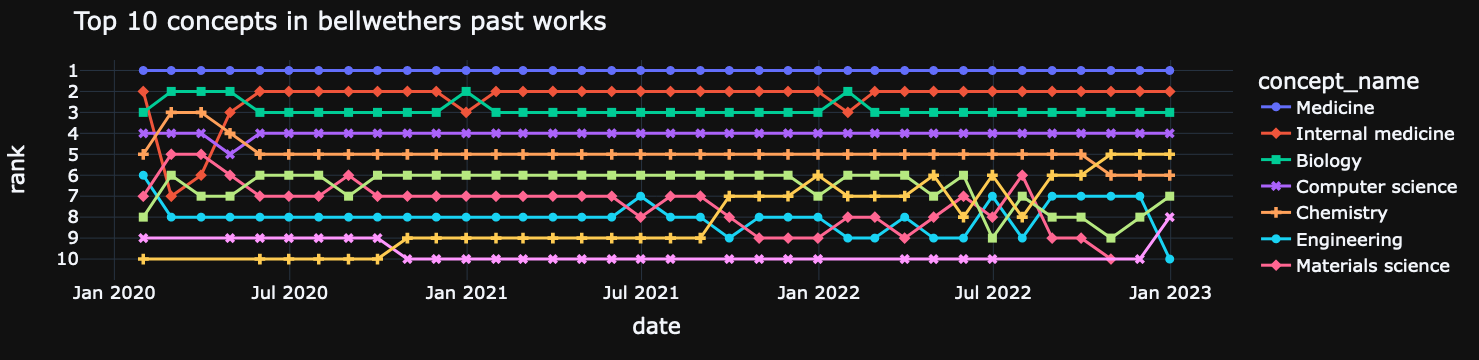

In [203]:
df = (
    combined_ranks_df.query('concept_name.isin(@concepts)')
    .astype(dict(concept_name='string'))
)
fig = px.line(
    df, height=600,
    x='date', y='rank', color='concept_name',
    symbol='concept_name',
    category_orders={'concept_name': concepts},
)
fig.update_layout(
    title=f'Top 10 concepts in bellwethers past works',
)

fig.update_yaxes(range=[11, 0.5], tickvals=np.arange(1, 11))

In [169]:
(
    combined_ranks_df.query('concept_name.isin(@concepts)')
    .concept_
)

Empty DataFrame
Columns: [concept_id, concept_name, level, total_counts, total_counts_gt_0, rank, rank_gt_0, date, month_idx]
Index: []

In [171]:
combined_ranks_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 7 to 4
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   concept_id         360 non-null    Int64   
 1   concept_name       360 non-null    category
 2   level              360 non-null    UInt8   
 3   total_counts       360 non-null    int64   
 4   total_counts_gt_0  360 non-null    int64   
 5   rank               360 non-null    int64   
 6   rank_gt_0          360 non-null    int64   
 7   date               360 non-null    object  
 8   month_idx          360 non-null    int64   
dtypes: Int64(1), UInt8(1), category(1), int64(5), object(1)
memory usage: 2.5+ MB


In [8]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=8, progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
sorted_works_authors = (
    works_authors
    .query('publication_date.between("2012-01-01", "2022-12-31")')
    .sort_values(by='publication_date')
    .set_index('publication_date')
)
sorted_works_authors

work_id   author_id
publication_date                        
2012-01-01        4242605097  5017339174
2012-01-01        2133834454  5011137299
2012-01-01        2316509968  5077783632
2012-01-01        2316509968  5027441543
2012-01-01        2316509968  5012690542
...                      ...         ...
2022-12-31        4297192854  5052060933
2022-12-31        4297584015  5004692218
2022-12-31        4297584015  5023585323
2022-12-31        4297393812  5057794678
2022-12-31        4323519993  5045545402

[209894281 rows x 2 columns]

In [10]:
pd.options.mode.chained_assignment = 'raise'
pd.options.compute.use_bottleneck = True
pd.options.compute.use_numexpr = True

In [12]:
def f(ser):
    return pd.Series({
        'authorships': len(ser.work_id), 
        'unique_works': ser.work_id.nunique(), 
        'unique_authors': ser.author_id.nunique()})

In [15]:
del sorted_works_authors
gc.collect()

0

In [13]:
agg_stats = (
    sorted_works_authors
    # .head(1000)
    .groupby(pd.Grouper(freq='6M', sort=False))
    # .groupby(pd.Grouper(key='publication_date', freq='6M', sort=False))
    .parallel_apply(f)
    # .agg(
    #     authorships=('work_id', 'count'),
    #     # unique_works=('work_id', 'nunique'),
    #     # unique_authors=('author_id', 'nunique'),
    # )
)
agg_stats

Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-3:
Traceback (most recent call last):
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/process.py", line 108

KeyboardInterrupt: 

  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/pandarallel/core.py", line 95, in __call__
    result = self.work_function(
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/pandarallel/core.py", line 95, in __call__
    result = self.work_function(
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/pandarallel/data_types/dataframe_groupby.py", line 40, in work
    return [compute_result(key, df) for key, df in data]
  File "/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/pandarallel/data_types/dataframe_groupby.py", line 40, in work
    return [compute_result(key, df) for key, df in data]
  File "/N/slate/ssikdar/env

In [ ]:
agg_stats = (
    sorted_works_authors
    # .head(1000)
    .groupby(pd.Grouper(freq='6M', sort=False))
    .progress_apply(f)
    # .groupby(pd.Grouper(key='publication_date', freq='6M', sort=False))
    # .parallel_apply(f)
    # .agg(
    #     authorships=('work_id', 'count'),
    #     # unique_works=('work_id', 'nunique'),
    #     # unique_authors=('author_id', 'nunique'),
    # )
)
agg_stats

In [ ]:
def uniq_count(s):
    return s.nunique()

In [102]:
monthly_counts = (
    sorted_works_authors
    .groupby(pd.Grouper(freq='1M', sort=False))
    .progress_apply(f)
)
monthly_counts

  0%|          | 0/132 [00:00<?, ?it/s]

authorships  unique_works  unique_authors
publication_date                                           
2012-01-31             550389        169165          456343
2012-02-29             931183        260899          719214
2012-03-31            1058759        318765          804942
2012-04-30            1071623        299436          800866
2012-05-31            1141584        317814          839192
...                       ...           ...             ...
2022-08-31            2222061        533699         1627648
2022-09-30            2483720        595830         1803097
2022-10-31            2465058        590646         1770794
2022-11-30            2508679        590426         1784453
2022-12-31            2800060        733784         2023887

[132 rows x 3 columns]

/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



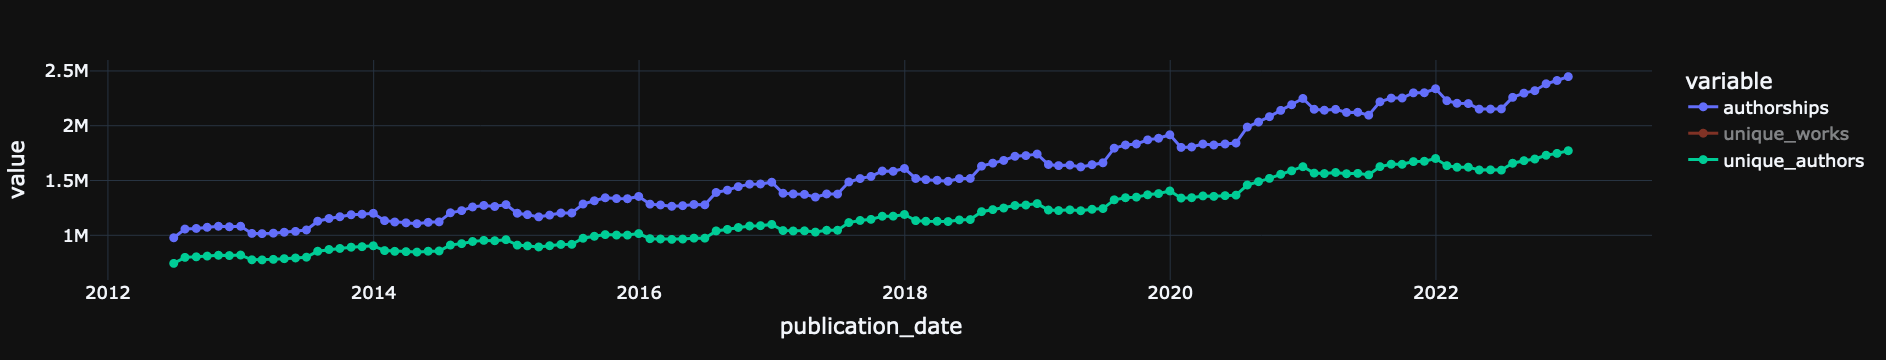

In [105]:
(
    monthly_counts
    .assign(
        uniq_authors_5yr=   
    )
    .rolling(6)
    .mean()
    .dropna()
    .plot
    .line(markers=True)
)

In [ ]:
### for each month, get #unique authors in the past 5 years 
(
    sorted_works_authors
    .groupby(pd.Grouper(freq='1M', sort=False))
    .rolling(60)
    .work_id
    .progress_apply(uniq_count)
)

0it [00:00, ?it/s]

In [124]:
(
    sorted_works_authors
    .groupby(pd.Grouper(freq='1M', sort=False))
    .size()
    .loc['2012-02-01': '2017-02-01']
    .sum()
)

72526265

In [5]:
basepath = Path('/N/project/openalex/slices/subset-2012-2022/cleaned/aug-2023')

lev0_works_concepts = (
    read_parquet(basepath / 'works_concepts', convert_dtypes=False, 
                 engine='pyarrow', filters=[[('level', '=', 0)]])
)
lev0_works_concepts


Reading 'works_concepts' using engine='pyarrow'
Read 188,834,280 rows from 'works_concepts' in 84.82 sec.


work_id  concept_id           concept_name  level  \
__null_dask_index__                                                        
761818               380057522    41008148       Computer science      0   
761821               380057522    39432304  Environmental science      0   
761824               380057522    33923547            Mathematics      0   

                        score  publication_month  publication_year  \
__null_dask_index__                                                  
761818               0.417240                  9              2015   
761821               0.344928                  9              2015   
761824               0.251500                  9              2015   

                    publication_date  
__null_dask_index__                   
761818                    2015-09-01  
761821                    2015-09-01  
761824                    2015-09-01

work_id  concept_id           concept_name  level  \
__null_dask_index__                                                         
761818                380057522    41008148       Computer science      0   
761821                380057522    39432304  Environmental science      0   
761824                380057522    33923547            Mathematics      0   
761825                380057522   121332964                Physics      0   
2781474               376699096    41008148       Computer science      0   
...                         ...         ...                    ...    ...   
1950235              4312333191   205649164              Geography      0   
1950238              4312333191    33923547            Mathematics      0   
1954155              4312394350   121332964                Physics      0   
1954156              4312394350   142362112                    Art      0   
1954157              4312394350    86803240                Biology      0   

                        score  publication_month  publication_year  \
__null_dask_index__                                                  
761818               0.417240                  9              2015   
761821               0.344928                  9              2015   
761824               0.251500                  9              2015   
761825               0.000000                  9              2015   
2781474              0.313878                  3              2009   
...                       ...                ...               ...   
1950235              0.126286                 11              2022   
1950238              0.000000                 11              2022   
1954155              0.433739                  8              2022   
1954156              0.329419                  8              2022   
1954157              0.072068                  8              2022   

                    publication_date  
__null_dask_index__                   
761818                    2015-09-01  
761821                    2015-09-01  
761824                    2015-09-01  
761825                    2015-09-01  
2781474                   2009-03-31  
...                              ...  
1950235                   2022-11-23  
1950238                   2022-11-23  
1954155                   2022-08-29  
1954156                   2022-08-29  
1954157                   2022-08-29  

[188834280 rows x 8 columns]

In [21]:
lev0_works_concepts_filt = (
    lev0_works_concepts
    .query('score>0.3')
)
lev0_works_concepts_filt

work_id  concept_id           concept_name  level  \
__null_dask_index__                                                         
761818                380057522    41008148       Computer science      0   
761821                380057522    39432304  Environmental science      0   
2781474               376699096    41008148       Computer science      0   
110185                379026935   185592680              Chemistry      0   
110191                379026935   192562407      Materials science      0   
...                         ...         ...                    ...    ...   
1945077              4312254307   127413603            Engineering      0   
1945078              4312254307    41008148       Computer science      0   
1950227              4312333191   162324750              Economics      0   
1954155              4312394350   121332964                Physics      0   
1954156              4312394350   142362112                    Art      0   

                        score  publication_month  publication_year  \
__null_dask_index__                                                  
761818               0.417240                  9              2015   
761821               0.344928                  9              2015   
2781474              0.313878                  3              2009   
110185               0.546537                 11              2015   
110191               0.367861                 11              2015   
...                       ...                ...               ...   
1945077              0.349430                  4              2023   
1945078              0.332287                  4              2023   
1950227              0.452817                 11              2022   
1954155              0.433739                  8              2022   
1954156              0.329419                  8              2022   

                    publication_date  
__null_dask_index__                   
761818                    2015-09-01  
761821                    2015-09-01  
2781474                   2009-03-31  
110185                    2015-11-01  
110191                    2015-11-01  
...                              ...  
1945077                   2023-04-01  
1945078                   2023-04-01  
1950227                   2022-11-23  
1954155                   2022-08-29  
1954156                   2022-08-29  

[97240105 rows x 8 columns]

In [6]:
f'{lev0_works_concepts.work_id.nunique()=:,}'

'lev0_works_concepts.work_id.nunique()=73,226,811'

In [7]:
concept_monthly_counts = (
    lev0_works_concepts
    .sort_values(by='publication_date')
    .groupby(['concept_id', pd.Grouper(key='publication_date', freq='1M')], sort=False)
    .agg(
        concept_name=('concept_name', 'first'),
        num_works=('work_id', 'count'),
    )
)

concept_monthly_counts

concept_name  num_works
concept_id publication_date                              
17744445   2008-01-31        Political science      16578
138885662  2008-01-31               Philosophy      16272
144024400  2008-01-31                Sociology       9538
121332964  2008-01-31                  Physics      26317
71924100   2008-01-31                 Medicine      32716
...                                        ...        ...
121332964  2023-12-31                  Physics      14906
17744445   2023-12-31        Political science      12529
142362112  2023-12-31                      Art       5482
95457728   2023-12-31                  History       3670
205649164  2023-12-31                Geography       6917

[3648 rows x 2 columns]

In [8]:
concept_monthly_counts_agg = (
    concept_monthly_counts
    .join(
        concept_monthly_counts
        .reset_index()
        .sort_values(by=['concept_id', 'publication_date'])
        .assign(concept_name=lambda df_: df_.concept_name.astype('string'))
        .groupby('concept_id', sort=False)
        .rolling(6, on='publication_date')
        .num_works
        .mean()
        .rename('num_works_6M')
    )
)
concept_monthly_counts_agg

concept_name  num_works  num_works_6M
concept_id publication_date                                            
17744445   2008-01-31        Political science      16578           NaN
138885662  2008-01-31               Philosophy      16272           NaN
144024400  2008-01-31                Sociology       9538           NaN
121332964  2008-01-31                  Physics      26317           NaN
71924100   2008-01-31                 Medicine      32716           NaN
...                                        ...        ...           ...
121332964  2023-12-31                  Physics      14906  36095.833333
17744445   2023-12-31        Political science      12529  22441.166667
142362112  2023-12-31                      Art       5482   9071.000000
95457728   2023-12-31                  History       3670   5089.000000
205649164  2023-12-31                Geography       6917  12800.666667

[3648 rows x 3 columns]

In [22]:
concept_monthly_counts_filt = (
    lev0_works_concepts_filt
    .sort_values(by='publication_date')
    .groupby(['concept_id', pd.Grouper(key='publication_date', freq='1M')], sort=False)
    .agg(
        concept_name=('concept_name', 'first'),
        num_works=('work_id', 'count'),
    )
)

concept_monthly_counts_filt

concept_name  num_works
concept_id publication_date                             
144133560  2008-01-31                Business       6082
41008148   2008-01-31        Computer science      22097
71924100   2008-01-31                Medicine      23872
86803240   2008-01-31                 Biology      11037
15744967   2008-01-31              Psychology       8972
...                                       ...        ...
142362112  2023-12-31                     Art       3121
127313418  2023-12-31                 Geology       1781
121332964  2023-12-31                 Physics       2376
138885662  2023-12-31              Philosophy       2696
144024400  2023-12-31               Sociology       3645

[3648 rows x 2 columns]

In [23]:
concept_monthly_counts_agg_filt = (
    concept_monthly_counts_filt
    .join(
        concept_monthly_counts_filt
        .reset_index()
        .sort_values(by=['concept_id', 'publication_date'])
        .assign(concept_name=lambda df_: df_.concept_name.astype('string'))
        .groupby('concept_id', sort=False)
        .rolling(6, on='publication_date')
        .num_works
        .mean()
        .rename('num_works_6M')
    )
)
concept_monthly_counts_agg_filt

concept_name  num_works  num_works_6M
concept_id publication_date                                           
144133560  2008-01-31                Business       6082           NaN
41008148   2008-01-31        Computer science      22097           NaN
71924100   2008-01-31                Medicine      23872           NaN
86803240   2008-01-31                 Biology      11037           NaN
15744967   2008-01-31              Psychology       8972           NaN
...                                       ...        ...           ...
142362112  2023-12-31                     Art       3121   4335.666667
127313418  2023-12-31                 Geology       1781   3842.000000
121332964  2023-12-31                 Physics       2376   7347.833333
138885662  2023-12-31              Philosophy       2696   4269.333333
144024400  2023-12-31               Sociology       3645   6585.166667

[3648 rows x 3 columns]

/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



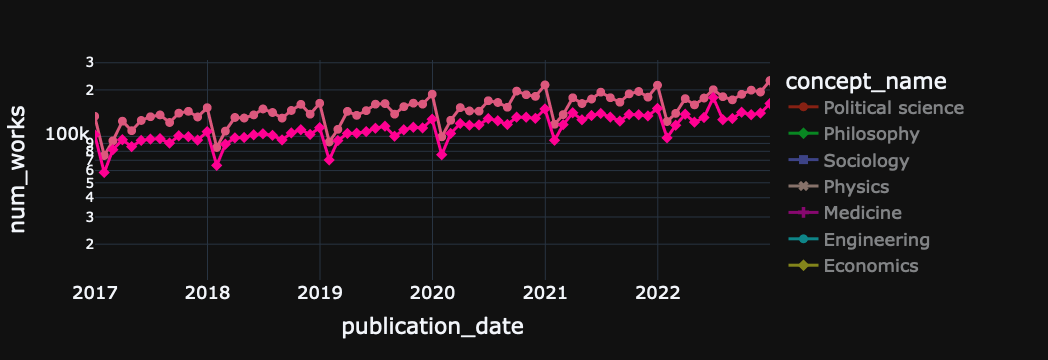

In [15]:
fig = (
    concept_monthly_counts_agg
    .reset_index()
    .assign(concept_name=lambda df_: df_.concept_name.astype('string'))
    .plot
    .line(
        x='publication_date', color='concept_name',
        y='num_works', symbol='concept_name',
        height=700, color_discrete_sequence=px.colors.qualitative.Light24,
        range_x=['2017-01-01', '2022-12-31'],
        log_y=True,
    #     # facet_col='concept_name', facet_col_wrap=3, height=1000,
    )
)

# fig.update_yaxes(matches=None)
# fig.update_layout(showlegend=False)
fig

/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



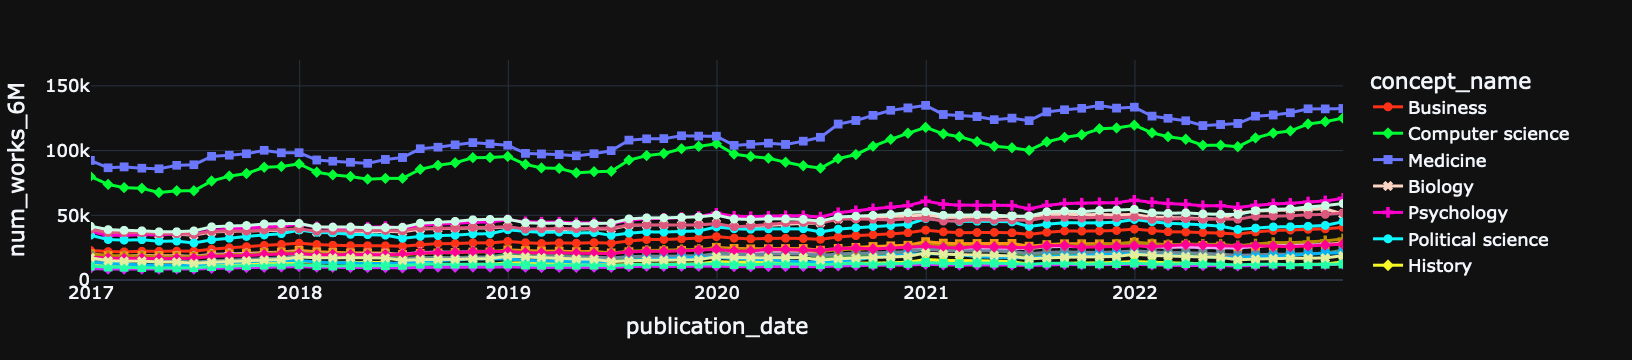

In [30]:
fig = (
    concept_monthly_counts_agg_filt
    .reset_index()
    .assign(concept_name=lambda df_: df_.concept_name.astype('string'))
    .plot
    .line(
        x='publication_date', color='concept_name',
        y='num_works_6M', symbol='concept_name',
        height=700, color_discrete_sequence=px.colors.qualitative.Light24,
        range_x=['2017-01-01', '2022-12-31'],
        range_y=[0, 170_000],
        # log_y=True,
    #     # facet_col='concept_name', facet_col_wrap=3, height=1000,
    )
)

# fig.update_yaxes(matches=None)
# fig.update_layout(showlegend=False)
fig

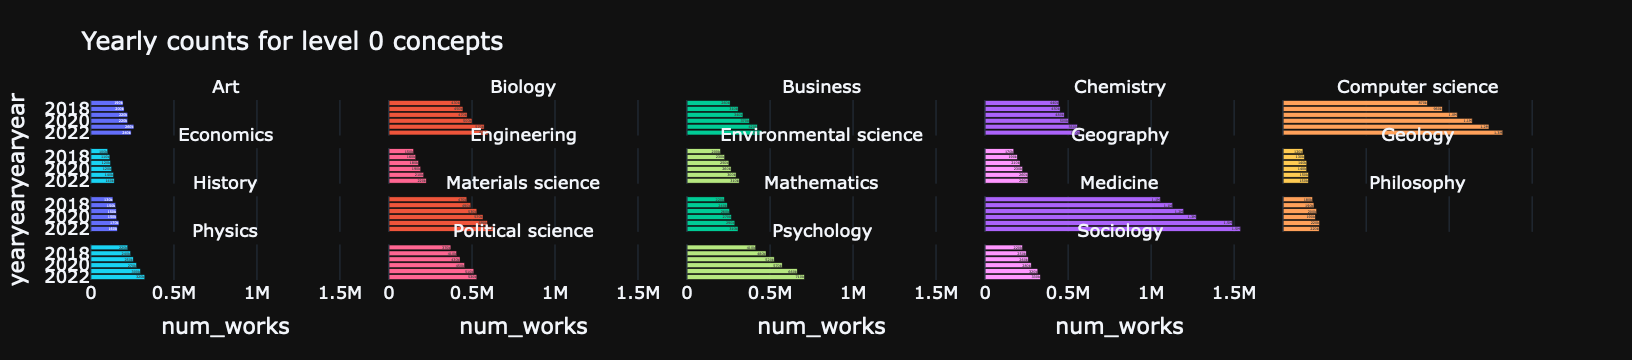

In [58]:
fig = (
    concept_monthly_counts_agg_filt
    .reset_index()
    .groupby(['concept_id', pd.Grouper(key='publication_date', freq='12M')])
    .agg(
        concept_name=('concept_name', 'first'),
        num_works=('num_works', 'sum'),
    )
    .reset_index()
    .assign(
        year=lambda df_: df_.publication_date.dt.year,
        concept_name=lambda df_: df_.concept_name.astype('string'),
    )
    .query('year.between(2017, 2022)')
    .sort_values(by=['concept_name'])
    .plot
    .barh
    (
        y='year', x='num_works', color='concept_name',
        text_auto='.2s',
        facet_col='concept_name', facet_col_wrap=5,
        title=f'Yearly counts for level 0 concepts',
        height=1000,
    )
)

fig.update_yaxes(autorange='reversed')
# fig.update_xaxes(matches=None)
fig.update_layout(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
fig

In [114]:
# topic = 'COVID'
# topic = 'DL_ML'
# topic = 'QED'
# topic = 'H1N1'
topic = 'MERS'

csv_path = Path(f'./csvs/aug-2023/monthly_stats/combined/{topic}_author_classes.csv')

topic_work_types = pd.read_csv(csv_path, index_col='work_id', parse_dates=['date'])
topic_work_types.head(2)

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
2094023848            3              0              0            2   
1791339883            4              0              2            2   

            num_repeats  num_bellwethers  month_idx topic       date  \
work_id                                                                
2094023848            0                0          1  MERS 2012-01-31   
1791339883            0                0          1  MERS 2012-01-31   

            frac_expert  class_  
work_id                          
2094023848     0.666667  51-75%  
1791339883     0.500000  26-50%

In [115]:
## assign new classes combining 1-25 & 26-50, 51-75 & 76-99
new_map = {'0%': '0%', '1-25%': '1-50%', '26-50%': '1-50%', '51-75%': '51-99%', '76-99%': '51-99%', '100%': '100%'}
topic_work_types = (
    topic_work_types
    .assign(
        class_new=lambda df_: df_.class_.map(new_map)
    )
)
topic_work_types

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
2094023848            3              0              0            2   
1791339883            4              0              2            2   
2024845528           10              0              0            5   
2002977421            5              1              0            4   
2056678207            5              1              2            2   
...                 ...            ...            ...          ...   
2070427295            4              3              0            1   
2093099025           12              1              5            6   
2024016980           14              1              3            6   
1987638400            3              0              0            2   
1988165397            7              0              3            1   

            num_repeats  num_bellwethers  month_idx topic       date  \
work_id                                                                
2094023848            0                0          1  MERS 2012-01-31   
1791339883            0                0          1  MERS 2012-01-31   
2024845528            0                0          1  MERS 2012-01-31   
2002977421            0                0          1  MERS 2012-01-31   
2056678207            0                0          1  MERS 2012-01-31   
...                 ...              ...        ...   ...        ...   
2070427295            0                0         36  MERS 2014-12-31   
2093099025           10                0         36  MERS 2014-12-31   
2024016980            5                0         36  MERS 2014-12-31   
1987638400            2                0         36  MERS 2014-12-31   
1988165397            0                0         36  MERS 2014-12-31   

            frac_expert  class_ class_new  
work_id                                    
2094023848     0.666667  51-75%    51-99%  
1791339883     0.500000  26-50%     1-50%  
2024845528     0.500000  26-50%     1-50%  
2002977421     0.800000  76-99%    51-99%  
2056678207     0.400000  26-50%     1-50%  
...                 ...     ...       ...  
2070427295     0.250000   1-25%     1-50%  
2093099025     0.500000  26-50%     1-50%  
2024016980     0.428571  26-50%     1-50%  
1987638400     0.666667  51-75%    51-99%  
1988165397     0.142857   1-25%     1-50%  

[966 rows x 12 columns]

In [116]:
topic_work_types = (
    topic_work_types
    .join([
        works_references
        .groupby('work_id', sort=False)
        .referenced_work_id
        .count()
        .rename('num_refs'),
        works_references
        .groupby('referenced_work_id', sort=False)
        .work_id
        .count()
        .rename('num_cites'),
    ])
    .assign(
        num_refs=lambda df_: df_.num_refs.fillna(0).astype('int'),
        num_cites=lambda df_: df_.num_cites.fillna(0).astype('int'),
    )
)
topic_work_types

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
2094023848          3.0            0.0            0.0          2.0   
1791339883          4.0            0.0            2.0          2.0   
2024845528         10.0            0.0            0.0          5.0   
2002977421          5.0            1.0            0.0          4.0   
2056678207          5.0            1.0            2.0          2.0   
...                 ...            ...            ...          ...   
2070427295          4.0            3.0            0.0          1.0   
2093099025         12.0            1.0            5.0          6.0   
2024016980         14.0            1.0            3.0          6.0   
1987638400          3.0            0.0            0.0          2.0   
1988165397          7.0            0.0            3.0          1.0   

            num_repeats  num_bellwethers  month_idx topic       date  \
work_id                                                                
2094023848          0.0              0.0        1.0  MERS 2012-01-31   
1791339883          0.0              0.0        1.0  MERS 2012-01-31   
2024845528          0.0              0.0        1.0  MERS 2012-01-31   
2002977421          0.0              0.0        1.0  MERS 2012-01-31   
2056678207          0.0              0.0        1.0  MERS 2012-01-31   
...                 ...              ...        ...   ...        ...   
2070427295          0.0              0.0       36.0  MERS 2014-12-31   
2093099025         10.0              0.0       36.0  MERS 2014-12-31   
2024016980          5.0              0.0       36.0  MERS 2014-12-31   
1987638400          2.0              0.0       36.0  MERS 2014-12-31   
1988165397          0.0              0.0       36.0  MERS 2014-12-31   

            frac_expert  class_ class_new  num_refs  num_cites  
work_id                                                         
2094023848     0.666667  51-75%    51-99%        16        486  
1791339883     0.500000  26-50%     1-50%         2          2  
2024845528     0.500000  26-50%     1-50%         9         12  
2002977421     0.800000  76-99%    51-99%         8         18  
2056678207     0.400000  26-50%     1-50%         8         13  
...                 ...     ...       ...       ...        ...  
2070427295     0.250000   1-25%     1-50%        11          2  
2093099025     0.500000  26-50%     1-50%        12        231  
2024016980     0.428571  26-50%     1-50%        22         99  
1987638400     0.666667  51-75%    51-99%        30         38  
1988165397     0.142857   1-25%     1-50%        12         54  

[966 rows x 14 columns]

In [117]:
refs_count = (
    pd.concat([
    topic_work_types
    .num_refs
    .value_counts(normalize=False),
    topic_work_types
    .num_refs
    .value_counts(normalize=True)
    ], axis=1)
    .sort_index()
)
refs_count

count  proportion
num_refs                   
0           126    0.130435
1            22    0.022774
2            18    0.018634
3            23    0.023810
4            29    0.030021
...         ...         ...
88            1    0.001035
91            1    0.001035
92            1    0.001035
120           1    0.001035
123           1    0.001035

[70 rows x 2 columns]

In [118]:
(
    topic_work_types
    .query('num_refs==2856')
)

Empty DataFrame
Columns: [num_authors, num_newcomers, num_neophytes, num_experts, num_repeats, num_bellwethers, month_idx, topic, date, frac_expert, class_, class_new, num_refs, num_cites]
Index: []

In [119]:
cites_count = (
    pd.concat([
    topic_work_types
    .num_cites
    .value_counts(normalize=False),
    topic_work_types
    .num_cites
    .value_counts(normalize=True)
    ], axis=1)
    .sort_index()
)
cites_count

count  proportion
num_cites                   
0            104    0.107660
1             31    0.032091
2             26    0.026915
3             15    0.015528
4             12    0.012422
...          ...         ...
1098           1    0.001035
1118           1    0.001035
1313           1    0.001035
1580           1    0.001035
4283           1    0.001035

[261 rows x 2 columns]

In [120]:
(
    pd.concat([
        topic_work_types
        .query('num_refs==0')
        .class_new
        .value_counts(normalize=False),
        topic_work_types
        .query('num_refs==0')
        .class_new
        .value_counts(normalize=True),
    ], axis=1)
    # .loc[['0%', '1-25%', '26-50%', '51-75%', '76-99%', '100%']]
)

count  proportion
class_new                   
1-50%         46    0.365079
51-99%        32    0.253968
0%            28    0.222222
100%          20    0.158730

In [121]:
topic_cite_stats = (
    pd.concat([
        topic_work_types
        .groupby('class_new')
        .num_cites
        .count()
        .rename('total_works'),
        topic_work_types
        .query('num_refs==0')
        .groupby('class_new')
        .num_cites
        .count()
        .rename('works_missing_refs'),
        topic_work_types
        .groupby('class_new')
        .num_cites
        .median()
        .rename('median_citations'),
        topic_work_types
        .groupby('class_new')
        .num_cites
        .mean()
        .rename('mean_citations'),
        topic_work_types
        .groupby('class_new')
        .num_cites
        .std()
        .rename('std_citations'),
    ], axis=1)
    .round(3)
    .assign(
        works_perc=lambda df_: df_.total_works.div(topic_work_types.shape[0]).apply(lambda x: f'{x:.2%}'),
        missing_perc=lambda df_: df_.works_missing_refs.div(df_.total_works).apply(lambda x: f'{x:.2%}'),
        topic=topic,
    )
    [['topic', 'total_works', 'works_perc', 'works_missing_refs', 'missing_perc', 'median_citations', 'mean_citations', 'std_citations']]
    .loc[['0%', '1-50%', '51-99%', '100%']]
)

display(topic_cite_stats)

(
    topic_cite_stats
    .to_csv(f'./csvs/aug-2023/{topic}_work_types_cites.csv')
)

topic  total_works works_perc  works_missing_refs missing_perc  \
class_new                                                                  
0%         MERS           86      8.90%                  28       32.56%   
1-50%      MERS          519     53.73%                  46        8.86%   
51-99%     MERS          269     27.85%                  32       11.90%   
100%       MERS           92      9.52%                  20       21.74%   

           median_citations  mean_citations  std_citations  
class_new                                                   
0%                      4.0          25.163         47.294  
1-50%                  34.0          88.676        149.140  
51-99%                 47.0         118.283        302.043  
100%                   16.5          50.478         83.950

In [74]:
(
    topic_work_types
    .sort_values(by='num_cites', ascending=False)
)

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3001897055         18.0            0.0            2.0         16.0   
3004280078         29.0            6.0            5.0         18.0   
3009912996         13.0            1.0            4.0          8.0   
3008028633          2.0            0.0            0.0          2.0   
3111255098         29.0            2.0           16.0         11.0   
...                 ...            ...            ...          ...   
3172769202          4.0            0.0            4.0          0.0   
3137222847          3.0            0.0            3.0          0.0   
4206633927         10.0            0.0            3.0          7.0   
4206912813          3.0            1.0            1.0          1.0   
4280527398          3.0            0.0            1.0          2.0   

            num_repeats  num_bellwethers  month_idx  topic        date  \
work_id                                                                  
3001897055          7.0              0.0        2.0  COVID  2020-02-29   
3004280078         15.0              0.0        2.0  COVID  2020-02-29   
3009912996          4.0              0.0        4.0  COVID  2020-04-30   
3008028633          0.0              0.0        4.0  COVID  2020-04-30   
3111255098         19.0              0.0       12.0  COVID  2020-12-31   
...                 ...              ...        ...    ...         ...   
3172769202          0.0              0.0       15.0  COVID  2021-03-31   
3137222847          2.0              0.0       15.0  COVID  2021-03-31   
4206633927          9.0              0.0       25.0  COVID  2022-01-31   
4206912813          0.0              0.0       25.0  COVID  2022-01-31   
4280527398          3.0              0.0       28.0  COVID  2022-04-30   

            frac_expert  class_  num_refs  num_cites class_new  
work_id                                                         
3001897055     0.888889  76-99%        10      19036    51-99%  
3004280078     0.620690  51-75%        10      14901    51-99%  
3009912996     0.615385  51-75%        37      14035    51-99%  
3008028633     1.000000    100%         5      12496      100%  
3111255098     0.379310  26-50%         7       9558     1-50%  
...                 ...     ...       ...        ...       ...  
3172769202     0.000000      0%        22          0        0%  
3137222847     0.000000      0%        22          0        0%  
4206633927     0.700000  51-75%        19          0    51-99%  
4206912813     0.333333  26-50%         0          0     1-50%  
4280527398     0.666667  51-75%         9          0    51-99%  

[454242 rows x 14 columns]

In [123]:
## read all the topics and combine into one table 
topics = ['COVID', 'H1N1', 'MERS', 'DL_ML', 'QED']
dfs = []
for topic in topics:
    dfs.append(
        pd.read_csv(f'./csvs/aug-2023/{topic}_work_types_cites.csv')
        .set_index(['topic', 'class_new'])
    )

combined_stats_df = pd.concat(dfs)
combined_stats_df

total_works works_perc  works_missing_refs missing_perc  \
topic class_new                                                            
COVID 0%              278448     61.30%              131416       47.20%   
      1-50%           146977     32.36%               40952       27.86%   
      51-99%           22588      4.97%                4238       18.76%   
      100%              6229      1.37%                1299       20.85%   
H1N1  0%                 888     16.37%                 276       31.08%   
      1-50%             3042     56.06%                 503       16.54%   
      51-99%            1184     21.82%                 174       14.70%   
      100%               312      5.75%                  71       22.76%   
MERS  0%                  86      8.90%                  28       32.56%   
      1-50%              519     53.73%                  46        8.86%   
      51-99%             269     27.85%                  32       11.90%   
      100%                92      9.52%                  20       21.74%   
DL_ML 0%               16705     20.72%                4476       26.79%   
      1-50%            35678     44.26%                6716       18.82%   
      51-99%           18915     23.47%                2770       14.64%   
      100%              9311     11.55%                1341       14.40%   
QED   0%                1309     10.29%                 394       30.10%   
      1-50%             3468     27.27%                 558       16.09%   
      51-99%            3019     23.74%                 341       11.30%   
      100%              4922     38.70%                 532       10.81%   

                 median_citations  mean_citations  std_citations  
topic class_new                                                   
COVID 0%                      0.0           6.432         32.872  
      1-50%                   2.0          15.861         84.938  
      51-99%                  5.0          34.308        255.943  
      100%                    4.0          33.575        219.928  
H1N1  0%                      6.0          18.568         39.504  
      1-50%                  21.0          44.723         87.407  
      51-99%                 31.0          53.691        102.062  
      100%                   19.0          44.109         91.122  
MERS  0%                      4.0          25.163         47.294  
      1-50%                  34.0          88.676        149.140  
      51-99%                 47.0         118.283        302.043  
      100%                   16.5          50.478         83.950  
DL_ML 0%                      2.0          13.522         49.890  
      1-50%                   4.0          20.303         76.967  
      51-99%                  6.0          31.530        122.963  
      100%                    7.0          55.666        397.056  
QED   0%                      2.0           5.840         11.948  
      1-50%                   4.0          10.069         19.220  
      51-99%                  7.0          13.507         20.106  
      100%                    6.0          12.445         20.579

In [132]:
print(
    combined_stats_df
    .convert_dtypes()
    .to_latex(float_format='%.2f', escape=True)
)

\begin{tabular}{llrlrlrrr}
\toprule
 &  & total\_works & works\_perc & works\_missing\_refs & missing\_perc & median\_citations & mean\_citations & std\_citations \\
topic & class_new &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{COVID} & 0\% & 278448 & 61.30\% & 131416 & 47.20\% & 0.00 & 6.43 & 32.87 \\
 & 1-50\% & 146977 & 32.36\% & 40952 & 27.86\% & 2.00 & 15.86 & 84.94 \\
 & 51-99\% & 22588 & 4.97\% & 4238 & 18.76\% & 5.00 & 34.31 & 255.94 \\
 & 100\% & 6229 & 1.37\% & 1299 & 20.85\% & 4.00 & 33.58 & 219.93 \\
\cline{1-9}
\multirow[t]{4}{*}{H1N1} & 0\% & 888 & 16.37\% & 276 & 31.08\% & 6.00 & 18.57 & 39.50 \\
 & 1-50\% & 3042 & 56.06\% & 503 & 16.54\% & 21.00 & 44.72 & 87.41 \\
 & 51-99\% & 1184 & 21.82\% & 174 & 14.70\% & 31.00 & 53.69 & 102.06 \\
 & 100\% & 312 & 5.75\% & 71 & 22.76\% & 19.00 & 44.11 & 91.12 \\
\cline{1-9}
\multirow[t]{4}{*}{MERS} & 0\% & 86 & 8.90\% & 28 & 32.56\% & 4.00 & 25.16 & 47.29 \\
 & 1-50\% & 519 & 53.73\% & 46 & 8.86\% & 34.00 & 88.68 & 149.14 \\

In [26]:
field_counts_0 = pd.read_csv('./csvs/aug-2023/works_count_0.csv')
field_counts_0

publication_date  works             topic  authors
0          2015-01-31  37717  Computer science    92803
1          2015-02-28  51125  Computer science   126040
2          2015-03-31  64019  Computer science   159073
3          2015-04-30  65425  Computer science   159011
4          2015-05-31  68914  Computer science   170887
...               ...    ...               ...      ...
1819       2022-08-31  38012          Business    92896
1820       2022-09-30  39070          Business    97503
1821       2022-10-31  37946          Business    94783
1822       2022-11-30  37434          Business    94447
1823       2022-12-31  51643          Business   126211

[1824 rows x 4 columns]

In [63]:
bell_origin = pd.read_csv('./csvs/aug-2023/count_bellwethers_ew_0.csv', index_col=0)
bell_origin

concept_id  author_id           concept_name      perc
5     71924100     473911               Medicine  0.699448
4     41008148     249156       Computer science  0.367731
0     15744967     228880             Psychology  0.337805
6     86803240     213229                Biology  0.314706
16   185592680     176585              Chemistry  0.260623
14   144133560     137519               Business  0.202965
1     17744445     110449      Political science  0.163012
17   192562407     100572      Materials science  0.148435
18   205649164      85111              Geography  0.125616
2     33923547      82784            Mathematics  0.122181
3     39432304      82474  Environmental science  0.121724
13   144024400      74613              Sociology  0.110122
8    121332964      71697                Physics  0.105818
10   127413603      65813            Engineering  0.097134
15   162324750      49782              Economics  0.073474
9    127313418      35945                Geology  0.053051
11   138885662      32479             Philosophy  0.047936
12   142362112      31921                    Art  0.047112
7     95457728      17369                History  0.025635

In [70]:
(
    bell_origin
    .assign(
        log_perc=lambda df_: np.log2(df_.perc),
        perc_log_perc=lambda df_: df_.perc.mul(df_.log_perc),
    )
    .perc_log_perc
    .mul(-1)
    .sum()
)

6.944170365881666

In [62]:
expert_origin = pd.read_csv('./csvs/aug-2023/count_experts_ew_0.csv', index_col=0)
expert_origin

concept_id  author_id           concept_name      perc
5     71924100     309819               Medicine  0.922924
6     86803240     167605                Biology  0.499281
0     15744967      88989             Psychology  0.265090
4     41008148      88931       Computer science  0.264918
16   185592680      83255              Chemistry  0.248009
18   205649164      78916              Geography  0.235084
14   144133560      50932               Business  0.151722
1     17744445      40407      Political science  0.120369
3     39432304      38998  Environmental science  0.116172
17   192562407      35751      Materials science  0.106499
2     33923547      31193            Mathematics  0.092921
8    121332964      21379                Physics  0.063686
10   127413603      19363            Engineering  0.057681
13   144024400      15685              Sociology  0.046724
9    127313418      14669                Geology  0.043698
15   162324750      11936              Economics  0.035556
11   138885662      10290             Philosophy  0.030653
12   142362112       9755                    Art  0.029059
7     95457728       7516                History  0.022390

In [71]:
(
    expert_origin
    .assign(
        log_perc=lambda df_: np.log2(df_.perc),
        perc_log_perc=lambda df_: df_.perc.mul(df_.log_perc),
    )
    .perc_log_perc
    .mul(-1)
    .sum()
)

5.906930829971921

In [60]:
combined_frac = (
    expert_origin
    [['concept_name', 'perc']]
    .rename(columns={'perc': 'expert_perc'})
    .join(
        bell_origin
        [['perc']]
        .rename(columns=lambda c: 'bell_' + c)
    )
    .sort_values(by='expert_perc', ascending=False)
)
combined_frac

concept_name  expert_perc  bell_perc
concept_id                                               
71924100                 Medicine     0.922924   0.699448
86803240                  Biology     0.499281   0.314706
15744967               Psychology     0.265090   0.337805
41008148         Computer science     0.264918   0.367731
185592680               Chemistry     0.248009   0.260623
205649164               Geography     0.235084   0.125616
144133560                Business     0.151722   0.202965
17744445        Political science     0.120369   0.163012
39432304    Environmental science     0.116172   0.121724
192562407       Materials science     0.106499   0.148435
33923547              Mathematics     0.092921   0.122181
121332964                 Physics     0.063686   0.105818
127413603             Engineering     0.057681   0.097134
144024400               Sociology     0.046724   0.110122
127313418                 Geology     0.043698   0.053051
162324750               Economics     0.035556   0.073474
138885662              Philosophy     0.030653   0.047936
142362112                     Art     0.029059   0.047112
95457728                  History     0.022390   0.025635

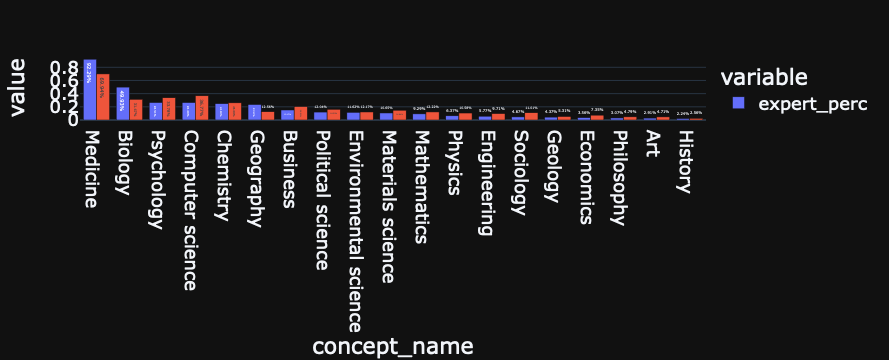

In [61]:
fig = (
    combined_frac
    # .iloc[:10]
    .plot
    .bar(
        x='concept_name', y=['expert_perc', 'bell_perc'], barmode='group',
        height=500, text_auto='.2%',
    )
)

# fig.update_yaxes(autorange='reversed', title='')
# fig.update_layout(showlegend=False)
fig

In [4]:
topic = 'COVID'
# topic = 'H1N1'
# topic = 'MERS'
# topic = 'DL_ML'

topic_subslice_path = Path('/N/project/openalex/slices/subslices/') / topic
topic_subslice_path.mkdir(exist_ok=True, parents=True)

topic_ids, topic_ids_exp, start_date_tw, end_date_tw, start_date_ow, end_date_ow = get_topic_info(topic=topic)

# works = read_parquet(topic_subslice_path / 'works')
works_authors = (
    read_parquet(topic_subslice_path / 'works_authorships')
    .drop_duplicates(subset=['work_id', 'author_id'])
)
works_concepts = read_parquet(topic_subslice_path / 'works_concepts')

'COVID' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31

Reading 'works_authorships' using engine='fastparquet'
Read 186,352,020 rows from 'works_authorships' in 14.89 sec.
Converting dtypes took 0.69 sec. Size before: 5.90GB, after: 5.90GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632322               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01


Reading 'works_concepts' using engine='fastparquet'
Read 288,800,828 rows from 'works_concepts' in 11.47 sec.
Converting dtypes took 1.93 sec. Size before: 8.07GB, after: 7.53GB


work_id  concept_id     score  publication_year
__null_dask_index__                                                   
463354               406922932   137620995  0.907227              2015
463355               406922932   161879069  0.680176              2015
463356               406922932    86554907  0.658203              2015

In [23]:
csv_path = Path(f'./csvs/aug-2023/monthly_stats/combined/{topic}_author_classes.csv')

topic_work_types = pd.read_csv(csv_path, index_col='work_id', parse_dates=['date'])
topic_work_types.head(2)

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3138825726           16              0              6            6   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx  topic       date  \
work_id                                                                 
3138825726            0                0          1  COVID 2020-01-31   
3148418013            0                0          1  COVID 2020-01-31   

            frac_expert  class_  
work_id                          
3138825726     0.375000  26-50%  
3148418013     0.666667  51-75%

In [24]:
## shuffle the topic works authors only 
topic_works_authors = (
    works_authors
    [works_authors.work_id.isin(set(topic_work_types.index))]
    .assign(topic=topic)
)
topic_works_authors

work_id   author_id  publication_year  \
__null_dask_index__                                             
924882               3136058742  5047805950              2021   
924884               3136058742  5050824232              2021   
665748               3133988071  5084949171              2021   
665751               3133988071  5041462949              2021   
665753               3133988071  5027244469              2021   
...                         ...         ...               ...   
104172               4220969349  5091868146              2022   
104173               4220969349  5068633122              2022   
104174               4220969349  5037651515              2022   
104175               4220969349  5058259325              2022   
104176               4220969349  5007965601              2022   

                    publication_date  topic  
__null_dask_index__                          
924882                    2021-04-01  COVID  
924884                    2021-04-01  COVID  
665748                    2021-03-10  COVID  
665751                    2021-03-10  COVID  
665753                    2021-03-10  COVID  
...                              ...    ...  
104172                    2022-03-06  COVID  
104173                    2022-03-06  COVID  
104174                    2022-03-06  COVID  
104175                    2022-03-06  COVID  
104176                    2022-03-06  COVID  

[2540070 rows x 5 columns]

In [202]:
max_tries = 5 if topic == 'COVID' else 50
trials = 100
shuffled_topic_works_authors_combined = shuffle_works_authors(
    topic=topic, topic_works_authors=topic_works_authors,
    trials=trials, max_tries=max_tries,
)
shuffled_topic_works_authors_combined

Shuffling 338,323 authorships:   0%|          | 0/100 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

Tries:   0%|          | 0/50 [00:00<?, ?it/s]

[                        work_id   author_id  topic  trial
 __null_dask_index__                                      
 1600008              2803978022  5065398968  DL_ML      1
 1600009              2803978022  5011604061  DL_ML      1
 1600010              2803978022  5007681919  DL_ML      1
 1600011              2803978022  5011266256  DL_ML      1
 1600012              2803978022  5078159397  DL_ML      1
 ...                         ...         ...    ...    ...
 1102501              3106436761  5015489015  DL_ML      1
 1102502              3106436761  5002166511  DL_ML      1
 1102503              3106436761  5055069629  DL_ML      1
 1102504              3106436761  5011373647  DL_ML      1
 1102505              3106436761  5026315315  DL_ML      1
 
 [338317 rows x 4 columns],
                         work_id   author_id  topic  trial
 __null_dask_index__                                      
 1600008              2803978022  5027060423  DL_ML      2
 1600009              2803

In [203]:
dump_pickle(obj=shuffled_topic_works_authors_combined, path=Path(f'./pickles/{topic}_shuffled.pkl'))

Pickle saved at 'pickles/DL_ML_shuffled.pkl'


### litcovid 

In [52]:
pd.__version__

'2.1.1'

In [8]:
litcovid_monthly_stats = pd.read_csv('./csvs/aug-2023/monthly_stats/litcovid/COVID_author_classes.csv')
litcovid_monthly_stats

work_id  num_authors  num_newcomers  num_neophytes  num_experts  \
0       3015471205            5              0              2            3   
1       3035348393           12              0              2           10   
2       2999364275            8              0              7            1   
3       3088955122           13              2             11            0   
4       3022376678            3              0              3            0   
...            ...          ...            ...            ...          ...   
275993  4304780046            5              1              4            0   
275994  4282601442            8              2              5            1   
275995  4281729287            6              2              4            0   
275996  4225293105            8              3              3            2   
275997  4223625048           10              0              6            4   

        num_repeats  num_bellwethers  month_idx  topic        date  \
0                 0                0          1  COVID  2020-01-31   
1                 0                0          1  COVID  2020-01-31   
2                 0                0          1  COVID  2020-01-31   
3                 0                0          1  COVID  2020-01-31   
4                 0                0          1  COVID  2020-01-31   
...             ...              ...        ...    ...         ...   
275993            3                0         36  COVID  2022-12-31   
275994            4                0         36  COVID  2022-12-31   
275995            0                0         36  COVID  2022-12-31   
275996            5                0         36  COVID  2022-12-31   
275997            9                0         36  COVID  2022-12-31   

        frac_expert  class_  
0          0.600000  51-75%  
1          0.833333  76-99%  
2          0.125000   1-25%  
3          0.000000      0%  
4          0.000000      0%  
...             ...     ...  
275993     0.000000      0%  
275994     0.125000   1-25%  
275995     0.000000      0%  
275996     0.250000   1-25%  
275997     0.400000  26-50%  

[275998 rows x 12 columns]

In [12]:
work_ids = set(litcovid_monthly_stats.work_id)

In [31]:
basepath = Path('/N/project/openalex/slices/subset-2012-2022/cleaned/aug-2023')

works_authors = read_parquet(basepath / 'works_authorships', columns=['work_id', 'author_id', 'publication_date'])
works_concepts = read_parquet(basepath / 'works_concepts', columns=['work_id', 'concept_id', 'score', 'publication_date'])


Reading 'works_authorships' using engine='fastparquet'
Read 270,811,491 rows from 'works_authorships' in 18.39 sec.
Converting dtypes took 1.07 sec. Size before: 8.07GB, after: 8.07GB


work_id   author_id publication_date
__null_dask_index__                                         
308618               1109250102  5029741201       2015-09-01
308619               1109250102  5057065832       2015-09-01
308620               1109250102  5071194099       2015-09-01


Reading 'works_concepts' using engine='fastparquet'
Read 868,770,503 rows from 'works_concepts' in 50.14 sec.
Converting dtypes took 8.39 sec. Size before: 29.13GB, after: 27.51GB


work_id  concept_id     score publication_date
__null_dask_index__                                                  
761812               380057522   545943180  0.692871       2015-09-01
761813               380057522    73555534  0.681641       2015-09-01
761814               380057522   169258074  0.592773       2015-09-01

In [32]:
print(f'Before filtering: {len(works_concepts)=:,}')
works_concepts = (
    works_concepts
    [works_concepts.score>0.3]
)
print(f'After filtering: {len(works_concepts)=:,}')

Before filtering: len(works_concepts)=868,770,503
After filtering: len(works_concepts)=577,030,915


In [33]:
works_concepts = (
    works_concepts
    .assign(
        publication_year=lambda df_: df_.publication_date.dt.year,
    )
)
works_concepts

work_id  concept_id     score publication_date  \
__null_dask_index__                                                      
761812                380057522   545943180  0.692871       2015-09-01   
761813                380057522    73555534  0.681641       2015-09-01   
761814                380057522   169258074  0.592773       2015-09-01   
761815                380057522   107673813  0.499268       2015-09-01   
761816                380057522    83546350  0.475830       2015-09-01   
...                         ...         ...       ...              ...   
1954152              4312394350    94026978  0.645996       2022-08-29   
1954153              4312394350    15708023  0.495850       2022-08-29   
1954154              4312394350    59519942  0.457275       2022-08-29   
1954155              4312394350   121332964  0.433838       2022-08-29   
1954156              4312394350   142362112  0.329346       2022-08-29   

                     publication_year  
__null_dask_index__                    
761812                           2015  
761813                           2015  
761814                           2015  
761815                           2015  
761816                           2015  
...                               ...  
1954152                          2022  
1954153                          2022  
1954154                          2022  
1954155                          2022  
1954156                          2022  

[577030915 rows x 5 columns]

In [34]:
works_authors = (
    works_authors
    .assign(
        publication_year=lambda df_: df_.publication_date.dt.year,
    )
)
works_authors

work_id   author_id publication_date  publication_year
__null_dask_index__                                                           
308618               1109250102  5029741201       2015-09-01              2015
308619               1109250102  5057065832       2015-09-01              2015
308620               1109250102  5071194099       2015-09-01              2015
308621               1109250102  5077748740       2015-09-01              2015
308622               1109250102  5086274702       2015-09-01              2015
...                         ...         ...              ...               ...
2368195              2747626639  5091769615       2017-08-22              2017
2368196              2747626639  5001390657       2017-08-22              2017
2368197              2747626639  5045059584       2017-08-22              2017
2368198              2747626639  5067670085       2017-08-22              2017
2368199              2747626639  5048053140       2017-08-22              2017

[270811491 rows x 4 columns]

In [35]:
litcovid_works = read_parquet('./data/litcovid-openalex-merged_works_aug-2023.parquet')
litcovid_works 


Reading 'litcovid-openalex-merged_works_aug-2023' using engine='fastparquet'
Read 347,861 rows from 'litcovid-openalex-merged_works_aug-2023' in 0.39 sec.
Converting dtypes took 0.56 sec. Size before: 0.18GB, after: 0.18GB


title          type  \
work_id                                                                      
66687513   The Acute Respiratory Distress Syndrome: Diagn...  book-chapter   
219385191  Advances in the Immunobiology of Parasitic Dis...       article   
612496191  A year after lockdowns began, has research got...       article   

          publication_date                           doi  num_authors  \
work_id                                                                 
66687513        2019-04-02  10.1007/978-3-319-94189-9_11            2   
219385191       2022-07-20     10.3390/pathogens11070811            3   
612496191       2021-06-10    10.1038/d41586-021-01579-7            1   

             # pmid                                            title_e  \
work_id                                                                  
66687513   32538594  Acute Respiratory Distress Syndrome: Diagnosis...   
219385191  35890055  Advances in the Immunobiology of Parasitic Dis...   
612496191  34113030  A year after lockdowns began, has research got...   

                    journal  month  day  year  jan_1  
work_id                                               
66687513   Am Fam Physician      4    2  2019  False  
219385191         Pathogens      7   20  2022  False  
612496191            Nature      6   10  2021  False

title          type  \
work_id                                                                       
66687513    The Acute Respiratory Distress Syndrome: Diagn...  book-chapter   
219385191   Advances in the Immunobiology of Parasitic Dis...       article   
612496191   A year after lockdowns began, has research got...       article   
1494388951  Some Dissimilarity Measures of Branching Proce...       article   
1519225998  The 27th Annual Prostate Cancer Foundation Sci...       article   
...                                                       ...           ...   
4385264694  Preoperative universal screening of coronaviru...       article   
4385264699  The impact of restricted access on the need an...       article   
4385264717  Risk of ischemic stroke in patients recovered ...       article   
4385264721  Unravelling disparity in age-specific acceptan...       article   
4385264872  Cholinergic α7 nAChR signaling suppresses SARS...       article   

           publication_date                            doi  num_authors  \
work_id                                                                   
66687513         2019-04-02   10.1007/978-3-319-94189-9_11            2   
219385191        2022-07-20      10.3390/pathogens11070811            3   
612496191        2021-06-10     10.1038/d41586-021-01579-7            1   
1494388951       2020-08-08              10.3390/e22080874            2   
1519225998       2021-09-01             10.1002/pros.24211            2   
...                     ...                            ...          ...   
4385264694       2023-07-26      10.4103/sjopt.sjopt_94_22            2   
4385264699       2023-07-25        10.1922/cdh_00122keat07            2   
4385264717       2023-07-25      10.1177/23969873231190432            5   
4385264721       2023-07-25  10.1080/08870446.2023.2239279            7   
4385264872       2023-07-25           10.1093/jmcb/mjad048            5   

              # pmid                                            title_e  \
work_id                                                                   
66687513    32538594  Acute Respiratory Distress Syndrome: Diagnosis...   
219385191   35890055  Advances in the Immunobiology of Parasitic Dis...   
612496191   34113030  A year after lockdowns began, has research got...   
1494388951  33286645  Some Dissimilarity Measures of Branching Proce...   
1519225998  34469608  The 27th Annual Prostate Cancer Foundation Sci...   
...              ...                                                ...   
4385264694  37492210  Preoperative universal screening of coronaviru...   
4385264699  37490397  The impact of restricted access on the need an...   
4385264717  37491810  Risk of ischemic stroke in patients recovered ...   
4385264721  37491766  Unravelling disparity in age-specific acceptan...   
4385264872  37491690  Cholinergic alpha7 nAChR signaling suppresses ...   

                          journal  month  day  year  jan_1  
work_id                                                     
66687513         Am Fam Physician      4    2  2019  False  
219385191               Pathogens      7   20  2022  False  
612496191                  Nature      6   10  2021  False  
1494388951        Entropy (Basel)      8    8  2020  False  
1519225998               Prostate      9    1  2021  False  
...                           ...    ...  ...   ...    ...  
4385264694     Saudi J Ophthalmol      7   26  2023  False  
4385264699  Community Dent Health      7   25  2023  False  
4385264717           Eur Stroke J      7   25  2023  False  
4385264721         Psychol Health      7   25  2023  False  
4385264872        J Mol Cell Biol      7   25  2023  False  

[347861 rows x 12 columns]

title          type  \
work_id                                                                       
66687513    The Acute Respiratory Distress Syndrome: Diagn...  book-chapter   
2162860860  Australian Rotavirus Surveillance Program: Ann...       article   
2514714056  Creutzfeldt–Jakob disease surveillance in Aust...       article   
2915009278  Unexpected Receptor Functional Mimicry Elucida...       article   
2922895732  Enterovirus D68–Associated Acute Respiratory I...       article   
2927490637  Surveillance to Track Progress Toward Polio Er...       article   
2947270978  Structure of the SARS-Unique Domain C From the...       article   
2989566063  Fiebre amarilla selvática con serología positi...       article   
2997681113  Investigation of the Role of the Spike Protein...       article   
3008060807  Coronaviruses: a paradigm of new emerging zoon...       article   
3014358130  When there is a pandemic there is no time to w...       article   
3014426942                     COVID-19 Outbreak: An Overview       article   
3015065773  How we treat patients with lung cancer during ...       article   
3024552035  How we treat patients with lung cancer during ...       article   
3025091173  How we treat patients with brain tumour during...       article   
3025114626                                   Reply to Authors       article   
3026134707  International-focused Online Forum: A Good Way...       article   
3026277447  Could fighting airborne transmission be the ne...       article   
3026416722  Training and Delivery of Critical Care Medicin...       article   
3032337545  Combination Antiviral Therapy with Lopinavir/R...       article   
3033139203  The COVID-19 experiment: Pandemic planning and...       article   
3036351692  Olfactory and gustatory dysfunctions in COVID-...       article   
3037726498  Article Commentary: SARS-CoV-2 and HIV Proteas...       article   
3043345278  Potential role of Bacillus Calmette-Guérin (BC...       article   
3046816509  Evaluation of drugs for Potential Repurposing ...       article   
3047391970  Clinical protocols in dental practice: Post-CO...       article   
3093987090  COVID-19 in children: Heterogeneity within the...       article   
3124774163  Early Low-Molecular-Weight Heparin Administrat...       article   
3129975390                 COVID-19 and Hepatitis B Infection       article   
3135162607  The Protease Inhibitor Lopinavir, Boosted with...       article   
3154519666  COVID-19 y sus imaginarios socioculturales en ...       article   
3212713008  COVID-19 Infection Associated with Psychosis i...       article   
4239394407  Critical Care for COVID-19 Affected Patients: ...       article   
4383058376  A Chinese herb prescription &amp;#x0201c;&lt;e...       article   

           publication_date                              doi  num_authors  \
work_id                                                                     
66687513         2019-04-02     10.1007/978-3-319-94189-9_11            2   
2162860860       2019-07-16          10.33321/cdi.2019.43.28            3   
2514714056       2019-07-16          10.33321/cdi.2019.43.32           10   
2915009278       2019-02-01       10.1016/j.cell.2018.12.028           14   
2922895732       2019-03-29           10.15585/mmwr.mm6812a1           27   
2927490637       2019-04-05           10.15585/mmwr.mm6813a4            8   
2947270978       2019-05-01         10.1177/1934578x19849202            6   
2989566063       2019-12-06    10.17843/rpmesp.2019.364.4347            2   
2997681113       2019-12-30                10.3390/v12010041            2   
3008060807       2019-12-01           10.1093/femspd/ftaa006            4   
3014358130       2019-01-06             10.31138/mjr.31.1.94            5   
3014426942       2019-07-28                10.1159/000507423           10   
3015065773       2019-03-04     10.1136/esmoopen-2020-000765            4   
3024552035       2019-11-03     10.1136/esmoopen-2020-00

In [42]:
topic_work_ids_ow = set(litcovid_monthly_stats.work_id)
print(f'{len(topic_work_ids_ow)=:,}')

topic_work_ids_tw = set(
    litcovid_works
    .query('num_authors.between(2, 30)', engine='python')
    .query('year.between(2019, 2019)')
    .index
)
print(f'{len(topic_work_ids_tw)=:,}')

len(topic_work_ids_ow)=275,998
len(topic_work_ids_tw)=34


In [49]:
topic = 'litCOVID'

In [43]:
data = get_topic_works_and_authors(topic='COVID', works_authors=works_authors, works_concepts=works_concepts,
                                   topic_work_ids_tw=topic_work_ids_tw, topic_work_ids_ow=topic_work_ids_ow)

Using pre-supplied work ids in TW 34
Using pre-supplied work ids in OW 275,998


In [46]:
data['topic'] = 'litCOVID'

In [44]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [52]:
len(data['work_ids_ow']), len(data['experts']), len(data['newcomers'])

(275998, 97833, 273677)

In [53]:
pickle_path = Path('./pickles/') / f'{topic}_agg.pkl'
dump_pickle(obj=data, path=pickle_path)

Pickle saved at 'pickles/litCOVID_agg.pkl'


### other slices

In [28]:
data = get_topic_works_and_authors(topic=topic, works_authors=works_authors, works_concepts=works_concepts)

AttributeError: 'DataFrame' object has no attribute 'publication_year'

In [206]:
len(data['experts']), len(data['newcomers']), len(data['bellwethers'])

(44956, 47513, 77160)

In [21]:
pickle_path = Path('./pickles/') / f'{topic}_agg.pkl'
dump_pickle(obj=data, path=pickle_path)

NameError: name 'data' is not defined

In [208]:
## dump the data pickle to save time 

In [7]:
shuffled_topic_works_authors_combined = load_pickle(f'./pickles/{topic}_shuffled.pkl')
shuffled_topic_works_authors_combined

[                        work_id   author_id  topic  trial
 __null_dask_index__                                      
 924882               3136058742  5087837852  COVID      1
 924884               3136058742  5023226233  COVID      1
 665748               3133988071  5066477109  COVID      1
 665751               3133988071  5082727603  COVID      1
 665753               3133988071  5004381131  COVID      1
 ...                         ...         ...    ...    ...
 104172               4220969349  5005055445  COVID      1
 104173               4220969349  5019134879  COVID      1
 104174               4220969349  5018863416  COVID      1
 104175               4220969349  5008424838  COVID      1
 104176               4220969349  5065607598  COVID      1
 
 [2540055 rows x 4 columns],
                         work_id   author_id  topic  trial
 __null_dask_index__                                      
 924882               3136058742  5024756660  COVID      2
 924884               313

In [8]:
len(shuffled_topic_works_authors_combined)

100

In [9]:
data = load_pickle(f'./pickles/{topic}_agg.pkl')

In [10]:
work_types_list = []
for idx, topic_works_auths in enumerate(tqdm([topic_works_authors] + shuffled_topic_works_authors_combined)):
    work_types_list.append(
        get_topic_work_types(topic=topic, experts=data['experts'], topic_works_authors=topic_works_auths, idx=idx)
    )
combined_work_types = pd.concat(work_types_list)
combined_work_types

NameError: name 'topic_works_authors' is not defined

### <span style='color:teal'>TODO (Sep 21) </span>
* do chi-squared test 
* look at `make_random_baseline_plot` function to see how to deal with samples 
* group by idx, then group by class_new and use value counts
* DL, MERS, H1N1, essentially 0

In [39]:
from scipy.stats import chisquare
import scipy.stats
import pandas as pd

In [340]:
topic

'MERS'

In [14]:
topic = 'COVID'
# topic = 'H1N1'
# topic = 'MERS'
# topic = 'DL_ML'

topic_subslice_path = Path('/N/project/openalex/slices/subslices/') / topic
topic_subslice_path.mkdir(exist_ok=True, parents=True)

topic_ids, topic_ids_exp, start_date_tw, end_date_tw, start_date_ow, end_date_ow = get_topic_info(topic=topic)

works_authors = (
    read_parquet(topic_subslice_path / 'works_authorships')
    .drop_duplicates(subset=['work_id', 'author_id'])
)

csv_path = Path(f'./csvs/aug-2023/monthly_stats/combined/{topic}_author_classes.csv')

topic_work_types = pd.read_csv(csv_path, index_col='work_id', parse_dates=['date'])
display(topic_work_types.head(2))

## shuffle the topic works authors only 
topic_works_authors = (
    works_authors
    [works_authors.work_id.isin(set(topic_work_types.index))]
    .assign(topic=topic)
)
display(topic_works_authors)

'COVID' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31

Reading 'works_authorships' using engine='fastparquet'
Read 186,352,020 rows from 'works_authorships' in 10.66 sec.
Converting dtypes took 0.69 sec. Size before: 5.90GB, after: 5.90GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632322               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx  topic       date  \
work_id                                                                 
3139173904            0                0          1  COVID 2020-01-31   
3148418013            0                0          1  COVID 2020-01-31   

            frac_expert  class_  
work_id                          
3139173904     0.000000      0%  
3148418013     0.666667  51-75%

work_id   author_id  publication_year  \
__null_dask_index__                                             
924882               3136058742  5047805950              2021   
924884               3136058742  5050824232              2021   
665748               3133988071  5084949171              2021   
665751               3133988071  5041462949              2021   
665753               3133988071  5027244469              2021   
...                         ...         ...               ...   
104172               4220969349  5091868146              2022   
104173               4220969349  5068633122              2022   
104174               4220969349  5037651515              2022   
104175               4220969349  5058259325              2022   
104176               4220969349  5007965601              2022   

                    publication_date  topic  
__null_dask_index__                          
924882                    2021-04-01  COVID  
924884                    2021-04-01  COVID  
665748                    2021-03-10  COVID  
665751                    2021-03-10  COVID  
665753                    2021-03-10  COVID  
...                              ...    ...  
104172                    2022-03-06  COVID  
104173                    2022-03-06  COVID  
104174                    2022-03-06  COVID  
104175                    2022-03-06  COVID  
104176                    2022-03-06  COVID  

[2540070 rows x 5 columns]

In [22]:
(
    topic_works_authors
    [['work_id', 'author_id']]
    .nunique()
)

work_id       454242
author_id    1306230
dtype: int64

In [30]:
wt = get_topic_work_types(topic=topic, experts=data['experts'], topic_works_authors=topic_works_authors, idx=0)
display(wt.head())

num_authors  num_experts  frac_expert  class_ class_new  idx
work_id                                                                 
3136058742            2            0     0.000000      0%        0%    0
3133988071           12            2     0.166667   1-25%     1-50%    0
3133183278            2            1     0.500000  26-50%     1-50%    0
3135267962           11            6     0.545455  51-75%    51-99%    0
3134038394            4            0     0.000000      0%        0%    0

In [62]:
(
    wt
    .class_new
    .value_counts()
)

class_new
0%        278448
1-50%     146977
51-99%     22588
100%        6229
Name: count, dtype: int64

In [17]:
(
    topic_work_types
    .assign(
        class_new=lambda df_: df_.class_.map(new_map),
    )
    .class_new
    .value_counts()
)

class_new
0%        278448
1-50%     146977
51-99%     22588
100%        6229
Name: count, dtype: int64

In [12]:
shuffled_topic_works_authors_combined = load_pickle(f'./pickles/{topic}_shuffled.pkl')
data = load_pickle(f'./pickles/{topic}_agg.pkl')

In [27]:
## check if shuffled topic works authors have duplicate rows
(
    shuffled_topic_works_authors_combined[10]
    .duplicated(subset=['work_id', 'author_id'], keep=False)
    .rename('is_dup')
    .to_frame()
    .query('is_dup')
)

Empty DataFrame
Columns: [is_dup]
Index: []

In [31]:
work_types_list = []
for idx, topic_works_auths in enumerate(tqdm([topic_works_authors] + shuffled_topic_works_authors_combined)):
    work_types_list.append(
        get_topic_work_types(topic=topic, experts=data['experts'], topic_works_authors=topic_works_auths, idx=idx)
    )
combined_work_types = (
    pd.concat(work_types_list)
    .assign(topic=topic)
)
combined_work_types

  0%|          | 0/101 [00:00<?, ?it/s]

num_authors  num_experts  frac_expert  class_ class_new  idx  \
work_id                                                                    
3136058742            2            0     0.000000      0%        0%    0   
3133988071           12            2     0.166667   1-25%     1-50%    0   
3133183278            2            1     0.500000  26-50%     1-50%    0   
3135267962           11            6     0.545455  51-75%    51-99%    0   
3134038394            4            0     0.000000      0%        0%    0   
...                 ...          ...          ...     ...       ...  ...   
4225296430            8            1     0.125000   1-25%     1-50%  100   
4214912837            4            1     0.250000   1-25%     1-50%  100   
4214914957            2            0     0.000000      0%        0%  100   
4220714512            9            1     0.111111   1-25%     1-50%  100   
4220969349            8            1     0.125000   1-25%     1-50%  100   

            topic  
work_id            
3136058742  COVID  
3133988071  COVID  
3133183278  COVID  
3135267962  COVID  
3134038394  COVID  
...           ...  
4225296430  COVID  
4214912837  COVID  
4214914957  COVID  
4220714512  COVID  
4220969349  COVID  

[45878442 rows x 7 columns]

In [19]:
combined_work_types = (
    pd.concat(work_types_list)
    .assign(topic=topic)
)
combined_work_types

num_authors  num_experts  frac_expert  class_ class_new  idx  \
work_id                                                                    
3136058742            2            0     0.000000      0%        0%    0   
3133988071           12            2     0.166667   1-25%     1-50%    0   
3133183278            2            1     0.500000  26-50%     1-50%    0   
3135267962           11            6     0.545455  51-75%    51-99%    0   
3134038394            4            0     0.000000      0%        0%    0   
...                 ...          ...          ...     ...       ...  ...   
4225296430            8            0     0.000000      0%        0%   11   
4214912837            4            1     0.250000   1-25%     1-50%   11   
4214914957            2            0     0.000000      0%        0%   11   
4220714512            9            1     0.111111   1-25%     1-50%   11   
4220969349            8            0     0.000000      0%        0%   11   

            topic  
work_id            
3136058742  COVID  
3133988071  COVID  
3133183278  COVID  
3135267962  COVID  
3134038394  COVID  
...           ...  
4225296430  COVID  
4214912837  COVID  
4214914957  COVID  
4220714512  COVID  
4220969349  COVID  

[5450904 rows x 7 columns]

In [20]:
(
    combined_work_types
    .query('idx==0')
    .class_new
    .value_counts()
)

class_new
0%        278448
1-50%     146977
51-99%     22588
100%        6229
Name: count, dtype: int64

In [32]:
combined_counts = (
    pd.concat(work_types_list)
    .groupby('idx')
    .class_new
    .value_counts()
    .reset_index()
    .pivot(
        index='idx', columns='class_new', values='count'
    )
    [['0%', '1-50%', '51-99%', '100%']]
    .assign(topic=topic)
    # .assign(row_sum=lambda df_: df_.sum(axis=1))
)
combined_counts

class_new      0%   1-50%  51-99%  100%  topic
idx                                           
0          278448  146977   22588  6229  COVID
1          195742  245228   10120  3152  COVID
2          196367  244526   10129  3220  COVID
3          196081  244865   10086  3210  COVID
4          195706  245258   10086  3192  COVID
..            ...     ...     ...   ...    ...
96         195652  245285   10116  3189  COVID
97         195902  244902   10240  3198  COVID
98         195734  245049   10181  3278  COVID
99         196012  244966   10124  3140  COVID
100        195667  245173   10107  3295  COVID

[101 rows x 5 columns]

In [33]:
combined_counts.to_csv(f'./csvs/{topic}_shuffled_work_types.csv')

In [26]:
scipy.stats.chisquare(f_obs=combined_counts.iloc[1: , :], f_exp=combined_counts.loc[0], axis=1)

NameError: name 'combined_counts' is not defined

In [356]:
scipy.stats.combine_pvalues(scipy.stats.chisquare(f_obs=combined_counts.iloc[1: , :], f_exp=combined_counts.loc[0], axis=1).pvalue)

/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9690: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


SignificanceResult(statistic=inf, pvalue=0.0)

In [16]:
new_map = {'0%': '0%', '1-25%': '1-50%', '26-50%': '1-50%', '51-75%': '51-99%', '76-99%': '51-99%', '100%': '100%'}

In [55]:
topic = 'COVID'
# topic = 'H1N1'
# topic = 'MERS'
# topic = 'DL_ML'
new_map = {'0%': '0%', '1-25%': '1-50%', '26-50%': '1-50%', '51-75%': '51-99%', '76-99%': '51-99%', '100%': '100%'}

stats_d = {}
for topic in ['COVID', 'H1N1', 'MERS', 'DL_ML', 'litCOVID']:
    topic_subslice_path = Path('/N/project/openalex/slices/subslices/') / topic
    topic_subslice_path.mkdir(exist_ok=True, parents=True)

    # if topic == 'DL':
    #     csv_path = Path(f'./csvs/aug-2023/monthly_stats/combined/DL_ML_author_classes.csv')
    # else:
    if topic == 'litCOVID':
        csv_path = Path(f'./csvs/aug-2023/monthly_stats/litcovid/COVID_author_classes.csv')
    else:
        csv_path = Path(f'./csvs/aug-2023/monthly_stats/combined/{topic}_author_classes.csv')
    
    topic_work_types = (
        pd.read_csv(csv_path, index_col='work_id', parse_dates=['date'])
        .assign(class_new=lambda df_: df_.class_.map(new_map),)
    )
    
    display(topic_work_types.head(2))
    data = load_pickle(f'./pickles/{topic}_agg.pkl')

    stats_d[topic.replace('_ML', '')] = dict(
        experts=len(data['experts']), bellwethers=len(data['bellwethers']), newcomers=len(data['newcomers']),    
    )
    stats_d[topic.replace('_ML', '')].update(topic_work_types.class_new.value_counts().to_dict())

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx  topic       date  \
work_id                                                                 
3139173904            0                0          1  COVID 2020-01-31   
3148418013            0                0          1  COVID 2020-01-31   

            frac_expert  class_ class_new  
work_id                                    
3139173904     0.000000      0%        0%  
3148418013     0.666667  51-75%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
2026724029            6              0              0            6   
2052712768            7              1              2            4   

            num_repeats  num_bellwethers  month_idx topic       date  \
work_id                                                                
2026724029            0                0          1  H1N1 2009-01-31   
2052712768            0                0          1  H1N1 2009-01-31   

            frac_expert  class_ class_new  
work_id                                    
2026724029     1.000000    100%      100%  
2052712768     0.571429  51-75%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
2094023848            2              0              0            2   
1791339883            4              0              2            2   

            num_repeats  num_bellwethers  month_idx topic       date  \
work_id                                                                
2094023848            0                0          1  MERS 2012-01-31   
1791339883            0                0          1  MERS 2012-01-31   

            frac_expert  class_ class_new  
work_id                                    
2094023848          1.0    100%      100%  
1791339883          0.5  26-50%     1-50%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
2575630659            3              0              2            1   
2555131074            2              0              1            1   

            num_repeats  num_bellwethers  month_idx  topic       date  \
work_id                                                                 
2575630659            0                0          1  DL_ML 2017-01-31   
2555131074            0                0          1  DL_ML 2017-01-31   

            frac_expert  class_ class_new  
work_id                                    
2575630659     0.333333  26-50%     1-50%  
2555131074     0.500000  26-50%     1-50%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3015471205            5              0              2            3   
3035348393           12              0              2           10   

            num_repeats  num_bellwethers  month_idx  topic       date  \
work_id                                                                 
3015471205            0                0          1  COVID 2020-01-31   
3035348393            0                0          1  COVID 2020-01-31   

            frac_expert  class_ class_new  
work_id                                    
3015471205     0.600000  51-75%    51-99%  
3035348393     0.833333  76-99%    51-99%

In [47]:
topic = 'COVID'
data = load_pickle(f'./pickles/{topic}_agg.pkl')

In [8]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [44]:
new_map = {'0%': '0%', '1-25%': '1-50%', '26-50%': '1-50%', '51-75%': '51-99%', '76-99%': '51-99%', '100%': '100%'}


In [56]:
(
    topic_work_types
    .assign(class_new=lambda df_: df_.class_.map(new_map),)
    .class_new
    .value_counts()
    .to_dict()
)

{'1-50%': 127318, '0%': 124073, '51-99%': 19719, '100%': 4888}

In [57]:
counts = (
    pd.DataFrame(stats_d)
    .T
)
counts

experts  bellwethers  newcomers      0%   1-50%  51-99%  100%
COVID      100736       679424     526070  278448  146977   22588  6229
H1N1         5963        10015       5627    1673    2616     865   272
MERS         1640         1508        850      94     370     353   149
DL          44956        77160      47513   22466   35643   15318  7182
litCOVID    97833       557634     273677  124073  127318   19719  4888

In [51]:
print(
    counts[['0%', '1-50%', '51-99%', '100%']]
    .to_latex()
)

\begin{tabular}{lrrrr}
\toprule
 & 0% & 1-50% & 51-99% & 100% \\
\midrule
COVID & 278448 & 146977 & 22588 & 6229 \\
H1N1 & 1673 & 2616 & 865 & 272 \\
MERS & 94 & 370 & 353 & 149 \\
DL & 22466 & 35643 & 15318 & 7182 \\
\bottomrule
\end{tabular}



In [70]:
counts.to_csv('./csvs/counts.csv')

In [57]:
stats_d['COVID']

{'experts': 100736,
 'bellwethers': 679424,
 'newcomers': 526070,
 '0%': 278448,
 '1-50%': 156424,
 '51-99%': 15533,
 '100%': 3837}

In [68]:
stat, p, dof, expected = scipy.stats.chi2_contingency(counts[['experts', 'bellwethers', 'newcomers']])
critical = scipy.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
 print('Dependent (reject H0)')
else:
 print('Independent (fail to reject H0)')

Dependent (reject H0)


In [69]:
stat, p, dof, expected = scipy.stats.chi2_contingency(counts[['0%', '1-50%', '51-99%', '100%']])
critical = scipy.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
 print('Dependent (reject H0)')
else:
 print('Independent (fail to reject H0)')

Dependent (reject H0)


In [67]:
p

0.0

In [7]:
import pandas as pd 
import scipy.stats 

counts = pd.read_csv('./csvs/counts.csv', index_col=0)
cols1 = ['experts', 'bellwethers', 'newcomers']
cols2 = ['0%', '1-50%', '51-99%', '100%']

prob = 0.95

print(f'Testing for author groups: {cols1}')
stat, p, dof, expected = scipy.stats.chi2_contingency(counts[cols1])
critical = scipy.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print(f'Dependent (reject H0). {stat=} {p=} {dof=} {critical=}')
else:
    print('Independent (fail to reject H0)')

print(f'Testing for work types: {cols2}')
stat, p, dof, expected = scipy.stats.chi2_contingency(counts[cols2])
critical = scipy.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print(f'Dependent (reject H0). {stat=} {p=} {dof=} {critical=}')
else:
    print('Independent (fail to reject H0)')


Testing for author groups: ['experts', 'bellwethers', 'newcomers']
Dependent (reject H0). stat=70758.81666306466 p=0.0 dof=6 critical=12.591587243743977
Testing for work types: ['0%', '1-50%', '51-99%', '100%']
Dependent (reject H0). stat=100772.32093269311 p=0.0 dof=9 critical=16.918977604620448


In [60]:
topic = 'litCOVID'
data = load_pickle(f'./pickles/{topic}_agg.pkl')

In [61]:
works_authors

work_id   author_id publication_date  publication_year
__null_dask_index__                                                           
308618               1109250102  5029741201       2015-09-01              2015
308619               1109250102  5057065832       2015-09-01              2015
308620               1109250102  5071194099       2015-09-01              2015
308621               1109250102  5077748740       2015-09-01              2015
308622               1109250102  5086274702       2015-09-01              2015
...                         ...         ...              ...               ...
2368195              2747626639  5091769615       2017-08-22              2017
2368196              2747626639  5001390657       2017-08-22              2017
2368197              2747626639  5045059584       2017-08-22              2017
2368198              2747626639  5067670085       2017-08-22              2017
2368199              2747626639  5048053140       2017-08-22              2017

[270811491 rows x 4 columns]

In [63]:
litcovid_works_authors_ow = (
    works_authors
    .query('work_id.isin(@topic_work_ids_ow)')
)
litcovid_works_authors_ow

work_id   author_id publication_date  publication_year
__null_dask_index__                                                           
1039300              3139099049  5031425858       2021-03-01              2021
1039301              3139099049  5017501496       2021-03-01              2021
579498               3141264298  5062176815       2021-08-10              2021
579500               3141264298  5025997010       2021-08-10              2021
579501               3141264298  5060467883       2021-08-10              2021
...                         ...         ...              ...               ...
104172               4220969349  5091868146       2022-03-27              2022
104173               4220969349  5068633122       2022-03-27              2022
104174               4220969349  5037651515       2022-03-27              2022
104175               4220969349  5058259325       2022-03-27              2022
104176               4220969349  5007965601       2022-03-27              2022

[1890395 rows x 4 columns]

In [67]:
(
    litcovid_works_authors_ow
    [['work_id', 'author_id']]
            .nunique()
)

work_id      275998
author_id    929144
dtype: int64

In [66]:
for cls in ['experts', 'bellwethers', 'newcomers']:
    
    display(cls, 
        (
            litcovid_works_authors_ow
            [litcovid_works_authors_ow.author_id.isin(data[cls])]
            [['work_id', 'author_id']]
            .nunique()
        )
    )

'experts'

work_id      153074
author_id     97833
dtype: int64

'bellwethers'

work_id      263309
author_id    557634
dtype: int64

'newcomers'

work_id      164406
author_id    273677
dtype: int64

In [54]:
topic = 'COVID_PH'
data = load_pickle(f'./pickles/{topic}_agg.pkl')

In [56]:
topic_subslice_path = Path('/N/project/openalex/slices/subslices/COVID/')
works_authors = (
    read_parquet(topic_subslice_path / 'works_authorships')
    .drop_duplicates(subset=['work_id', 'author_id'])
)
works_authors


Reading 'works_authorships' using engine='fastparquet'
Read 186,352,020 rows from 'works_authorships' in 17.13 sec.
Converting dtypes took 1.14 sec. Size before: 5.90GB, after: 5.90GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632322               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01

work_id   author_id  publication_year publication_date
__null_dask_index__                                                           
632321                979452944  5050381163              2015       2015-10-01
632323                979452944  5079869880              2015       2015-10-01
632324                979452944  5083970693              2015       2015-10-01
632325                979452944  5004714649              2015       2015-10-01
632326                979452944  5020141096              2015       2015-10-01
...                         ...         ...               ...              ...
2084769              1988262182  5086204990              2015       2015-01-07
2084770              1988262182  5082759743              2015       2015-01-07
2084771              1988262182  5014365256              2015       2015-01-07
2084774              1988262182  5008896938              2015       2015-01-07
2084776              1988262182  5085356021              2015       2015-01-07

[157732496 rows x 4 columns]

In [60]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [61]:
topic_work_ids_ow = data['work_ids_ow']

In [62]:
covidph_works_authors_ow = (
    works_authors
    .query('work_id.isin(@topic_work_ids_ow)')
)
covidph_works_authors_ow

work_id   author_id  publication_year publication_date
__null_dask_index__                                                           
924882               3136058742  5047805950              2021       2021-04-01
924884               3136058742  5050824232              2021       2021-04-01
665748               3133988071  5084949171              2021       2021-03-10
665751               3133988071  5041462949              2021       2021-03-10
665753               3133988071  5027244469              2021       2021-03-10
...                         ...         ...               ...              ...
104172               4220969349  5091868146              2022       2022-03-06
104173               4220969349  5068633122              2022       2022-03-06
104174               4220969349  5037651515              2022       2022-03-06
104175               4220969349  5058259325              2022       2022-03-06
104176               4220969349  5007965601              2022       2022-03-06

[2540070 rows x 4 columns]

In [63]:
(
    covidph_works_authors_ow
    [['work_id', 'author_id']]
    .nunique()
)

work_id       454242
author_id    1306230
dtype: int64

In [64]:
for cls in ['experts', 'bellwethers', 'newcomers']:
    display(cls, 
        (
            covidph_works_authors_ow
            [covidph_works_authors_ow.author_id.isin(data[cls])]
            [['work_id', 'author_id']]
            .nunique()
        )
    )

'experts'

work_id      211696
author_id    141889
dtype: int64

'bellwethers'

work_id      397727
author_id    638271
dtype: int64

'newcomers'

work_id      301184
author_id    526070
dtype: int64

In [10]:
from statannotations.Annotator import Annotator
import scipy.stats

In [4]:
topic = 'COVID'

In [5]:
shuffled_work_types_counts = pd.read_csv('./csvs/COVID_shuffled_work_types.csv')
shuffled_work_types_counts

idx      0%   1-50%  51-99%  100%  topic
0      0  278448  146977   22588  6229  COVID
1      1  195742  245228   10120  3152  COVID
2      2  196367  244526   10129  3220  COVID
3      3  196081  244865   10086  3210  COVID
4      4  195706  245258   10086  3192  COVID
..   ...     ...     ...     ...   ...    ...
96    96  195652  245285   10116  3189  COVID
97    97  195902  244902   10240  3198  COVID
98    98  195734  245049   10181  3278  COVID
99    99  196012  244966   10124  3140  COVID
100  100  195667  245173   10107  3295  COVID

[101 rows x 6 columns]

In [ ]:
## aggregate the counts for shuffled data idx > 0

In [6]:
work_types_counts_long = (
    pd.melt(
        shuffled_work_types_counts,
        id_vars=['idx', 'topic'],
        var_name='work_type', 
        value_name='count',
    )
)
work_types_counts_long

idx  topic work_type   count
0      0  COVID        0%  278448
1      1  COVID        0%  195742
2      2  COVID        0%  196367
3      3  COVID        0%  196081
4      4  COVID        0%  195706
..   ...    ...       ...     ...
399   96  COVID      100%    3189
400   97  COVID      100%    3198
401   98  COVID      100%    3278
402   99  COVID      100%    3140
403  100  COVID      100%    3295

[404 rows x 4 columns]

In [ ]:
pd.DataFrame.where()

In [7]:
work_types_counts_long = (
    work_types_counts_long
    .assign(
        type='orig',
    )
    .assign(
        type=lambda df_: df_.type.where(df_.idx==0, other='random'),
    )
)
work_types_counts_long

idx  topic work_type   count    type
0      0  COVID        0%  278448    orig
1      1  COVID        0%  195742  random
2      2  COVID        0%  196367  random
3      3  COVID        0%  196081  random
4      4  COVID        0%  195706  random
..   ...    ...       ...     ...     ...
399   96  COVID      100%    3189  random
400   97  COVID      100%    3198  random
401   98  COVID      100%    3278  random
402   99  COVID      100%    3140  random
403  100  COVID      100%    3295  random

[404 rows x 5 columns]

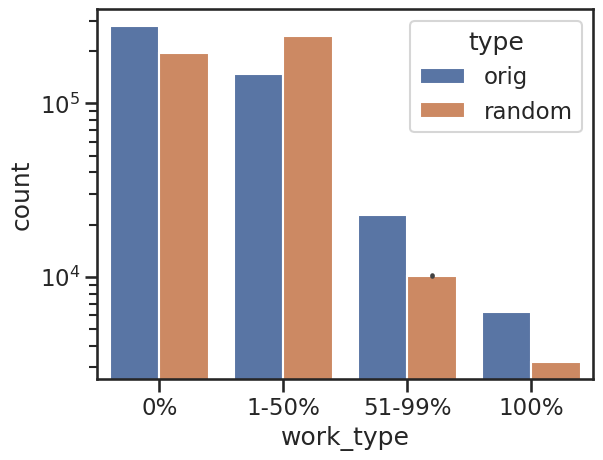

In [19]:
fig, ax = plt.subplots()
sns.barplot(
    data=work_types_counts_long, 
    x='work_type', y='count', hue='type', 
    ax=ax
);
ax.set_yscale('log');
# fig

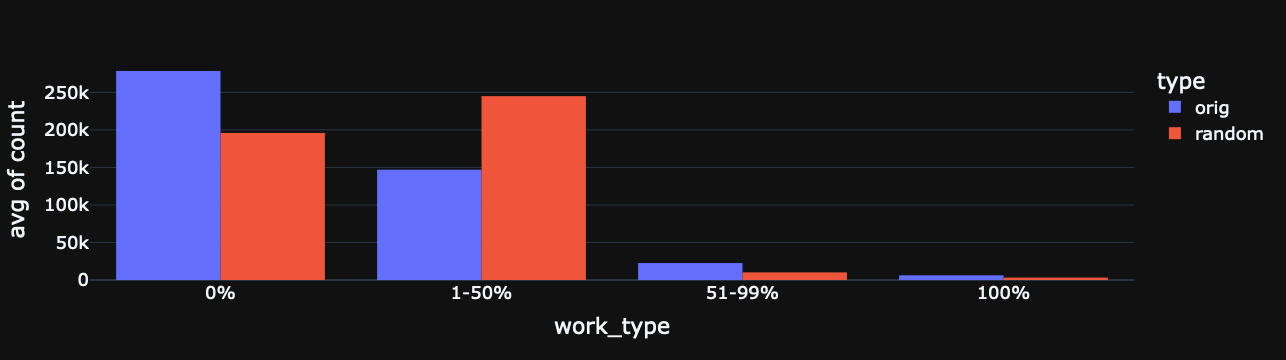

In [25]:
(
    work_types_counts_long
    .plot
    .hist(x='work_type', y='count', color='type', barmode='group', histfunc='avg')
)

In [14]:
key_concepts, expert_concepts, start_date_tw, end_date_tw, start_date_ow, end_date_ow = get_topic_info(topic='COVID')

'COVID' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31


In [7]:
works_ew, works_authors_ew, works_concepts_ew = filter_dataframes_timerange(works, works_authors, 
                                                                            works_concepts, start_date_tw, end_date_tw)

In [8]:
works_ow, works_authors_ow, works_concepts_ow = filter_dataframes_timerange(works, works_authors, 
                                                                            works_concepts, start_date_ow, end_date_ow)

In [9]:
shuffle_rows = False 
ablation = True
shuffles = 100

if ablation:
    csv_path = Path('csvs/aug-2023/monthly_stats/ablation')
else:
    csv_path = Path('csvs/aug-2023/monthly_stats/combined')

csv_path.mkdir(parents=True, exist_ok=True)
# topics = ['COVID', 'COVID_PH', 'DL_ML', 'QED', 'MERS', 'H1N1'][1: ]
topic = 'COVID'
for prior_concept in tqdm(expert_concepts):
    print(f'Prior concept: {prior_concept}')
    # shuffle_rows = True if topic in ['COVID', 'COVID_PH'] else False 
    x, y, z = run_topic(
        topic=f'{topic}_{prior_concept}', shuffle_rows=shuffle_rows, shuffles=shuffles, csv_path=csv_path,
        combine_experts_bellwethers=True,
        works_ew=works_ew, works_authors_ew=works_authors_ew, works_concepts_ew=works_concepts_ew,
        works_ow=works_ow, works_authors_ow=works_authors_ow, works_concepts_ow=works_concepts_ow,
    ) 
                        


  0%|          | 0/4 [00:00<?, ?it/s]

Prior concept: 524204448
'COVID_524204448' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID_524204448' Prior experience topics:
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
len(experts)=325,523
Existing authors: 18,486 at start of OW


  0%|          | 0/36 [00:00<?, ?it/s]

/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),
/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),


topic       date  month_idx  trial  all_works  all_authors  \
0  COVID_524204448 2020-01-31          1      0     240872       910542   
1  COVID_524204448 2020-02-29          2      0     327386      1206960   
2  COVID_524204448 2020-03-31          3      0     391806      1379138   
3  COVID_524204448 2020-04-30          4      0     373978      1327306   
4  COVID_524204448 2020-05-31          5      0     378527      1361877   

   topic_works  topic_authors  topic_newcomers  topic_newcomers_first  \
0         1588           7656             1978                   1978   
1         2173          11378             2340                   2289   
2         4064          19977             3887                   3725   
3         8050          37655             7047                   6671   
4        10950          53411            10392                   9456   

   topic_neophytes  topic_neophytes_first  topic_bellwethers  \
0             4292                   4292                  0   
1             6288                   6038                  0   
2            11241                  10112                  0   
3            22773                  19845                  0   
4            32485                  26195                  0   

   topic_bellwethers_first  topic_experts  topic_experts_first  \
0                        0           1386                 1386   
1                        0           2750                 2436   
2                        0           4849                 3735   
3                        0           7835                 5600   
4                        0          10534                 6655   

   topic_repeat_authors  existing_topic_authors_overall  expert_works  \
0                     0                            7656          1850   
1                   615                           18419          2692   
2                  2405                           35991          3860   
3                  5539                           68107          6215   
4                 11105                          110413          7996   

   expert_authors  
0           10676  
1           15825  
2           21498  
3           31599  
4           41341

work_id  num_authors  num_newcomers  num_neophytes  num_experts  \
0  3139173904            4              1              3            0   
1  3148418013            3              1              0            2   
2  4246625828            3              3              0            0   
3  4212924814            4              0              4            0   
4  3015471205            5              0              2            3   

   num_repeats  num_bellwethers  month_idx            topic       date  \
0            0                0          1  COVID_524204448 2020-01-31   
1            0                0          1  COVID_524204448 2020-01-31   
2            0                0          1  COVID_524204448 2020-01-31   
3            0                0          1  COVID_524204448 2020-01-31   
4            0                0          1  COVID_524204448 2020-01-31   

   frac_expert  class_  
0     0.000000      0%  
1     0.666667  51-75%  
2     0.000000      0%  
3     0.000000      0%  
4     0.600000  51-75%

Empty DataFrame
Columns: []
Index: []

Prior concept: 89623803
'COVID_89623803' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID_89623803' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
len(experts)=327,844
Existing authors: 18,486 at start of OW


  0%|          | 0/36 [00:00<?, ?it/s]

/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),
/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),


topic       date  month_idx  trial  all_works  all_authors  \
0  COVID_89623803 2020-01-31          1      0     240872       910542   
1  COVID_89623803 2020-02-29          2      0     327386      1206960   
2  COVID_89623803 2020-03-31          3      0     391806      1379138   
3  COVID_89623803 2020-04-30          4      0     373978      1327306   
4  COVID_89623803 2020-05-31          5      0     378527      1361877   

   topic_works  topic_authors  topic_newcomers  topic_newcomers_first  \
0         1588           7656             1978                   1978   
1         2173          11378             2340                   2289   
2         4064          19977             3887                   3725   
3         8050          37655             7047                   6671   
4        10950          53411            10392                   9456   

   topic_neophytes  topic_neophytes_first  topic_bellwethers  \
0             4275                   4275                  0   
1             6263                   6014                  0   
2            11190                  10066                  0   
3            22659                  19750                  0   
4            32360                  26104                  0   

   topic_bellwethers_first  topic_experts  topic_experts_first  \
0                        0           1403                 1403   
1                        0           2775                 2460   
2                        0           4900                 3781   
3                        0           7949                 5695   
4                        0          10659                 6746   

   topic_repeat_authors  existing_topic_authors_overall  expert_works  \
0                     0                            7656          1300   
1                   615                           18419          2105   
2                  2405                           35991          2720   
3                  5539                           68107          3347   
4                 11105                          110413          3551   

   expert_authors  
0            8294  
1           13222  
2           16693  
3           19208  
4           20528

work_id  num_authors  num_newcomers  num_neophytes  num_experts  \
0  3139173904            4              1              3            0   
1  3148418013            3              1              0            2   
2  4246625828            3              3              0            0   
3  4212924814            4              0              4            0   
4  3015471205            5              0              2            3   

   num_repeats  num_bellwethers  month_idx           topic       date  \
0            0                0          1  COVID_89623803 2020-01-31   
1            0                0          1  COVID_89623803 2020-01-31   
2            0                0          1  COVID_89623803 2020-01-31   
3            0                0          1  COVID_89623803 2020-01-31   
4            0                0          1  COVID_89623803 2020-01-31   

   frac_expert  class_  
0     0.000000      0%  
1     0.666667  51-75%  
2     0.000000      0%  
3     0.000000      0%  
4     0.600000  51-75%

Empty DataFrame
Columns: []
Index: []

Prior concept: 107130276
'COVID_107130276' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID_107130276' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
len(experts)=120,797
Existing authors: 18,486 at start of OW


  0%|          | 0/36 [00:00<?, ?it/s]

/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),
/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),


topic       date  month_idx  trial  all_works  all_authors  \
0  COVID_107130276 2020-01-31          1      0     240872       910542   
1  COVID_107130276 2020-02-29          2      0     327386      1206960   
2  COVID_107130276 2020-03-31          3      0     391806      1379138   
3  COVID_107130276 2020-04-30          4      0     373978      1327306   
4  COVID_107130276 2020-05-31          5      0     378527      1361877   

   topic_works  topic_authors  topic_newcomers  topic_newcomers_first  \
0         1588           7656             1978                   1978   
1         2173          11378             2340                   2289   
2         4064          19977             3887                   3725   
3         8050          37655             7047                   6671   
4        10950          53411            10392                   9456   

   topic_neophytes  topic_neophytes_first  topic_bellwethers  \
0             4779                   4779                  0   
1             7258                   6947                  0   
2            13040                  11624                  0   
3            26388                  22799                  0   
4            37631                  29869                  0   

   topic_bellwethers_first  topic_experts  topic_experts_first  \
0                        0            899                  899   
1                        0           1780                 1527   
2                        0           3050                 2223   
3                        0           4220                 2646   
4                        0           5388                 2981   

   topic_repeat_authors  existing_topic_authors_overall  expert_works  \
0                     0                            7656          1166   
1                   615                           18419          1636   
2                  2405                           35991          2712   
3                  5539                           68107          5055   
4                 11105                          110413          6769   

   expert_authors  
0            6163  
1            9041  
2           14231  
3           24578  
4           34082

work_id  num_authors  num_newcomers  num_neophytes  num_experts  \
0  3139173904            4              1              3            0   
1  3148418013            3              1              0            2   
2  4246625828            3              3              0            0   
3  4212924814            4              0              4            0   
4  3015471205            5              0              4            1   

   num_repeats  num_bellwethers  month_idx            topic       date  \
0            0                0          1  COVID_107130276 2020-01-31   
1            0                0          1  COVID_107130276 2020-01-31   
2            0                0          1  COVID_107130276 2020-01-31   
3            0                0          1  COVID_107130276 2020-01-31   
4            0                0          1  COVID_107130276 2020-01-31   

   frac_expert  class_  
0     0.000000      0%  
1     0.666667  51-75%  
2     0.000000      0%  
3     0.000000      0%  
4     0.200000   1-25%

Empty DataFrame
Columns: []
Index: []

Prior concept: 116675565
'COVID_116675565' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID_116675565' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31
len(experts)=277,830
Existing authors: 18,486 at start of OW


  0%|          | 0/36 [00:00<?, ?it/s]

/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),
/N/slate/ssikdar/py-temp/openalex/notebooks/covid-newcomers/../notebook_utils.py:468: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date=lambda df_: pd.to_datetime(df_.date, infer_datetime_format=True),


topic       date  month_idx  trial  all_works  all_authors  \
0  COVID_116675565 2020-01-31          1      0     240872       910542   
1  COVID_116675565 2020-02-29          2      0     327386      1206960   
2  COVID_116675565 2020-03-31          3      0     391806      1379138   
3  COVID_116675565 2020-04-30          4      0     373978      1327306   
4  COVID_116675565 2020-05-31          5      0     378527      1361877   

   topic_works  topic_authors  topic_newcomers  topic_newcomers_first  \
0         1588           7656             1978                   1978   
1         2173          11378             2340                   2289   
2         4064          19977             3887                   3725   
3         8050          37655             7047                   6671   
4        10950          53411            10392                   9456   

   topic_neophytes  topic_neophytes_first  topic_bellwethers  \
0             4393                   4393                  0   
1             6498                   6232                  0   
2            11596                  10411                  0   
3            23321                  20266                  0   
4            33249                  26716                  0   

   topic_bellwethers_first  topic_experts  topic_experts_first  \
0                        0           1285                 1285   
1                        0           2540                 2242   
2                        0           4494                 3436   
3                        0           7287                 5179   
4                        0           9770                 6134   

   topic_repeat_authors  existing_topic_authors_overall  expert_works  \
0                     0                            7656          1579   
1                   615                           18419          2265   
2                  2405                           35991          3236   
3                  5539                           68107          5523   
4                 11105                          110413          7386   

   expert_authors  
0            8610  
1           13111  
2           17632  
3           27830  
4           37902

work_id  num_authors  num_newcomers  num_neophytes  num_experts  \
0  3139173904            4              1              3            0   
1  3148418013            3              1              0            2   
2  4246625828            3              3              0            0   
3  4212924814            4              0              4            0   
4  3015471205            5              0              2            3   

   num_repeats  num_bellwethers  month_idx            topic       date  \
0            0                0          1  COVID_116675565 2020-01-31   
1            0                0          1  COVID_116675565 2020-01-31   
2            0                0          1  COVID_116675565 2020-01-31   
3            0                0          1  COVID_116675565 2020-01-31   
4            0                0          1  COVID_116675565 2020-01-31   

   frac_expert  class_  
0     0.000000      0%  
1     0.666667  51-75%  
2     0.000000      0%  
3     0.000000      0%  
4     0.600000  51-75%

Empty DataFrame
Columns: []
Index: []

In [17]:
topic_subslice_path = Path('/N/project/openalex/slices/subslices/') / 'COVID'
topic_works_concepts = (
    read_parquet(topic_subslice_path / 'works_concepts')
    .query('score>0.3')
)

topic_works_authors = (
    read_parquet(topic_subslice_path / 'works_authorships')
    .drop_duplicates(subset=['work_id', 'author_id'])
)


Reading 'works_concepts' using engine='fastparquet'
Read 288,800,828 rows from 'works_concepts' in 10.99 sec.
Converting dtypes took 2.42 sec. Size before: 8.07GB, after: 7.53GB


work_id  concept_id     score  publication_year
__null_dask_index__                                                   
463354               406922932   137620995  0.907227              2015
463355               406922932   161879069  0.680176              2015
463356               406922932    86554907  0.658203              2015


Reading 'works_authorships' using engine='fastparquet'
Read 186,352,020 rows from 'works_authorships' in 13.12 sec.
Converting dtypes took 0.88 sec. Size before: 5.90GB, after: 5.90GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632322               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01

In [19]:
## write data pickle 
for prior_concept in tqdm(list(expert_concepts) + ['PH']):
    print(f'Prior concept: {prior_concept}')
    topic = f'COVID_{prior_concept}'
    data = get_topic_works_and_authors(topic=topic, works_authors=topic_works_authors, works_concepts=topic_works_concepts)
    data['topic'] = topic
    pickle_path = Path('./pickles/') / f'{topic}_agg.pkl'
    print(topic, pickle_path)
    dump_pickle(obj=data, path=pickle_path)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Prior concept: 524204448
COVID_524204448 pickles/COVID_524204448_agg.pkl
Pickle saved at 'pickles/COVID_524204448_agg.pkl'
Prior concept: 89623803
COVID_89623803 pickles/COVID_89623803_agg.pkl
Pickle saved at 'pickles/COVID_89623803_agg.pkl'
Prior concept: 107130276
COVID_107130276 pickles/COVID_107130276_agg.pkl
Pickle saved at 'pickles/COVID_107130276_agg.pkl'
Prior concept: 116675565
COVID_116675565 pickles/COVID_116675565_agg.pkl
Pickle saved at 'pickles/COVID_116675565_agg.pkl'
Prior concept: PH
COVID_PH pickles/COVID_PH_agg.pkl
Pickle saved at 'pickles/COVID_PH_agg.pkl'


In [33]:
topic = 'COVID'

new_map = {'0%': '0%', '1-25%': '1-50%', '26-50%': '1-50%', '51-75%': '51-99%', '76-99%': '51-99%', '100%': '100%'}

stats_d = {}
for topic in tqdm(list(expert_concepts) + ['litCOVID', 'COVID', 'COVID_PH']):
    if topic in ['COVID', 'COVID_PH']:
        csv_path = Path(f'./csvs/aug-2023/monthly_stats/combined/{topic}_author_classes.csv')
    elif topic == 'litCOVID':
        csv_path = Path(f'./csvs/aug-2023/monthly_stats/litcovid/COVID_author_classes.csv')
    else:
        csv_path = Path(f'./csvs/aug-2023/monthly_stats/ablation/COVID_{topic}_author_classes.csv')
        topic = f'COVID_{topic}'
    
    topic_work_types = (
        pd.read_csv(csv_path, index_col='work_id', parse_dates=['date'])
        .assign(class_new=lambda df_: df_.class_.map(new_map),)
    )
    
    display(topic_work_types.head(2))
    data = load_pickle(f'./pickles/{topic}_agg.pkl')

    stats_d[topic] = dict(
        works=len(data['work_ids_ow']), authors=len(data['author_ids_ow']),
        experts=len(data['experts']), bellwethers=len(data['bellwethers']), newcomers=len(data['newcomers']),    
    )
    stats_d[topic].update(topic_work_types.class_new.value_counts().to_dict())

  0%|          | 0/7 [00:00<?, ?it/s]

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx            topic  \
work_id                                                                
3139173904            0                0          1  COVID_524204448   
3148418013            0                0          1  COVID_524204448   

                 date  frac_expert  class_ class_new  
work_id                                               
3139173904 2020-01-31     0.000000      0%        0%  
3148418013 2020-01-31     0.666667  51-75%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx           topic  \
work_id                                                               
3139173904            0                0          1  COVID_89623803   
3148418013            0                0          1  COVID_89623803   

                 date  frac_expert  class_ class_new  
work_id                                               
3139173904 2020-01-31     0.000000      0%        0%  
3148418013 2020-01-31     0.666667  51-75%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx            topic  \
work_id                                                                
3139173904            0                0          1  COVID_107130276   
3148418013            0                0          1  COVID_107130276   

                 date  frac_expert  class_ class_new  
work_id                                               
3139173904 2020-01-31     0.000000      0%        0%  
3148418013 2020-01-31     0.666667  51-75%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx            topic  \
work_id                                                                
3139173904            0                0          1  COVID_116675565   
3148418013            0                0          1  COVID_116675565   

                 date  frac_expert  class_ class_new  
work_id                                               
3139173904 2020-01-31     0.000000      0%        0%  
3148418013 2020-01-31     0.666667  51-75%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3015471205            5              0              2            3   
3035348393           12              0              2           10   

            num_repeats  num_bellwethers  month_idx  topic       date  \
work_id                                                                 
3015471205            0                0          1  COVID 2020-01-31   
3035348393            0                0          1  COVID 2020-01-31   

            frac_expert  class_ class_new  
work_id                                    
3015471205     0.600000  51-75%    51-99%  
3035348393     0.833333  76-99%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx  topic       date  \
work_id                                                                 
3139173904            0                0          1  COVID 2020-01-31   
3148418013            0                0          1  COVID 2020-01-31   

            frac_expert  class_ class_new  
work_id                                    
3139173904     0.000000      0%        0%  
3148418013     0.666667  51-75%    51-99%

num_authors  num_newcomers  num_neophytes  num_experts  \
work_id                                                              
3139173904            4              1              3            0   
3148418013            3              1              0            2   

            num_repeats  num_bellwethers  month_idx     topic       date  \
work_id                                                                    
3139173904            0                0          1  COVID_PH 2020-01-31   
3148418013            0                0          1  COVID_PH 2020-01-31   

            frac_expert  class_ class_new  
work_id                                    
3139173904     0.000000      0%        0%  
3148418013     0.666667  51-75%    51-99%

In [10]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [8]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [34]:
counts = (
    pd.DataFrame(stats_d)
    .T
    .reset_index()
    .rename(columns={'index': 'topic'})
)
counts

topic   works  authors  experts  bellwethers  newcomers      0%  \
0  COVID_524204448  454242  1306230    98029       682131     526070  281029   
1   COVID_89623803  454242  1306230    99208       680952     526070  279664   
2  COVID_107130276  454242  1306230    41243       738917     526070  353149   
3  COVID_116675565  454242  1306230    89291       690869     526070  287603   
4         litCOVID  275998   929144    97833       557634     273677  124073   
5            COVID  454242  1306230   100736       679424     526070  278448   
6         COVID_PH  454242  1306230   141889       638271     526070  242546   

    1-50%  51-99%   100%  
0  145631   21639   5943  
1  146439   22061   6078  
2   89192    9152   2749  
3  142526   18817   5296  
4  127318   19719   4888  
5  146977   22588   6229  
6  166341   34787  10568

In [26]:
_ = get_topic_info('COVID')

'COVID' Core topics
	3006700255, 2019-20 coronavirus outbreak (level 3)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)

'COVID' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31


In [35]:
topic_name_d = dict(
    COVID='COVID', COVID_PH='withPH', 
    COVID_89623803='withoutPandemic',
    COVID_524204448='withoutID',
    COVID_107130276='withoutEpi',
    COVID_116675565='withoutOutbreak',
)

counts = (
    counts
    .replace({'topic': topic_name_d})
)
counts

topic   works  authors  experts  bellwethers  newcomers      0%  \
0        withoutID  454242  1306230    98029       682131     526070  281029   
1  withoutPandemic  454242  1306230    99208       680952     526070  279664   
2       withoutEpi  454242  1306230    41243       738917     526070  353149   
3  withoutOutbreak  454242  1306230    89291       690869     526070  287603   
4         litCOVID  275998   929144    97833       557634     273677  124073   
5            COVID  454242  1306230   100736       679424     526070  278448   
6           withPH  454242  1306230   141889       638271     526070  242546   

    1-50%  51-99%   100%  
0  145631   21639   5943  
1  146439   22061   6078  
2   89192    9152   2749  
3  142526   18817   5296  
4  127318   19719   4888  
5  146977   22588   6229  
6  166341   34787  10568

In [36]:
counts.to_csv('./csvs/covid-ablation.csv', index=False, sep='\t')

In [37]:
counts_long = (
    pd.melt(
        counts,
        id_vars=['topic'],
        value_name='count',
    )
)
counts_long

topic variable   count
0         withoutID    works  454242
1   withoutPandemic    works  454242
2        withoutEpi    works  454242
3   withoutOutbreak    works  454242
4          litCOVID    works  275998
..              ...      ...     ...
58       withoutEpi     100%    2749
59  withoutOutbreak     100%    5296
60         litCOVID     100%    4888
61            COVID     100%    6229
62           withPH     100%   10568

[63 rows x 3 columns]

In [12]:
import itertools

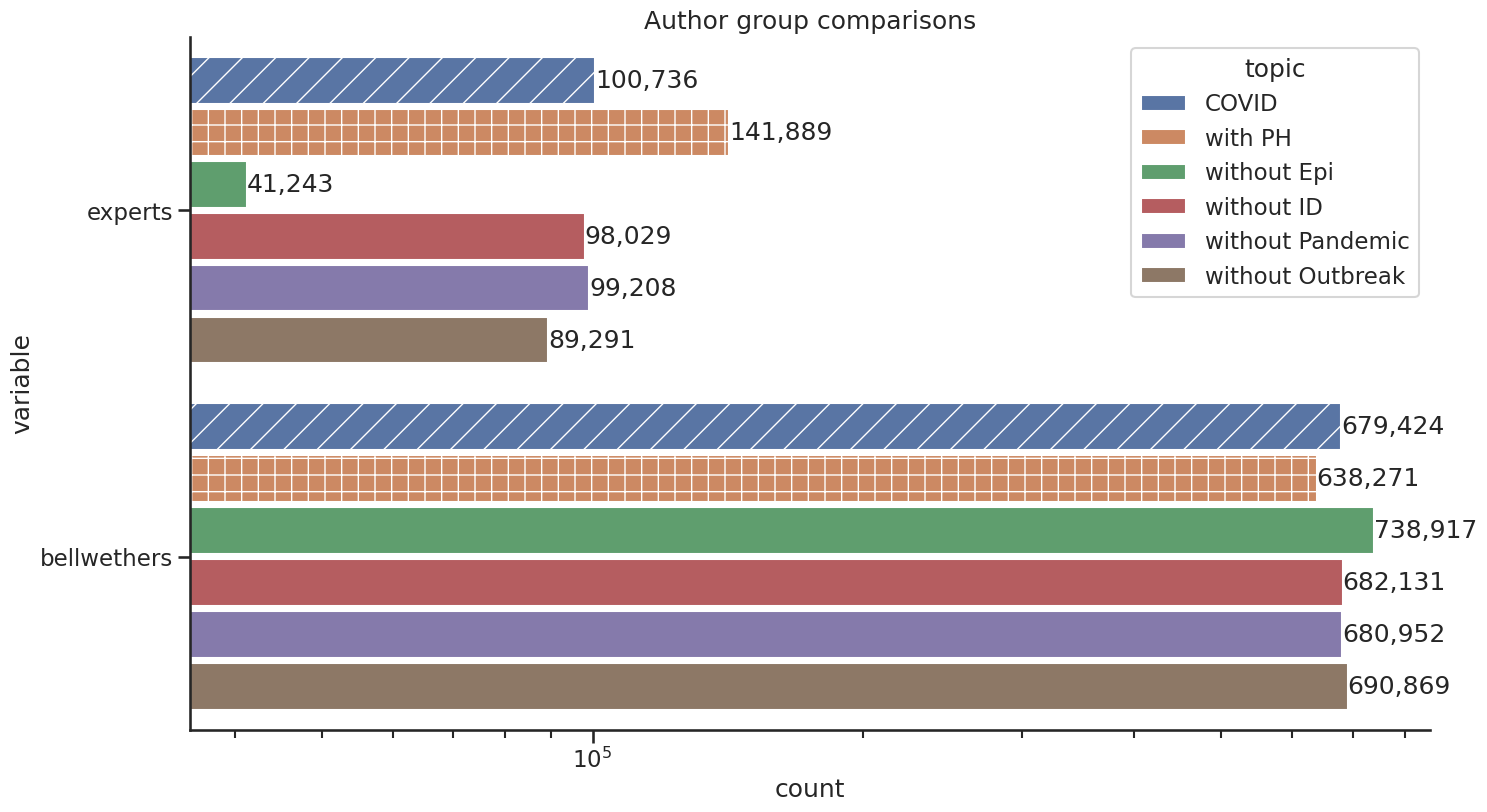

In [74]:
fig, ax = plt.subplots(figsize=(16, 9))
keep = {'experts', 'bellwethers'}
df = (
    counts_long
    .query('variable.isin(@keep)')
)
order = ['COVID', 'with PH', 'without Epi', 'without ID', 'without Pandemic', 'without Outbreak']

ax.set_xscale('log');
bars = sns.barplot(
    data=df, y='variable', x='count', hue='topic', ax=ax,
    orient='h',
    hue_order=order, width=0.9, gap=0.1, fill=True,
)

hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'][: 5])

ax.patches[0].set_hatch('/')
ax.patches[1].set_hatch('/')
ax.patches[2].set_hatch('+')
ax.patches[3].set_hatch('+')
# ax.patches[5].set_hatch('+')
# ax.patches[6].set_hatch('+')
# ax.patches[7].set_hatch('+')

ax.set_title(f'Author group comparisons');
for cont in ax.containers:
    ax.bar_label(cont, fmt='{:,.0f}', label_type='edge')
# for i, bar in enumerate(ax.patches):
#     # if i % df.topic.nunique() == 0:
#     hatch = next(hatches)
#     bar.set_hatch(hatch)
ax.spines[['right', 'top']].set_visible(False)



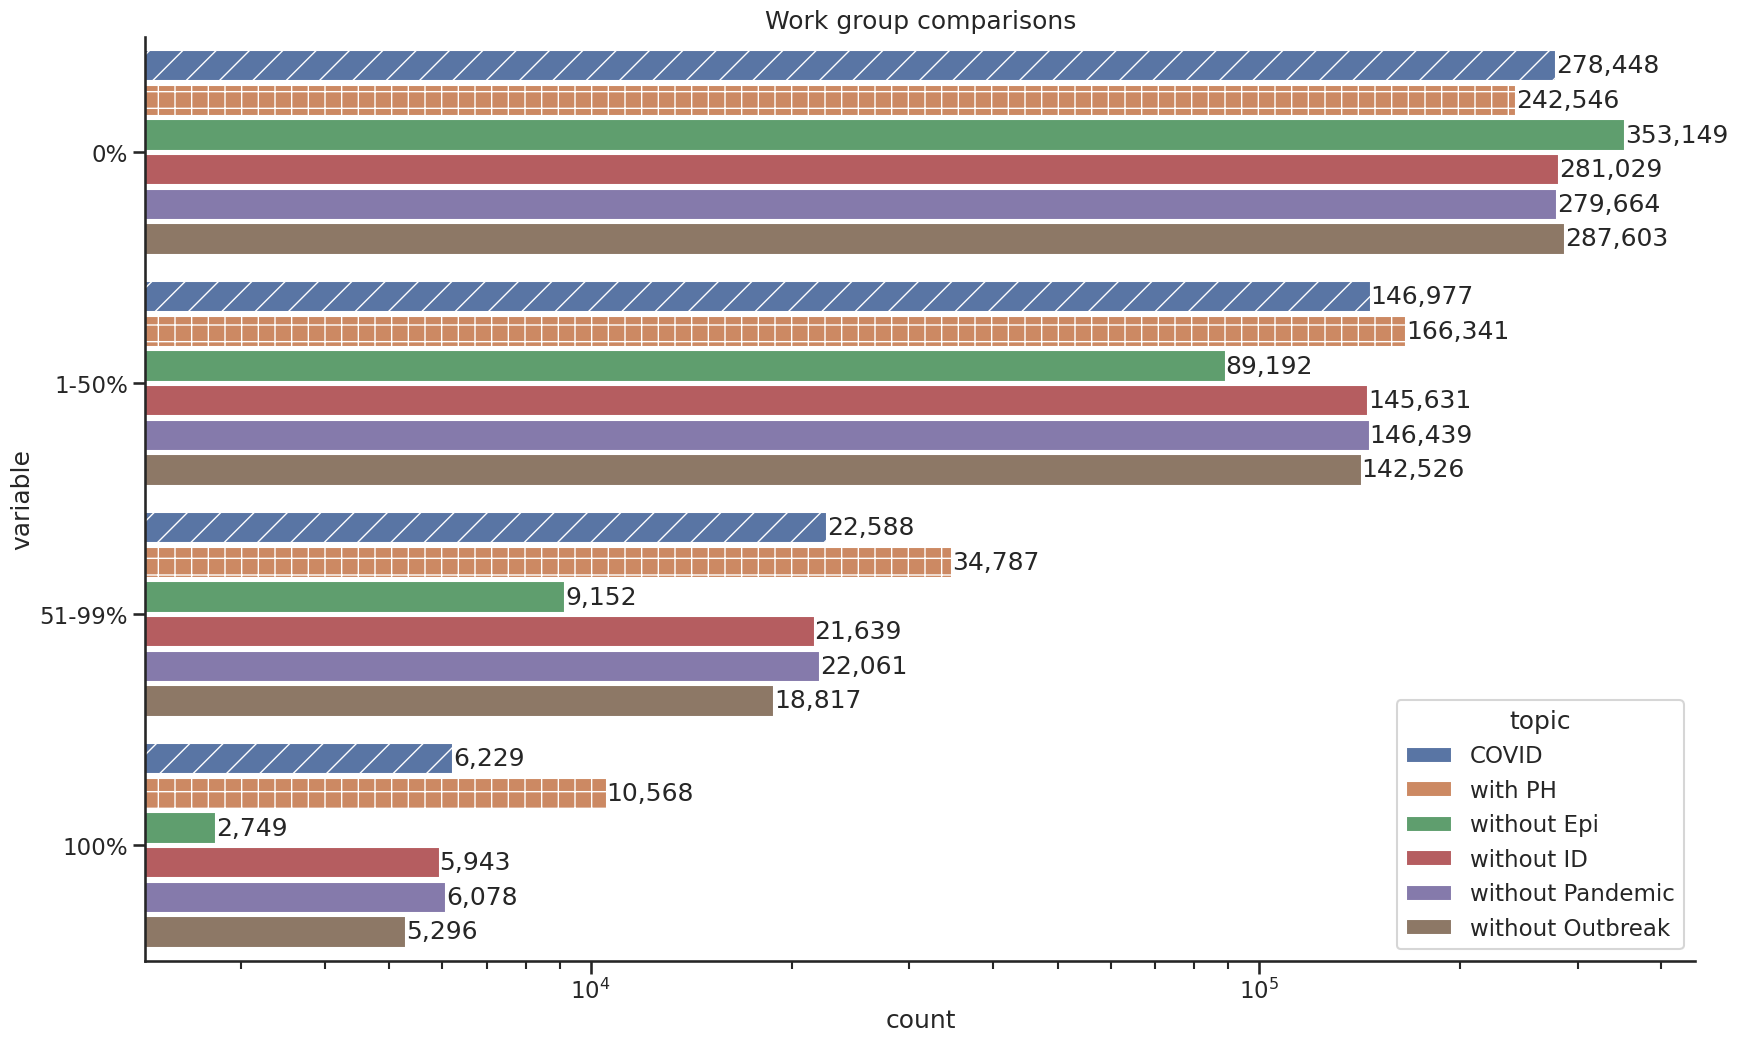

In [75]:
fig, ax = plt.subplots(figsize=(20, 12))
keep = {'0%', '1-50%', '51-99%', '100%'}
df = (
    counts_long
    .query('variable.isin(@keep)')
)
order = ['COVID', 'with PH', 'without Epi', 'without ID', 'without Pandemic', 'without Outbreak']

ax.set_xscale('log');
bars = sns.barplot(
    data=df, y='variable', x='count', hue='topic', ax=ax,
    orient='h',
    hue_order=order, width=0.9, gap=0.1, fill=True,
)

hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'][: 5])

ax.patches[0].set_hatch('/')
ax.patches[1].set_hatch('/')
ax.patches[2].set_hatch('/')
ax.patches[3].set_hatch('/')
ax.patches[4].set_hatch('+')
ax.patches[5].set_hatch('+')
ax.patches[6].set_hatch('+')
ax.patches[7].set_hatch('+')

ax.set_title(f'Work group comparisons');
for cont in ax.containers:
    ax.bar_label(cont, fmt='{:,.0f}', label_type='edge')
# for i, bar in enumerate(ax.patches):
#     # if i % df.topic.nunique() == 0:
#     hatch = next(hatches)
#     bar.set_hatch(hatch)

ax.spines[['right', 'top']].set_visible(False)


In [38]:
counts_df = pd.read_csv('./csvs/covid-ablation.csv', sep='\t')
counts_df

topic   works  authors  experts  bellwethers  newcomers      0%  \
0        withoutID  454242  1306230    98029       682131     526070  281029   
1  withoutPandemic  454242  1306230    99208       680952     526070  279664   
2       withoutEpi  454242  1306230    41243       738917     526070  353149   
3  withoutOutbreak  454242  1306230    89291       690869     526070  287603   
4         litCOVID  275998   929144    97833       557634     273677  124073   
5            COVID  454242  1306230   100736       679424     526070  278448   
6           withPH  454242  1306230   141889       638271     526070  242546   

    1-50%  51-99%   100%  
0  145631   21639   5943  
1  146439   22061   6078  
2   89192    9152   2749  
3  142526   18817   5296  
4  127318   19719   4888  
5  146977   22588   6229  
6  166341   34787  10568

In [39]:
(
    counts_df
    .query('topic=="COVID"')
)

topic   works  authors  experts  bellwethers  newcomers      0%   1-50%  \
5  COVID  454242  1306230   100736       679424     526070  278448  146977   

   51-99%  100%  
5   22588  6229

In [40]:
## plot as a ratio of COVID numbers
(
    counts_df
    .set_index('topic')
    .div(
        counts_df
        .query('topic=="COVID"')
        .iloc[0, 1:]
    )
)

works   authors   experts bellwethers newcomers        0%  \
topic                                                                           
withoutID             1.0       1.0  0.973128    1.003984       1.0  1.009269   
withoutPandemic       1.0       1.0  0.984832    1.002249       1.0  1.004367   
withoutEpi            1.0       1.0  0.409417    1.087564       1.0  1.268276   
withoutOutbreak       1.0       1.0  0.886386    1.016845       1.0  1.032879   
litCOVID         0.607601  0.711317  0.971182    0.820745  0.520229  0.445588   
COVID                 1.0       1.0       1.0         1.0       1.0       1.0   
withPH                1.0       1.0  1.408523     0.93943       1.0  0.871064   

                    1-50%    51-99%      100%  
topic                                          
withoutID        0.990842  0.957987  0.954086  
withoutPandemic   0.99634  0.976669  0.975759  
withoutEpi       0.606843  0.405171  0.441323  
withoutOutbreak  0.969716  0.833053  0.850217  
litCOVID         0.866244  0.872986  0.784717  
COVID                 1.0       1.0       1.0  
withPH           1.131749  1.540066  1.696581

In [41]:
print(
    counts_df
    .set_index('topic')
    .div(
        counts_df
        .query('topic=="COVID"')
        .iloc[0, 1:]
    )
    .convert_dtypes()
    .to_csv(sep=' ', float_format='%.4f')
    .replace('%', 'p')
)

topic works authors experts bellwethers newcomers 0p 1-50p 51-99p 100p
withoutID 1.0000 1.0000 0.9731 1.0040 1.0000 1.0093 0.9908 0.9580 0.9541
withoutPandemic 1.0000 1.0000 0.9848 1.0022 1.0000 1.0044 0.9963 0.9767 0.9758
withoutEpi 1.0000 1.0000 0.4094 1.0876 1.0000 1.2683 0.6068 0.4052 0.4413
withoutOutbreak 1.0000 1.0000 0.8864 1.0168 1.0000 1.0329 0.9697 0.8331 0.8502
litCOVID 0.6076 0.7113 0.9712 0.8207 0.5202 0.4456 0.8662 0.8730 0.7847
COVID 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
withPH 1.0000 1.0000 1.4085 0.9394 1.0000 0.8711 1.1317 1.5401 1.6966



In [53]:
print(
    pd.melt(
        counts_df
        .set_index('topic')
        .div(
            counts_df
            .query('topic=="COVID"')
            .iloc[0, 1:]
        )
        .reset_index()
        .query('topic=="litCOVID"'),
        id_vars=['topic'],
        value_name='count',
    )
    .convert_dtypes()
    .to_csv(sep=' ', index=False, float_format='%.4f')
    .replace('%', 'p')
)

topic variable count
litCOVID works 0.6076
litCOVID authors 0.7113
litCOVID experts 0.9712
litCOVID bellwethers 0.8207
litCOVID newcomers 0.5202
litCOVID 0p 0.4456
litCOVID 1-50p 0.8662
litCOVID 51-99p 0.8730
litCOVID 100p 0.7847



All of COVID
len(experts)=335,822
Existing authors: 18,486 at start of OW

In [90]:
from itertools import product
import upsetplot 

In [128]:
def get_experts_count(expert_concepts, works_concepts_tw, works_authors_tw, topic_authors_tw, topic_authors_ow):
    """
    Return the count of experts based on a set of concepts who are ALSO active in the OW
    """
    print([dict_concept_id_name[c] for c in expert_concepts])
    existing_topic_authors_tw = topic_authors_tw
    expert_author_ids_tw = set(
        works_authors_tw
        [
            works_authors_tw
            .work_id
            .isin(
                set(
                    works_concepts_tw
                    .query('concept_id.isin(@expert_concepts)')
                    .work_id
                )
            )
        ]
        .author_id
    )
    # print(f'{len(expert_author_ids_tw)=:,}')
    topic_expert_authors = (expert_author_ids_tw | existing_topic_authors_tw) & topic_authors_ow
    return len(topic_expert_authors)

In [88]:
key_concepts, expert_concepts, start_date_tw, end_date_tw, start_date_ow, end_date_ow = get_topic_info(topic='COVID')

'COVID' Core topics
	3007834351, Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (level 5)
	3008058167, Coronavirus disease 2019 (COVID-19) (level 4)
	3006700255, 2019-20 coronavirus outbreak (level 3)

'COVID' Prior experience topics:
	524204448, Infectious disease (medical specialty) (level 3)
	89623803, Pandemic (level 5)
	107130276, Epidemiology (level 2)
	116675565, Outbreak (level 2)
Training window: 2015-01-01 to 2019-12-31
Observation window: 2020-01-01 to 2022-12-31


In [89]:
works_tw, works_authors_tw, works_concepts_tw = filter_dataframes_timerange(works, works_authors, 
                                                                            works_concepts, start_date_tw, end_date_tw)

In [117]:
data = load_pickle(f'./pickles/COVID_agg.pkl')
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [102]:
expert_concepts_ser = pd.Series(list(expert_concepts))
expert_concepts_ser

0    524204448
1     89623803
2    107130276
3    116675565
dtype: int64

In [104]:
set(expert_concepts_ser.loc[[True, True, True, False]].values)

{89623803, 107130276, 524204448}

In [115]:
topic_authors_tw = set(
    works_authors_tw
    [
        works_authors_tw
        .work_id
        .isin(
            set(
                works_concepts_tw
                .query('concept_id.isin(@key_concepts)')
                .work_id
            )
        )
    ]
    .author_id
)
print(f'{len(topic_authors_tw)=:,}')

len(topic_authors_tw)=18,486


In [118]:
topic_authors_ow = data['author_ids_ow']
print(f'{len(topic_authors_ow)=:,}')

len(topic_authors_ow)=1,306,230


In [132]:
truth_table = list((product((True, False), repeat=4)))[::-1]  # truth table for 4 topics
counts = []
for i, truth_row in tqdm(enumerate(truth_table), total=16):
    truth_row = list(truth_row)        
    filt_concepts = set(expert_concepts_ser.loc[truth_row].values)

    if len(filt_concepts) == 0:
        count = 0
    else: 
        count = get_experts_count(
            expert_concepts=filt_concepts, 
            works_concepts_tw=works_concepts_tw, works_authors_tw=works_authors_tw,
            topic_authors_tw=topic_authors_tw, topic_authors_ow=topic_authors_ow,
        )
        print(f'{count=:,}')
        # break
    counts.append(count)
    

  0%|          | 0/16 [00:00<?, ?it/s]

['Outbreak']
count=34,727
['Epidemiology']
count=82,850
['Epidemiology', 'Outbreak']
count=96,381
['Pandemic']
count=13,869
['Pandemic', 'Outbreak']
count=37,222
['Pandemic', 'Epidemiology']
count=85,430
['Pandemic', 'Epidemiology', 'Outbreak']
count=98,029
['Infectious disease (medical specialty)']
count=16,797
['Infectious disease (medical specialty)', 'Outbreak']
count=38,955
['Infectious disease (medical specialty)', 'Epidemiology']
count=87,069
['Infectious disease (medical specialty)', 'Epidemiology', 'Outbreak']
count=99,208
['Infectious disease (medical specialty)', 'Pandemic']
count=20,557
['Infectious disease (medical specialty)', 'Pandemic', 'Outbreak']
count=41,243
['Infectious disease (medical specialty)', 'Pandemic', 'Epidemiology']
count=89,291
['Infectious disease (medical specialty)', 'Pandemic', 'Epidemiology', 'Outbreak']
count=100,736


In [133]:
truth_table

[(False, False, False, False),
 (False, False, False, True),
 (False, False, True, False),
 (False, False, True, True),
 (False, True, False, False),
 (False, True, False, True),
 (False, True, True, False),
 (False, True, True, True),
 (True, False, False, False),
 (True, False, False, True),
 (True, False, True, False),
 (True, False, True, True),
 (True, True, False, False),
 (True, True, False, True),
 (True, True, True, False),
 (True, True, True, True)]

In [134]:
counts

[0,
 34727,
 82850,
 96381,
 13869,
 37222,
 85430,
 98029,
 16797,
 38955,
 87069,
 99208,
 20557,
 41243,
 89291,
 100736]

In [172]:
concept_names_list = [dict_concept_id_name[c] for c in expert_concepts_ser]
concept_names_list[0] = 'ID'
concept_names_list[-2] = 'Epi'

In [175]:
counts_df = (
    pd.DataFrame(truth_table, columns=concept_names_list)
    .assign(
        index=range(len(truth_table)),
        counts=counts,
    )
    .set_index(concept_names_list)
)
counts_df

index  counts
ID    Pandemic Epi   Outbreak               
False False    False False         0       0
                     True          1   34727
               True  False         2   82850
                     True          3   96381
      True     False False         4   13869
                     True          5   37222
               True  False         6   85430
                     True          7   98029
True  False    False False         8   16797
                     True          9   38955
               True  False        10   87069
                     True         11   99208
      True     False False        12   20557
                     True         13   41243
               True  False        14   89291
                     True         15  100736

In [255]:
counts_df.to_csv('./csvs/COVID_experts_breakdown.csv')

In [257]:
d = pd.read_csv('./csvs/COVID_experts_breakdown.csv')
d

ID  Pandemic    Epi  Outbreak  index  counts
0   False     False  False     False      0       0
1   False     False  False      True      1   34727
2   False     False   True     False      2   82850
3   False     False   True      True      3   96381
4   False      True  False     False      4   13869
5   False      True  False      True      5   37222
6   False      True   True     False      6   85430
7   False      True   True      True      7   98029
8    True     False  False     False      8   16797
9    True     False  False      True      9   38955
10   True     False   True     False     10   87069
11   True     False   True      True     11   99208
12   True      True  False     False     12   20557
13   True      True  False      True     13   41243
14   True      True   True     False     14   89291
15   True      True   True      True     15  100736

In [178]:
counts_df.dtypes

index     int64
counts    int64
dtype: object

/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['darkblue' 'darkblue' 'darkblue' 'darkblue' '#00008b2e' 'darkblue'
 'darkblue' 'darkblue' 'darkblue' '#00008b2e' 'darkblue' 'darkblue'
 'darkblue' 'darkblue' '#00008b2e' 'darkblue' 'darkblue' 'darkblue'
 'darkblue' '#00008b2e' '#00008b2e' '#00008b2e' 'darkblue' 'darkblue'
 '#00008b2e' 'darkblue' '#00008b2e' 'darkblue' 'darkblue' '#00008b2e'
 '#00008b2e' 'darkblue' '#00008b2e' 'darkblue' 'darkblue' '#00008b2e'
 'darkblue' '#00008b2e' 'darkblue' '#00008b2e' 'darkblue' 'darkblue'
 '#00008b2e' '#00008b2e' '#00008b2e' '#00008b2e' '#00008b2e' 'darkblue'
 '#00008b2e' '#00008b2e' 'darkblue' '#00008b2e' '#00008b2e' 'darkblue'
 '#00008b2e' '#00008b2e' 'darkblue' '#00008b2e' '#00008b2e' '#00008b2e']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  style

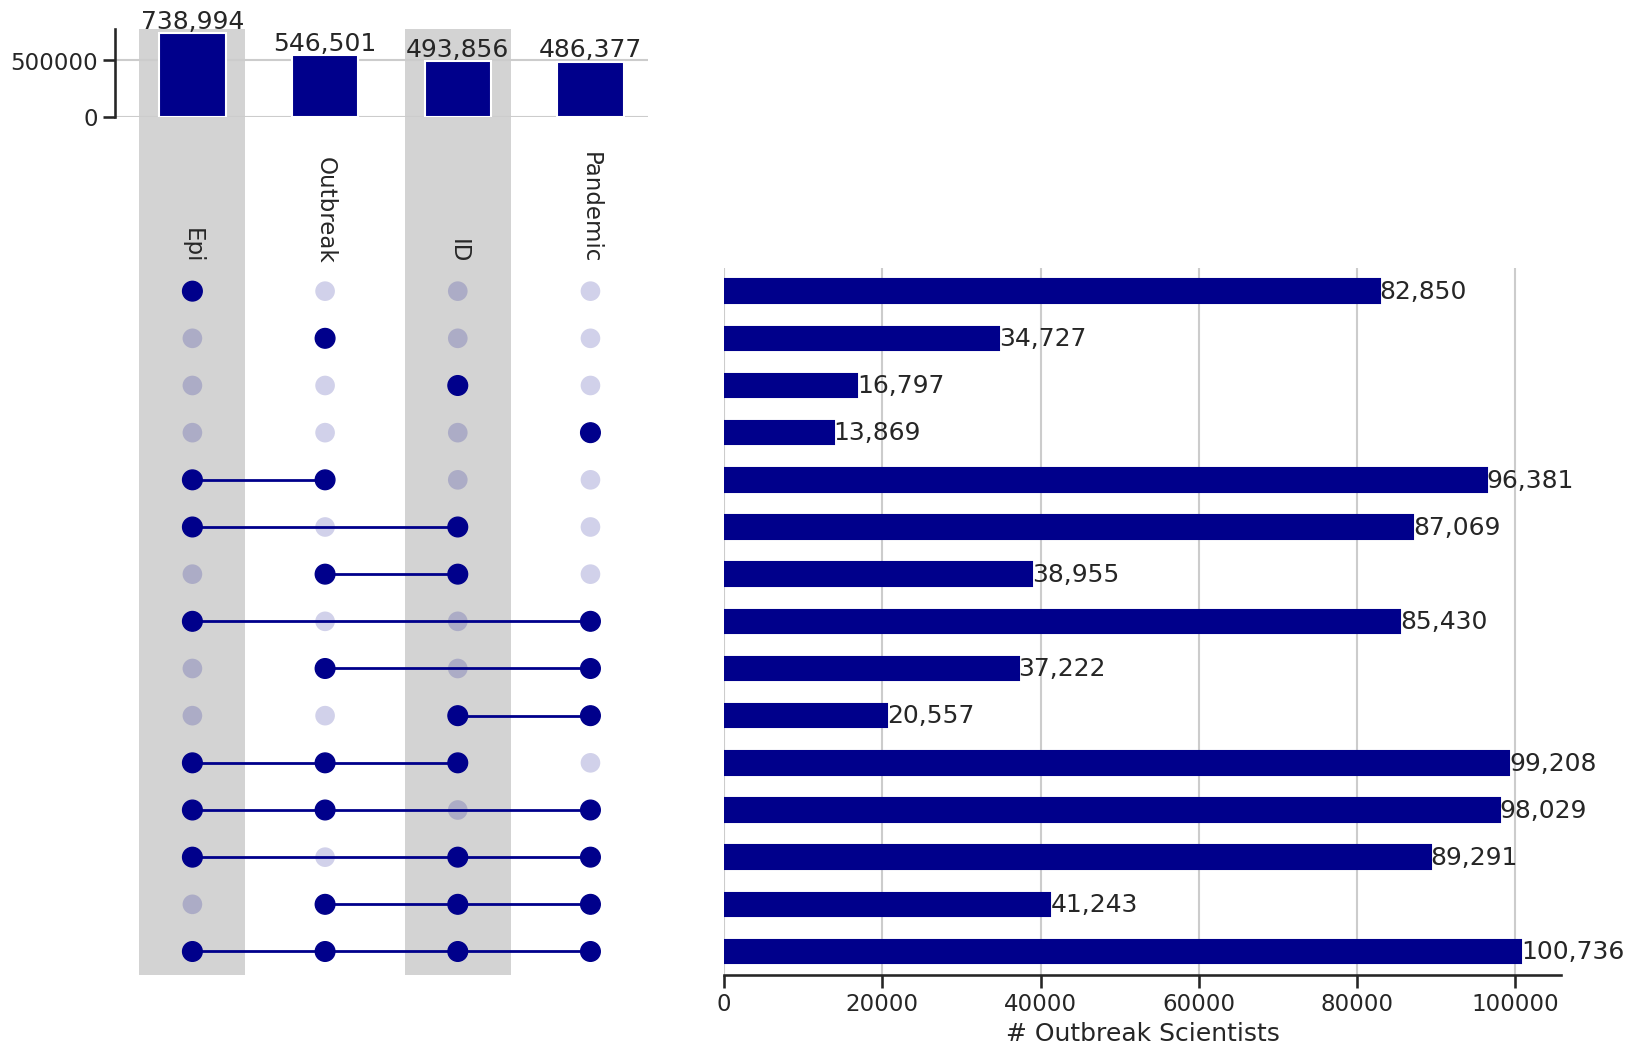

In [254]:
fig, ax = plt.subplots(figsize=(15, 10), layout='tight')
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.axis('off');
uplot = upsetplot.UpSet(
    counts_df.counts, show_counts='{:,d}',
    element_size=None, min_subset_size=1, 
    # fig=fig, 
    # totals_plot_elements=0,
    # sort_by='degree',
    orientation='vertical', with_lines=True,
    facecolor='darkblue', shading_color='lightgray',
    # show_percentages=True
)
plot = uplot.plot(fig)
plot['intersections'].set_xlabel('# Outbreak Scientists')
# plot['totals'].set_visible(False)
fig.tight_layout()

In [240]:
plot['totals'].axis('off')

<Axes: >

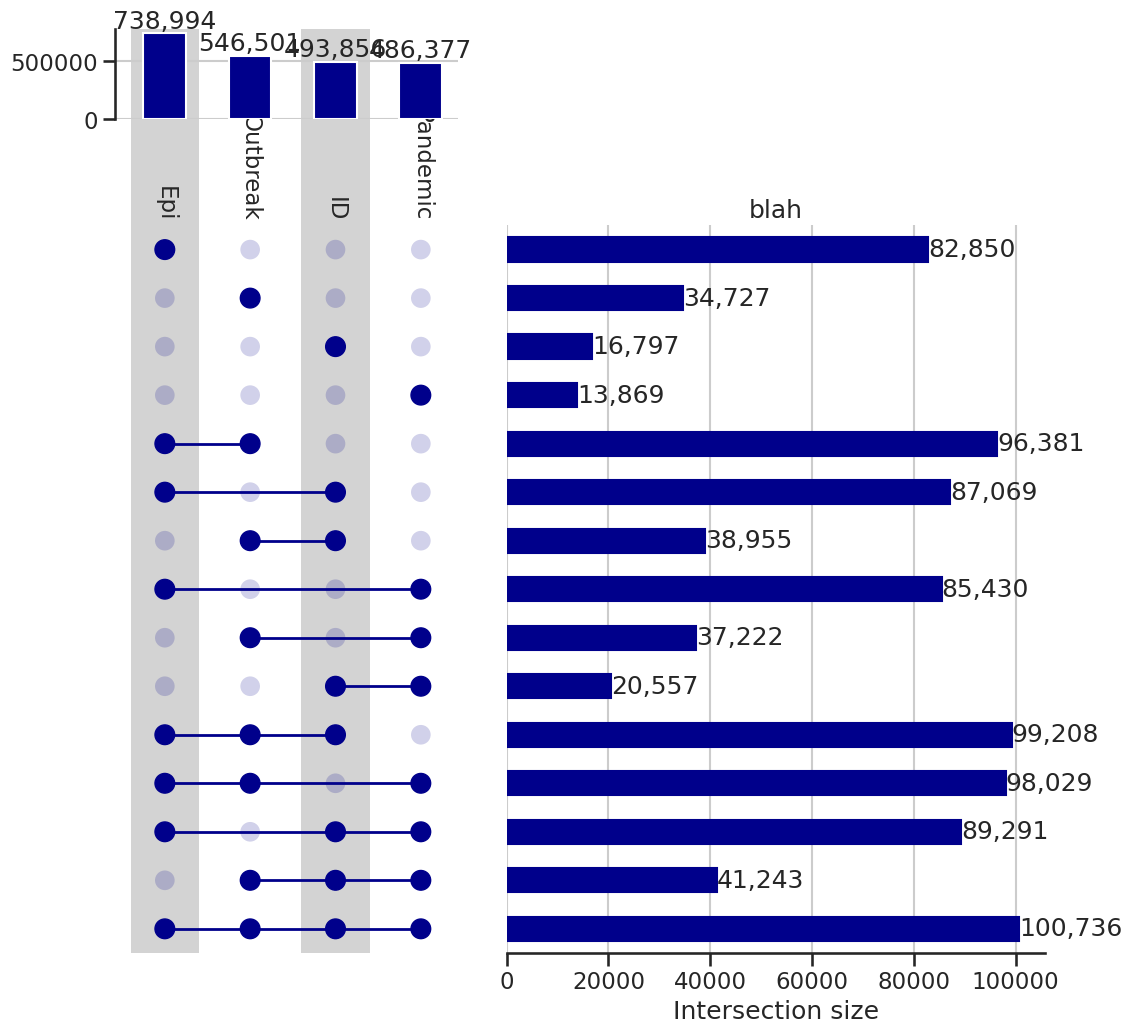

In [235]:
fig

/N/slate/ssikdar/envs/sci-sci/lib/python3.10/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['darkblue' 'darkblue' 'darkblue' 'darkblue' '#00008b2e' 'darkblue'
 'darkblue' 'darkblue' 'darkblue' '#00008b2e' 'darkblue' 'darkblue'
 'darkblue' 'darkblue' '#00008b2e' 'darkblue' 'darkblue' 'darkblue'
 'darkblue' '#00008b2e' '#00008b2e' '#00008b2e' 'darkblue' 'darkblue'
 '#00008b2e' 'darkblue' '#00008b2e' 'darkblue' 'darkblue' '#00008b2e'
 '#00008b2e' 'darkblue' '#00008b2e' 'darkblue' 'darkblue' '#00008b2e'
 'darkblue' '#00008b2e' 'darkblue' '#00008b2e' 'darkblue' 'darkblue'
 '#00008b2e' '#00008b2e' '#00008b2e' '#00008b2e' '#00008b2e' 'darkblue'
 '#00008b2e' '#00008b2e' 'darkblue' '#00008b2e' '#00008b2e' 'darkblue'
 '#00008b2e' '#00008b2e' 'darkblue' '#00008b2e' '#00008b2e' '#00008b2e']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  style

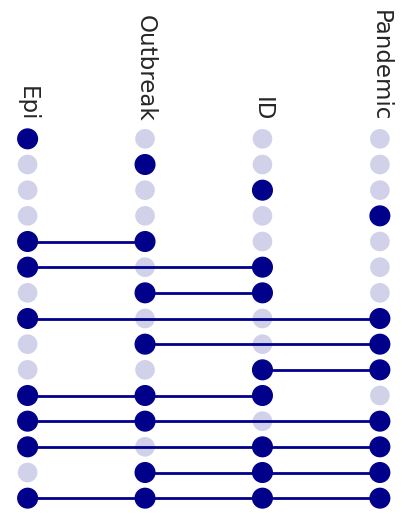

In [216]:
fig, ax = plt.subplots(figsize=(5, 5));
uplot.plot_matrix(ax);

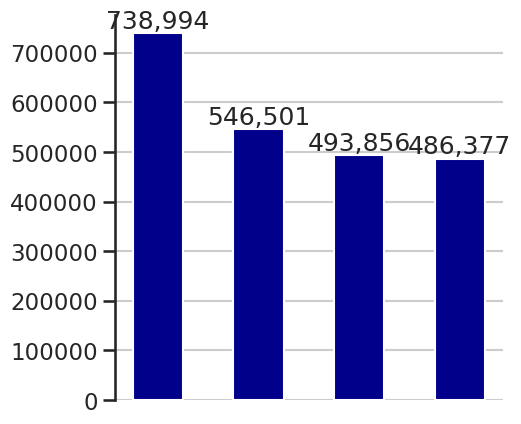

In [218]:
fig, ax = plt.subplots(figsize=(5, 5));
uplot.plot_totals(ax);

In [7]:
topic = 'COVID'

In [8]:
topic_subslice_path = Path('/N/project/openalex/slices/subslices/') / 'COVID'

topic_works_authors = (
    read_parquet(topic_subslice_path / 'works_authorships')
    .drop_duplicates(subset=['work_id', 'author_id'])
)
display(topic_works_authors)


Reading 'works_authorships' using engine='fastparquet'
Read 186,352,020 rows from 'works_authorships' in 15.43 sec.
Converting dtypes took 0.99 sec. Size before: 5.90GB, after: 5.90GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632322               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01

work_id   author_id  publication_year publication_date
__null_dask_index__                                                           
632321                979452944  5050381163              2015       2015-10-01
632323                979452944  5079869880              2015       2015-10-01
632324                979452944  5083970693              2015       2015-10-01
632325                979452944  5004714649              2015       2015-10-01
632326                979452944  5020141096              2015       2015-10-01
...                         ...         ...               ...              ...
2084769              1988262182  5086204990              2015       2015-01-07
2084770              1988262182  5082759743              2015       2015-01-07
2084771              1988262182  5014365256              2015       2015-01-07
2084774              1988262182  5008896938              2015       2015-01-07
2084776              1988262182  5085356021              2015       2015-01-07

[157732496 rows x 4 columns]

In [10]:
(topic_works_authors.work_id.nunique())

33221670

In [ ]:
2_540_055

In [9]:
shuffled_topic_works_authors_combined = load_pickle(f'./pickles/{topic}_shuffled.pkl')
shuffled_topic_works_authors_combined

[                        work_id   author_id  topic  trial
 __null_dask_index__                                      
 924882               3136058742  5087837852  COVID      1
 924884               3136058742  5023226233  COVID      1
 665748               3133988071  5066477109  COVID      1
 665751               3133988071  5082727603  COVID      1
 665753               3133988071  5004381131  COVID      1
 ...                         ...         ...    ...    ...
 104172               4220969349  5005055445  COVID      1
 104173               4220969349  5019134879  COVID      1
 104174               4220969349  5018863416  COVID      1
 104175               4220969349  5008424838  COVID      1
 104176               4220969349  5065607598  COVID      1
 
 [2540055 rows x 4 columns],
                         work_id   author_id  topic  trial
 __null_dask_index__                                      
 924882               3136058742  5024756660  COVID      2
 924884               313

In [8]:
len(shuffled_topic_works_authors_combined)

100

In [10]:
data = load_pickle(f'./pickles/{topic}_agg.pkl')

In [11]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [12]:
covid_work_ids_ow = data['work_ids_ow']
print(type(covid_work_ids_ow), f'{len(covid_work_ids_ow)=:,}')

<class 'set'> len(covid_work_ids_ow)=454,242


In [13]:
topic_works_authors = (  # keep only COVID works
    topic_works_authors
    [
        topic_works_authors.work_id.isin(covid_work_ids_ow)
    ]
)

display(topic_works_authors, topic_works_authors.work_id.nunique())

work_id   author_id  publication_year publication_date
__null_dask_index__                                                           
924882               3136058742  5047805950              2021       2021-04-01
924884               3136058742  5050824232              2021       2021-04-01
665748               3133988071  5084949171              2021       2021-03-10
665751               3133988071  5041462949              2021       2021-03-10
665753               3133988071  5027244469              2021       2021-03-10
...                         ...         ...               ...              ...
104172               4220969349  5091868146              2022       2022-03-06
104173               4220969349  5068633122              2022       2022-03-06
104174               4220969349  5037651515              2022       2022-03-06
104175               4220969349  5058259325              2022       2022-03-06
104176               4220969349  5007965601              2022       2022-03-06

[2540070 rows x 4 columns]

454242

In [14]:
(
    shuffled_topic_works_authors_combined[3]
    # .query('work_id.isin(@covid_work_ids_ow)')
)

work_id   author_id  topic  trial
__null_dask_index__                                      
924882               3136058742  5032747073  COVID      4
924884               3136058742  5060008113  COVID      4
665748               3133988071  5031000423  COVID      4
665751               3133988071  5041872728  COVID      4
665753               3133988071  5006437226  COVID      4
...                         ...         ...    ...    ...
104172               4220969349  5088759432  COVID      4
104173               4220969349  5046160679  COVID      4
104174               4220969349  5045710184  COVID      4
104175               4220969349  5079702506  COVID      4
104176               4220969349  5031819298  COVID      4

[2540053 rows x 4 columns]

### do the endpoint analysis now

In [15]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [16]:
## label each row based on author ids -> expert/bellwether/newcomers 
test = (
    topic_works_authors
    .sort_values(by='work_id')
    .head(1000)
)
test

work_id   author_id  publication_year publication_date
__null_dask_index__                                                           
486447                134354063  5021229877              2020       2020-04-13
486448                134354063  5041598740              2020       2020-04-13
51429                 134709296  5022245721              2022       2022-09-30
51430                 134709296  5017531032              2022       2022-09-30
51432                 134709296  5035920222              2022       2022-09-30
...                         ...         ...               ...              ...
401779               3001836891  5007635244              2020       2020-01-22
133                  3001897055  5088700209              2020       2020-02-20
132                  3001897055  5052821031              2020       2020-02-20
131                  3001897055  5078433604              2020       2020-02-20
130                  3001897055  5037421711              2020       2020-02-20

[1000 rows x 4 columns]

In [99]:
orig_mixing_df = get_collab_graph_mixing_df(topic_works_authors, data['experts'], data['bellwethers'], data['newcomers'])
display(orig_mixing_df)

'len(topic_works_authors)=2,540,070'

work_id   author_id  publication_year  \
__null_dask_index__                                             
924882               3136058742  5047805950              2021   
924884               3136058742  5050824232              2021   

                    publication_date author_type  
__null_dask_index__                               
924882                    2021-04-01        bell  
924884                    2021-04-01        bell

IGRAPH UN-- 1760472 2540070 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 7269022 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/7.27M [00:00<?, ?it/s]

exp     bell      new
exp   1486402  1994725   696291
bell  1994725  6558324  2254913
new    696291  2254913  2028948

In [101]:
pd.concat([
    orig_mixing_df
    .assign(trial=0),
    orig_mixing_df
    .assign(trial=1)
]
)

exp     bell      new  trial
exp   1486402  1994725   696291      0
bell  1994725  6558324  2254913      0
new    696291  2254913  2028948      0
exp   1486402  1994725   696291      1
bell  1994725  6558324  2254913      1
new    696291  2254913  2028948      1

In [105]:
for trial, topic_wa in tqdm(enumerate([topic_works_authors] + shuffled_topic_works_authors_combined), total=101):
    trial_mixing_d = get_collab_graph_mixing_df(topic_wa, data['experts'], data['bellwethers'], data['newcomers'])
    trial_mixing_d = (
        trial_mixing_d
        .assign(trial=trial)
    )
    header = (trial == 0)
    trial_mixing_d.to_csv('./csvs/COVID_mixing-matrices.csv', header=header, mode='a')
    

  0%|          | 0/101 [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,070'

work_id   author_id  publication_year  \
__null_dask_index__                                             
924882               3136058742  5047805950              2021   
924884               3136058742  5050824232              2021   

                    publication_date author_type  
__null_dask_index__                               
924882                    2021-04-01        bell  
924884                    2021-04-01        bell

IGRAPH UN-- 1760472 2540070 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 7269022 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/7.27M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5087837852  COVID      1         new
924884               3136058742  5023226233  COVID      1        bell

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982126 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,059'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5024756660  COVID      2        bell
924884               3136058742  5056838058  COVID      2        bell

IGRAPH UN-- 1760472 2540059 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982239 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,059'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5007797350  COVID      3        bell
924884               3136058742  5030008985  COVID      3        bell

IGRAPH UN-- 1760472 2540059 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982226 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5032747073  COVID      4        bell
924884               3136058742  5060008113  COVID      4        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982141 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5089823699  COVID      5        bell
924884               3136058742  5042276732  COVID      5        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982106 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,059'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5030163051  COVID      6         new
924884               3136058742  5068245284  COVID      6         new

IGRAPH UN-- 1760472 2540059 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982207 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5064629147  COVID      7         new
924884               3136058742  5065688329  COVID      7        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982186 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,050'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5051106643  COVID      8         new
924884               3136058742  5041937849  COVID      8        bell

IGRAPH UN-- 1760472 2540050 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982034 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,051'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5020700846  COVID      9        bell
924884               3136058742  5078952340  COVID      9         exp

IGRAPH UN-- 1760472 2540051 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982078 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5026002576  COVID     10         new
924884               3136058742  5001962052  COVID     10         exp

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982126 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5027454208  COVID     11        bell
924884               3136058742  5019187062  COVID     11         new

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982171 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5004489769  COVID     12        bell
924884               3136058742  5019585819  COVID     12         new

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982166 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,059'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5003196482  COVID     13        bell
924884               3136058742  5073388023  COVID     13         new

IGRAPH UN-- 1760472 2540059 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982255 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,058'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5000757227  COVID     14        bell
924884               3136058742  5040054239  COVID     14        bell

IGRAPH UN-- 1760472 2540058 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982195 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5029063096  COVID     15         exp
924884               3136058742  5026572045  COVID     15         new

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982155 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5024125885  COVID     16        bell
924884               3136058742  5070488454  COVID     16        bell

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982130 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,060'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5033964986  COVID     17        bell
924884               3136058742  5036945888  COVID     17         exp

IGRAPH UN-- 1760472 2540060 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982210 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,050'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5008790787  COVID     18        bell
924884               3136058742  5068680146  COVID     18        bell

IGRAPH UN-- 1760472 2540050 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982125 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5050220844  COVID     19         exp
924884               3136058742  5066823344  COVID     19        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982079 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,049'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5010932016  COVID     20         exp
924884               3136058742  5041390013  COVID     20         new

IGRAPH UN-- 1760472 2540049 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982068 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5038304553  COVID     21         new
924884               3136058742  5085281718  COVID     21        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982069 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5055813518  COVID     22        bell
924884               3136058742  5037541292  COVID     22        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982108 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,051'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5084821509  COVID     23         exp
924884               3136058742  5063531299  COVID     23        bell

IGRAPH UN-- 1760472 2540051 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982176 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5046538733  COVID     24        bell
924884               3136058742  5019166706  COVID     24        bell

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982120 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5021727162  COVID     25        bell
924884               3136058742  5034138597  COVID     25        bell

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982113 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5010351936  COVID     26         exp
924884               3136058742  5059897573  COVID     26         exp

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982222 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5063122928  COVID     27         new
924884               3136058742  5034818601  COVID     27         new

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982173 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5008175121  COVID     28         new
924884               3136058742  5039595381  COVID     28         new

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982171 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5000681388  COVID     29         exp
924884               3136058742  5078890522  COVID     29         new

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982183 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5070789354  COVID     30        bell
924884               3136058742  5023087358  COVID     30         new

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982172 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5026580400  COVID     31        bell
924884               3136058742  5036370106  COVID     31         new

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982157 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5056224549  COVID     32        bell
924884               3136058742  5038008968  COVID     32        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982114 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5023759632  COVID     33         new
924884               3136058742  5007813899  COVID     33        bell

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982194 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5014080946  COVID     34        bell
924884               3136058742  5032246802  COVID     34         exp

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982119 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5040002469  COVID     35         new
924884               3136058742  5081473075  COVID     35         exp

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982144 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,049'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5025579434  COVID     36         exp
924884               3136058742  5023814044  COVID     36        bell

IGRAPH UN-- 1760472 2540049 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982128 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5070438315  COVID     37         new
924884               3136058742  5039741190  COVID     37         new

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982148 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5008837988  COVID     38        bell
924884               3136058742  5061039771  COVID     38         new

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982211 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,061'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5066059294  COVID     39        bell
924884               3136058742  5078481104  COVID     39        bell

IGRAPH UN-- 1760472 2540061 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982265 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,046'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5070187428  COVID     40        bell
924884               3136058742  5021274391  COVID     40        bell

IGRAPH UN-- 1760472 2540046 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982012 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,051'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5069737711  COVID     41         new
924884               3136058742  5049361649  COVID     41        bell

IGRAPH UN-- 1760472 2540051 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982134 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5081680335  COVID     42         exp
924884               3136058742  5053044587  COVID     42        bell

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982189 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5085354071  COVID     43        bell
924884               3136058742  5055131588  COVID     43         new

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982166 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,051'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5075671509  COVID     44         new
924884               3136058742  5054764500  COVID     44         exp

IGRAPH UN-- 1760472 2540051 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982077 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5069377973  COVID     45         exp
924884               3136058742  5065818329  COVID     45        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982162 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5041042752  COVID     46        bell
924884               3136058742  5026574383  COVID     46         exp

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982142 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5054056943  COVID     47        bell
924884               3136058742  5087687721  COVID     47        bell

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982202 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,051'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5042143151  COVID     48        bell
924884               3136058742  5071891268  COVID     48        bell

IGRAPH UN-- 1760472 2540051 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982051 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5081947780  COVID     49        bell
924884               3136058742  5036646441  COVID     49        bell

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982234 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5020777719  COVID     50         new
924884               3136058742  5065554493  COVID     50         new

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982184 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5063461409  COVID     51         new
924884               3136058742  5075829386  COVID     51         new

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982159 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5000744072  COVID     52        bell
924884               3136058742  5078206139  COVID     52         new

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982213 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,058'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5084795955  COVID     53         new
924884               3136058742  5046457265  COVID     53        bell

IGRAPH UN-- 1760472 2540058 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982205 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5003188242  COVID     54         new
924884               3136058742  5078699353  COVID     54        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982182 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5082962759  COVID     55         new
924884               3136058742  5082849231  COVID     55        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982162 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5001696790  COVID     56        bell
924884               3136058742  5009336896  COVID     56        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982145 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,051'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5066368801  COVID     57         new
924884               3136058742  5038808879  COVID     57         exp

IGRAPH UN-- 1760472 2540051 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982076 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5061142267  COVID     58        bell
924884               3136058742  5027512145  COVID     58         exp

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982101 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5021988081  COVID     59        bell
924884               3136058742  5061993000  COVID     59        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982194 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,051'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5047790910  COVID     60        bell
924884               3136058742  5005735145  COVID     60        bell

IGRAPH UN-- 1760472 2540051 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982099 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5049421971  COVID     61        bell
924884               3136058742  5009824484  COVID     61         exp

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982130 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,058'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5034939368  COVID     62        bell
924884               3136058742  5007729360  COVID     62         new

IGRAPH UN-- 1760472 2540058 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982225 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5085047138  COVID     63         exp
924884               3136058742  5059266311  COVID     63         exp

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982162 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5048890076  COVID     64         exp
924884               3136058742  5068564266  COVID     64        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982146 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5051476567  COVID     65         exp
924884               3136058742  5091015678  COVID     65        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982144 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5004859281  COVID     66         new
924884               3136058742  5048948984  COVID     66        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982218 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,058'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5025794896  COVID     67        bell
924884               3136058742  5073282499  COVID     67        bell

IGRAPH UN-- 1760472 2540058 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982208 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5063148215  COVID     68         new
924884               3136058742  5025570228  COVID     68        bell

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982110 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5085898035  COVID     69        bell
924884               3136058742  5024006892  COVID     69        bell

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982172 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5012667410  COVID     70         exp
924884               3136058742  5024981931  COVID     70        bell

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982151 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5077404470  COVID     71        bell
924884               3136058742  5016813551  COVID     71        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982114 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5012407624  COVID     72        bell
924884               3136058742  5021869472  COVID     72        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982172 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,050'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5008360651  COVID     73        bell
924884               3136058742  5066775011  COVID     73         exp

IGRAPH UN-- 1760472 2540050 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982105 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5069684217  COVID     74         exp
924884               3136058742  5047471475  COVID     74        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982204 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,050'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5074970076  COVID     75        bell
924884               3136058742  5084119638  COVID     75        bell

IGRAPH UN-- 1760472 2540050 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982086 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5038572081  COVID     76         exp
924884               3136058742  5002906123  COVID     76         exp

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982194 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,058'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5079253784  COVID     77        bell
924884               3136058742  5057325930  COVID     77         new

IGRAPH UN-- 1760472 2540058 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982224 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5011585992  COVID     78         new
924884               3136058742  5036053426  COVID     78        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982213 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5076338962  COVID     79         new
924884               3136058742  5091624168  COVID     79         new

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982228 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5004526833  COVID     80         new
924884               3136058742  5074805559  COVID     80         new

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982142 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,058'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5082106258  COVID     81        bell
924884               3136058742  5034378152  COVID     81        bell

IGRAPH UN-- 1760472 2540058 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982234 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5083394235  COVID     82         new
924884               3136058742  5005784420  COVID     82         exp

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982172 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5034770123  COVID     83         new
924884               3136058742  5060017902  COVID     83        bell

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982205 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,054'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5085031431  COVID     84        bell
924884               3136058742  5013406927  COVID     84         new

IGRAPH UN-- 1760472 2540054 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982153 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5082401018  COVID     85         exp
924884               3136058742  5046408327  COVID     85        bell

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982159 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5090921922  COVID     86        bell
924884               3136058742  5083733388  COVID     86        bell

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982154 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5019586757  COVID     87        bell
924884               3136058742  5046166096  COVID     87        bell

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982159 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,048'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5008209608  COVID     88         new
924884               3136058742  5044251294  COVID     88         new

IGRAPH UN-- 1760472 2540048 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982091 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5011556355  COVID     89        bell
924884               3136058742  5037178585  COVID     89        bell

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982160 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,058'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5042583944  COVID     90        bell
924884               3136058742  5085440210  COVID     90         new

IGRAPH UN-- 1760472 2540058 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982216 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5009995323  COVID     91        bell
924884               3136058742  5070700398  COVID     91        bell

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982178 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,053'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5054439327  COVID     92        bell
924884               3136058742  5089619301  COVID     92         new

IGRAPH UN-- 1760472 2540053 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982229 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,048'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5004595193  COVID     93        bell
924884               3136058742  5047177981  COVID     93         new

IGRAPH UN-- 1760472 2540048 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982036 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,056'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5046001396  COVID     94        bell
924884               3136058742  5025147969  COVID     94        bell

IGRAPH UN-- 1760472 2540056 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982121 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5072521147  COVID     95        bell
924884               3136058742  5007816102  COVID     95        bell

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982176 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,059'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5030112090  COVID     96         new
924884               3136058742  5010133237  COVID     96        bell

IGRAPH UN-- 1760472 2540059 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982201 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5040576831  COVID     97        bell
924884               3136058742  5019711032  COVID     97        bell

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982131 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,052'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5071545049  COVID     98         new
924884               3136058742  5000424170  COVID     98        bell

IGRAPH UN-- 1760472 2540052 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982207 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,055'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5059719881  COVID     99         exp
924884               3136058742  5006762002  COVID     99         new

IGRAPH UN-- 1760472 2540055 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982209 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

'len(topic_works_authors)=2,540,057'

work_id   author_id  topic  trial author_type
__null_dask_index__                                                  
924882               3136058742  5071451902  COVID    100        bell
924884               3136058742  5089932070  COVID    100         exp

IGRAPH UN-- 1760472 2540057 -- 
+ attr: name (v)
IGRAPH UNWT 1306230 9982172 -- 
+ attr: name (v), type (v), weight (e)


Creating mixing mat:   0%|          | 0.00/9.98M [00:00<?, ?it/s]

### read the mixing matrices

In [7]:
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [8]:
mixing_matrices_df = pd.read_csv('./csvs/COVID_mixing-matrices.csv', index_col=0)
mixing_matrices_df

exp     bell      new  trial
exp   1486402  1994725   696291      0
bell  1994725  6558324  2254913      0
new    696291  2254913  2028948      0
exp    576620  1884756   932979      1
bell  1884756  6146418  3047675      1
...       ...      ...      ...    ...
bell  1883156  6145988  3047849     99
new    934297  3047849  1511328     99
exp    574544  1881844   933570    100
bell  1881844  6150414  3050269    100
new    933570  3050269  1508846    100

[303 rows x 4 columns]

In [73]:
orig_mm_df = (
    mixing_matrices_df
    .query('trial==0')
    .drop(columns=['trial'])
)
display(orig_mm_df)

shuffled_mm_df = (
    mixing_matrices_df
    .query('trial>0')
)
display(shuffled_mm_df)

exp     bell      new
exp   1486402  1994725   696291
bell  1994725  6558324  2254913
new    696291  2254913  2028948

exp     bell      new  trial
exp    576620  1884756   932979      1
bell  1884756  6146418  3047675      1
new    932979  3047675  1511214      1
exp    578388  1885672   934895      2
bell  1885672  6149544  3042673      2
...       ...      ...      ...    ...
bell  1883156  6145988  3047849     99
new    934297  3047849  1511328     99
exp    574544  1881844   933570    100
bell  1881844  6150414  3050269    100
new    933570  3050269  1508846    100

[300 rows x 4 columns]

In [12]:
import numpy as np

In [22]:
orig_mm_df

exp     bell      new
exp   1486402  1994725   696291
bell  1994725  6558324  2254913
new    696291  2254913  2028948

In [74]:
orig_mm_df = pd.DataFrame(np.triu(orig_mm_df.values), columns=orig_mm_df.columns, index=orig_mm_df.index)
np.fill_diagonal(orig_mm_df.values, np.diag(orig_mm_df)/2)
orig_mm_df

exp     bell      new
exp   743201  1994725   696291
bell       0  3279162  2254913
new        0        0  1014474

In [75]:
raw_split_dfs = (
    split_dataframe(shuffled_mm_df, chunk_size=3)[:-1]
)
split_dfs = []
for split_df in raw_split_dfs:
    split_df = pd.DataFrame(np.triu(split_df.values), columns=split_df.columns, index=split_df.index)
    np.fill_diagonal(split_df.values, np.diag(split_df)/2)
    split_dfs.append(split_df)
split_dfs[2]

exp     bell      new  trial
exp   288900  1885361   933660      3
bell       0  3078367  3044444      3
new        0        0   751917      3

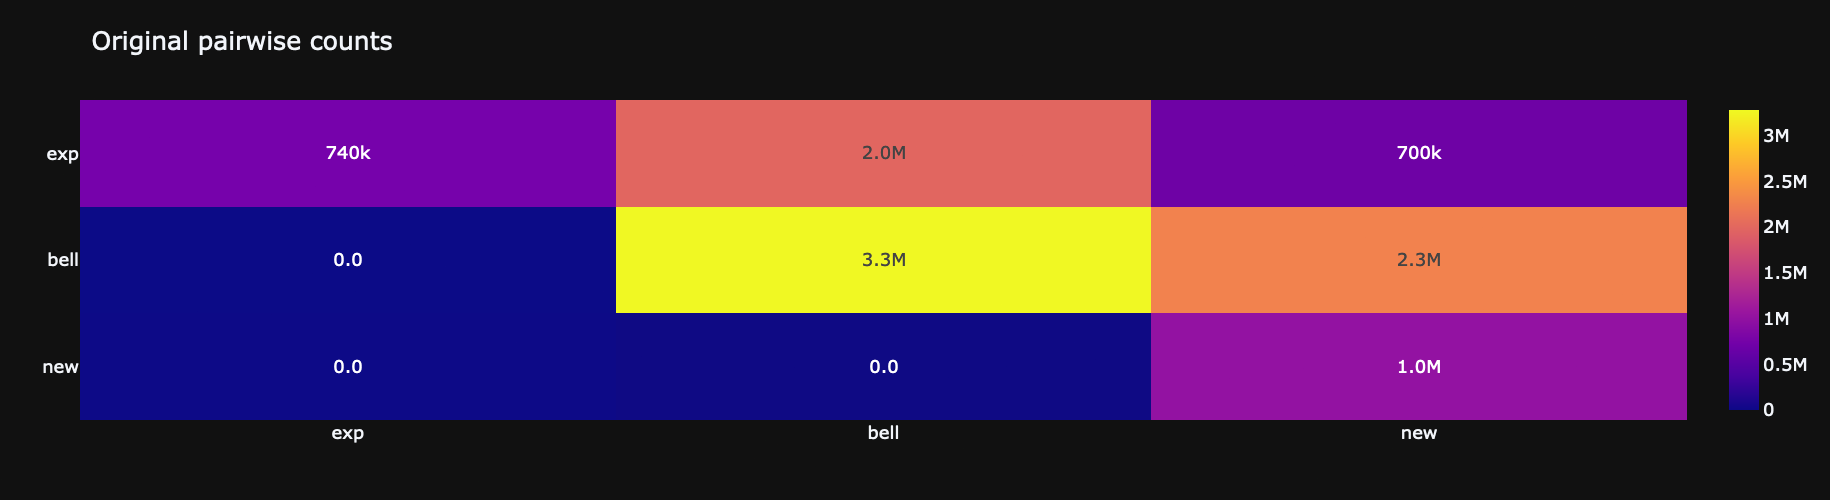

In [76]:
px.imshow(
    orig_mm_df, aspect='auto', text_auto='.2s', height=500, width=600,
    title='Original pairwise counts',
)

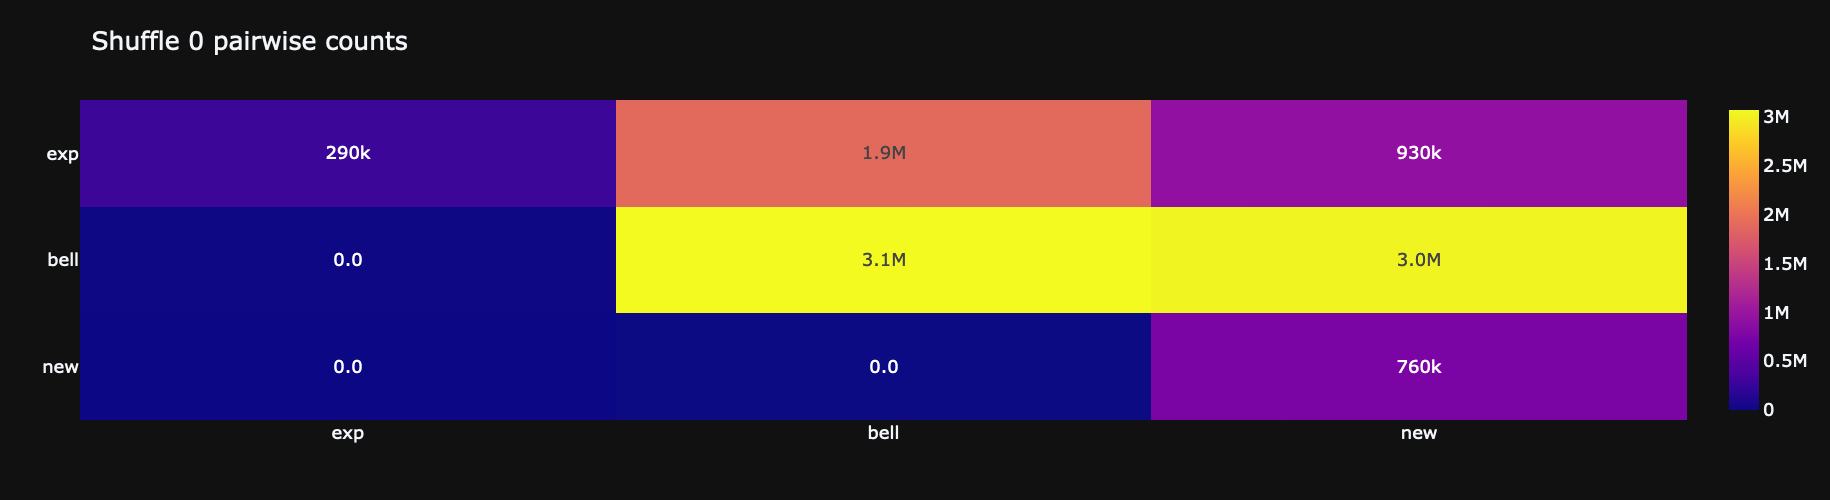

In [77]:
ix = 0
px.imshow(
    split_dfs[0].drop(columns=['trial']), 
    aspect='auto', text_auto='.2s', height=500, width=600,
    title=f'Shuffle {ix} pairwise counts',
)

In [78]:
## calculate mean of shuffled counts - normalize by sum of elements in the matrix
## maybe put the difference in counts/frac as a heatmap - diverging colorscale
## 3 column heatmap: Original, Mean of shuffled, Difference

In [79]:
shuffled_mats = np.stack([split_df.values[:,:-1] for split_df in split_dfs])
shuffled_mats

array([[[ 288310, 1884756,  932979],
        [      0, 3073209, 3047675],
        [      0,       0,  755607]],

       [[ 289194, 1885672,  934895],
        [      0, 3074772, 3042673],
        [      0,       0,  755438]],

       [[ 288900, 1885361,  933660],
        [      0, 3078367, 3044444],
        [      0,       0,  751917]],

       [[ 287932, 1884651,  933482],
        [      0, 3076263, 3045491],
        [      0,       0,  754745]],

       [[ 288622, 1881409,  932782],
        [      0, 3075063, 3049495],
        [      0,       0,  755166]],

       [[ 287980, 1883585,  933415],
        [      0, 3073977, 3047559],
        [      0,       0,  756095]],

       [[ 287343, 1881951,  930424],
        [      0, 3082084, 3046551],
        [      0,       0,  754262]],

       [[ 289344, 1885995,  932615],
        [      0, 3075807, 3045840],
        [      0,       0,  752856]],

       [[ 288361, 1884986,  932604],
        [      0, 3072683, 3046478],
        [      0,     

In [80]:
np.mean(shuffled_mats, axis=0).astype(int)

array([[ 288505, 1883851,  933132],
       [      0, 3075324, 3046973],
       [      0,       0,  754777]])

In [81]:
np.std(shuffled_mats, axis=0)

array([[ 816.4388851 , 2002.18181652, 1379.23055201],
       [   0.        , 3548.23802753, 2092.03804676],
       [   0.        ,    0.        , 1426.99833903]])

In [82]:
def plot_heatmap(mat, name, normalize=False, **args):
    if isinstance(mat, pd.DataFrame):
        np_mat = mat.values
    else:
        np_mat = mat 
    if normalize:
        mat = mat / np.sum(np_mat)
        text_auto = '.2%'
        zmin, zmax = 0, 0.5
    else:
        text_auto = '.2s'
        zmin, zmax = np.min(np_mat), np.max(np_mat)
    fig = px.imshow(
        mat, aspect='auto', text_auto=text_auto, 
        color_continuous_scale='viridis',
        # zmin=zmin, zmax=zmax,
        height=500, width=600,
        title=f'{name} pairwise counts',
    )
    return fig

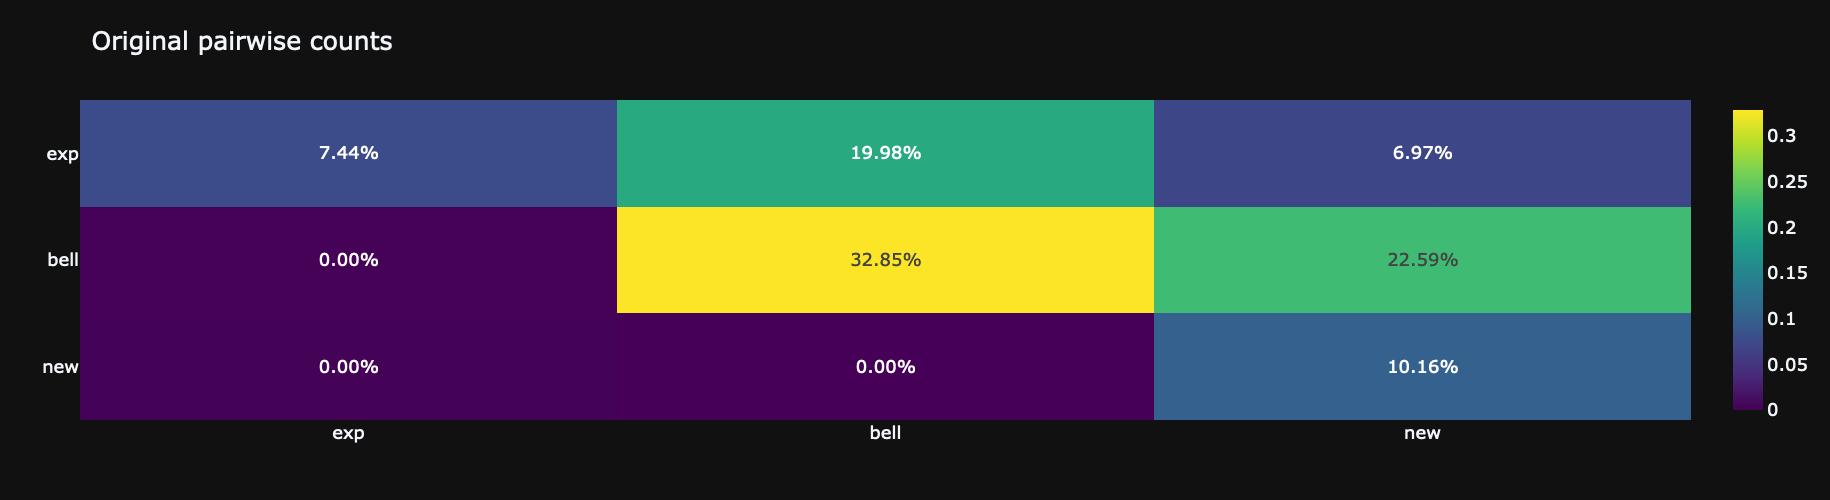

In [83]:
plot_heatmap(orig_mm_df, name='Original', normalize=True)

In [84]:
mean_mat = np.mean(shuffled_mats, axis=0)

shuffled_mean_df = pd.DataFrame(mean_mat, index=['exp', 'bell', 'new'], columns=['exp', 'bell', 'new'])
shuffled_mean_df

exp        bell         new
exp   288505.13  1883851.44   933132.38
bell       0.00  3075324.60  3046973.03
new        0.00        0.00   754777.02

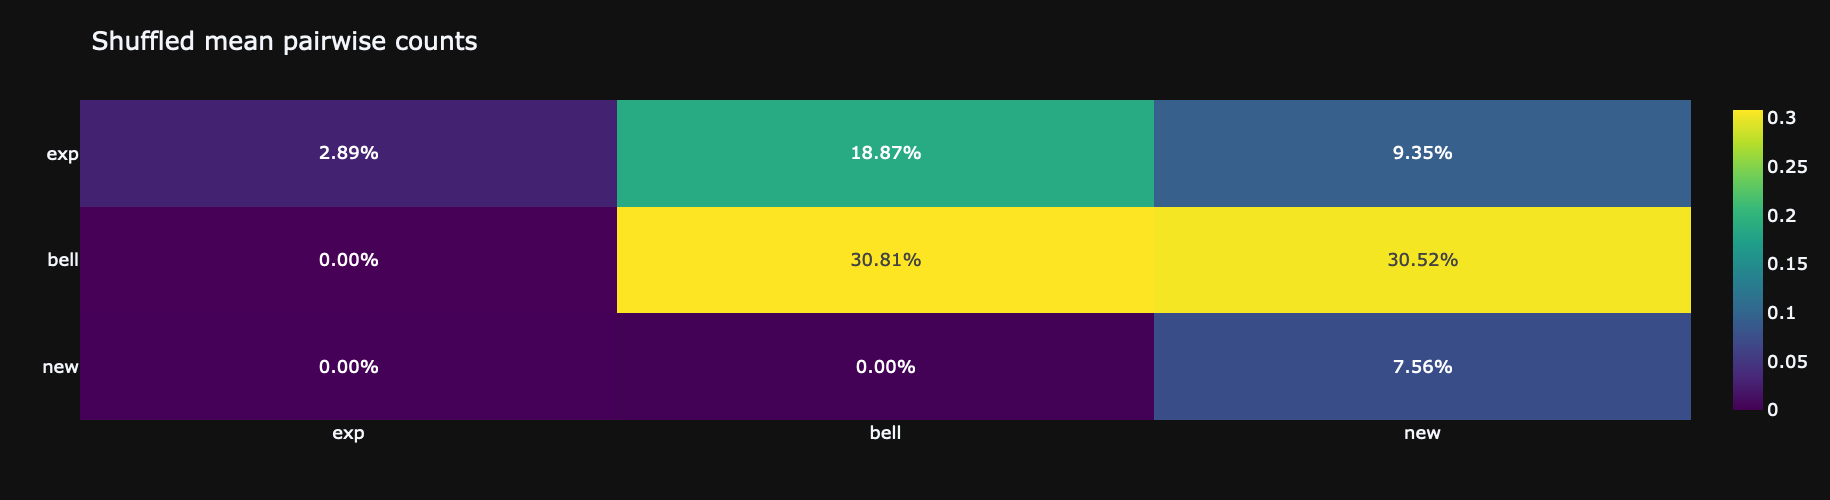

In [85]:
plot_heatmap(shuffled_mean_df, name='Shuffled mean', normalize=True)

In [86]:
np.sum(orig_mm_df.values)

9982766

In [87]:
diff_df = (orig_mm_df/np.sum(orig_mm_df.values)) - (shuffled_mean_df/np.sum(shuffled_mean_df.values))
diff_df

exp      bell       new
exp   0.045547  0.011103 -0.023727
bell  0.000000  0.020413 -0.079349
new   0.000000  0.000000  0.026013

In [88]:
orig_mm_df.reset_index()

index     exp     bell      new
0   exp  743201  1994725   696291
1  bell       0  3279162  2254913
2   new       0        0  1014474

In [89]:
## write to pgfplots
print(
    pd.melt(orig_mm_df.reset_index(), id_vars=['index'], value_name='count')
    .assign(kind='orig', sum=np.sum(orig_mm_df.values))
    .rename(columns={'index': 'x', 'variable': 'y'})
    .to_csv(sep=' ', index=False)
)

x y count kind sum
exp exp 743201 orig 9982766
bell exp 0 orig 9982766
new exp 0 orig 9982766
exp bell 1994725 orig 9982766
bell bell 3279162 orig 9982766
new bell 0 orig 9982766
exp new 696291 orig 9982766
bell new 2254913 orig 9982766
new new 1014474 orig 9982766



In [90]:
## write to pgfplots

print(
    pd.melt(shuffled_mean_df.reset_index(), id_vars=['index'], value_name='count')
    .assign(kind='shuffled', sum=np.sum(shuffled_mean_df.values))
    .rename(columns={'index': 'x', 'variable': 'y'})
    .to_csv(sep=' ', index=False)
)

x y count kind sum
exp exp 288505.13 shuffled 9982563.6
bell exp 0.0 shuffled 9982563.6
new exp 0.0 shuffled 9982563.6
exp bell 1883851.44 shuffled 9982563.6
bell bell 3075324.6 shuffled 9982563.6
new bell 0.0 shuffled 9982563.6
exp new 933132.38 shuffled 9982563.6
bell new 3046973.03 shuffled 9982563.6
new new 754777.02 shuffled 9982563.6



In [93]:
## write to pgfplots

print(
    pd.melt(diff_df.reset_index(), id_vars=['index'], value_name='count')
    .assign(kind='shuffled', sum=0)
    .rename(columns={'index': 'x', 'variable': 'y'})
    .to_csv(sep=' ', index=False, float_format='%.4f')
    .replace('exp', '0')
    .replace('bell', '1')
    .replace('new', '2')
)

x y count kind sum
0 0 0.0455 shuffled 0
1 0 0.0000 shuffled 0
2 0 0.0000 shuffled 0
0 1 0.0111 shuffled 0
1 1 0.0204 shuffled 0
2 1 0.0000 shuffled 0
0 2 -0.0237 shuffled 0
1 2 -0.0793 shuffled 0
2 2 0.0260 shuffled 0



In [90]:
np.mean(shuffled_mats, axis=0)/np.sum(shuffled_mats)

array([[ 577010.26, 1883851.44,  933132.38],
       [1883851.44, 6150649.2 , 3046973.03],
       [ 933132.38, 3046973.03, 1509554.04]])

In [133]:
pd.__version__

'2.1.1'

In [94]:
def get_yearly_counts(topic, kind, wids):
    yearly_counts = (
        works_authors
        .query('work_id.isin(@wids)')
        .assign(
            topic=topic,
            kind=kind,
            year=lambda df_: df_.publication_date.dt.year,
        )
        .groupby('year')
        .agg(
            topic=('topic', 'first'),
            kind=('kind', 'first'),
            works=('work_id', 'nunique'),
            authors=('author_id', 'nunique'),
        )
    )
    return yearly_counts

In [161]:
# topic = 'COVID_PH'
topic = 'QED'
topic_subslice_path = Path('/N/project/openalex/slices/subslices/') / topic

In [162]:
topic_ids, topic_ids_exp, start_date_tw, end_date_tw, start_date_ow, end_date_ow = get_topic_info(topic=topic)

'QED' Core topics
	3079626, Quantum electrodynamics (level 1)

'QED' Prior experience topics:
	62520636, Quantum mechanics (level 1)
Training window: 2012-01-01 to 2016-12-31
Observation window: 2017-01-01 to 2019-12-31


In [163]:
works_authors = read_parquet(topic_subslice_path / 'works_authorships')
works_concepts = read_parquet(topic_subslice_path / 'works_concepts')


Reading 'works_authorships' using engine='fastparquet'
Read 141,585,901 rows from 'works_authorships' in 9.19 sec.
Converting dtypes took 0.48 sec. Size before: 4.48GB, after: 4.48GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632322               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01


Reading 'works_concepts' using engine='fastparquet'
Read 229,278,957 rows from 'works_concepts' in 9.52 sec.
Converting dtypes took 1.49 sec. Size before: 6.41GB, after: 5.98GB


work_id  concept_id     score  publication_year
__null_dask_index__                                                   
463354               406922932   137620995  0.907227              2015
463355               406922932   161879069  0.680176              2015
463356               406922932    86554907  0.658203              2015

In [164]:
data = get_topic_works_and_authors(topic=topic, works_authors=works_authors, works_concepts=works_concepts)

In [165]:
data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow', 'work_ids_tw', 'author_ids_tw', 'expert_work_ids_tw', 'expert_author_ids_tw'])

In [166]:
{k: f'{len(v):,}' if isinstance(v, set) else v for k, v in data.items()}

{'topic': 'QED',
 'experts': '13,311',
 'bellwethers': '7,229',
 'newcomers': '3,976',
 'work_ids_ow': '12,718',
 'author_ids_ow': '24,516',
 'work_ids_tw': '20,739',
 'author_ids_tw': '31,838',
 'expert_work_ids_tw': '54,309',
 'expert_author_ids_tw': '62,623'}

In [167]:
## yearly counts of works and authors 
wids = data['work_ids_tw'] | data['work_ids_ow']
kind = 'topic'

yearly_counts = get_yearly_counts(topic=topic, kind='topic', wids=wids)
yearly_counts

topic   kind  works  authors
year                             
2012   QED  topic   4035     9539
2013   QED  topic   4143     9634
2014   QED  topic   4224    10074
2015   QED  topic   4013     9470
2016   QED  topic   4324    10602
2017   QED  topic   4285    10569
2018   QED  topic   4238    10845
2019   QED  topic   4195    10630

In [168]:
all_experts_wids = set(
    works_concepts
    [
        works_concepts.publication_year.between(start_date_tw.year, end_date_ow.year)
    ]
    .query('concept_id.isin(@topic_ids_exp)')
    .work_id
)
print(f'{len(all_experts_wids)=:,}')

len(all_experts_wids)=89,645


In [169]:
wids_dict = dict(
    topic=data['work_ids_tw'] | data['work_ids_ow'],
    all_experts=all_experts_wids,
)

dfs = []
for kind, wids in tqdm(wids_dict.items()):
    yearly_counts = get_yearly_counts(topic=topic, kind=kind, wids=wids)
    dfs.append(yearly_counts)

  0%|          | 0/2 [00:00<?, ?it/s]

In [170]:
yearly_counts_combined = (
    pd.concat(dfs, axis=1)
    .iloc[:, [0, 2, 3, 6, 7]]
)
yearly_counts_combined.columns = ['topic', 'topic_works', 'topic_authors', 'exp_works', 'exp_authors']
yearly_counts_combined

topic  topic_works  topic_authors  exp_works  exp_authors
year                                                          
2012   QED         4035           9539      10404        20768
2013   QED         4143           9634      10772        21861
2014   QED         4224          10074      10818        22580
2015   QED         4013           9470      11006        23510
2016   QED         4324          10602      11309        24833
2017   QED         4285          10569      11626        25730
2018   QED         4238          10845      11449        26281
2019   QED         4195          10630      12261        28093

In [171]:
print(
    yearly_counts_combined
    .to_csv(sep=' ')
)

year topic topic_works topic_authors exp_works exp_authors
2012 QED 4035 9539 10404 20768
2013 QED 4143 9634 10772 21861
2014 QED 4224 10074 10818 22580
2015 QED 4013 9470 11006 23510
2016 QED 4324 10602 11309 24833
2017 QED 4285 10569 11626 25730
2018 QED 4238 10845 11449 26281
2019 QED 4195 10630 12261 28093



In [ ]:
## litcovid crap

In [172]:
lit_data = load_pickle('./pickles/litCOVID_agg.pkl')
lit_data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [173]:
litcovid_works = read_parquet('./data/litcovid-openalex-merged_works_aug-2023.parquet')
litcovid_works 


Reading 'litcovid-openalex-merged_works_aug-2023' using engine='fastparquet'
Read 347,861 rows from 'litcovid-openalex-merged_works_aug-2023' in 0.44 sec.
Converting dtypes took 0.56 sec. Size before: 0.18GB, after: 0.18GB


title          type  \
work_id                                                                      
66687513   The Acute Respiratory Distress Syndrome: Diagn...  book-chapter   
219385191  Advances in the Immunobiology of Parasitic Dis...       article   
612496191  A year after lockdowns began, has research got...       article   

          publication_date                           doi  num_authors  \
work_id                                                                 
66687513        2019-04-02  10.1007/978-3-319-94189-9_11            2   
219385191       2022-07-20     10.3390/pathogens11070811            3   
612496191       2021-06-10    10.1038/d41586-021-01579-7            1   

             # pmid                                            title_e  \
work_id                                                                  
66687513   32538594  Acute Respiratory Distress Syndrome: Diagnosis...   
219385191  35890055  Advances in the Immunobiology of Parasitic Dis...   
612496191  34113030  A year after lockdowns began, has research got...   

                    journal  month  day  year  jan_1  
work_id                                               
66687513   Am Fam Physician      4    2  2019  False  
219385191         Pathogens      7   20  2022  False  
612496191            Nature      6   10  2021  False

title          type  \
work_id                                                                       
66687513    The Acute Respiratory Distress Syndrome: Diagn...  book-chapter   
219385191   Advances in the Immunobiology of Parasitic Dis...       article   
612496191   A year after lockdowns began, has research got...       article   
1494388951  Some Dissimilarity Measures of Branching Proce...       article   
1519225998  The 27th Annual Prostate Cancer Foundation Sci...       article   
...                                                       ...           ...   
4385264694  Preoperative universal screening of coronaviru...       article   
4385264699  The impact of restricted access on the need an...       article   
4385264717  Risk of ischemic stroke in patients recovered ...       article   
4385264721  Unravelling disparity in age-specific acceptan...       article   
4385264872  Cholinergic α7 nAChR signaling suppresses SARS...       article   

           publication_date                            doi  num_authors  \
work_id                                                                   
66687513         2019-04-02   10.1007/978-3-319-94189-9_11            2   
219385191        2022-07-20      10.3390/pathogens11070811            3   
612496191        2021-06-10     10.1038/d41586-021-01579-7            1   
1494388951       2020-08-08              10.3390/e22080874            2   
1519225998       2021-09-01             10.1002/pros.24211            2   
...                     ...                            ...          ...   
4385264694       2023-07-26      10.4103/sjopt.sjopt_94_22            2   
4385264699       2023-07-25        10.1922/cdh_00122keat07            2   
4385264717       2023-07-25      10.1177/23969873231190432            5   
4385264721       2023-07-25  10.1080/08870446.2023.2239279            7   
4385264872       2023-07-25           10.1093/jmcb/mjad048            5   

              # pmid                                            title_e  \
work_id                                                                   
66687513    32538594  Acute Respiratory Distress Syndrome: Diagnosis...   
219385191   35890055  Advances in the Immunobiology of Parasitic Dis...   
612496191   34113030  A year after lockdowns began, has research got...   
1494388951  33286645  Some Dissimilarity Measures of Branching Proce...   
1519225998  34469608  The 27th Annual Prostate Cancer Foundation Sci...   
...              ...                                                ...   
4385264694  37492210  Preoperative universal screening of coronaviru...   
4385264699  37490397  The impact of restricted access on the need an...   
4385264717  37491810  Risk of ischemic stroke in patients recovered ...   
4385264721  37491766  Unravelling disparity in age-specific acceptan...   
4385264872  37491690  Cholinergic alpha7 nAChR signaling suppresses ...   

                          journal  month  day  year  jan_1  
work_id                                                     
66687513         Am Fam Physician      4    2  2019  False  
219385191               Pathogens      7   20  2022  False  
612496191                  Nature      6   10  2021  False  
1494388951        Entropy (Basel)      8    8  2020  False  
1519225998               Prostate      9    1  2021  False  
...                           ...    ...  ...   ...    ...  
4385264694     Saudi J Ophthalmol      7   26  2023  False  
4385264699  Community Dent Health      7   25  2023  False  
4385264717           Eur Stroke J      7   25  2023  False  
4385264721         Psychol Health      7   25  2023  False  
4385264872        J Mol Cell Biol      7   25  2023  False  

[347861 rows x 12 columns]

In [186]:
lit_data.keys()

dict_keys(['topic', 'experts', 'bellwethers', 'newcomers', 'work_ids_ow', 'author_ids_ow'])

In [194]:
(
    litcovid_works
    [litcovid_works.index.isin(lit_data['work_ids_ow'])]
    .year
    .value_counts()
    .sort_index()
    .rename('works_count')
    .to_frame()
)

works_count
year             
2020        68808
2021       107751
2022        99439

In [191]:
works_authors = read_parquet('/N/project/openalex/slices/subslices/COVID/works_authorships')


Reading 'works_authorships' using engine='fastparquet'
Read 186,352,020 rows from 'works_authorships' in 11.82 sec.
Converting dtypes took 0.99 sec. Size before: 5.90GB, after: 5.90GB


work_id   author_id  publication_year publication_date
__null_dask_index__                                                          
632321               979452944  5050381163              2015       2015-10-01
632322               979452944  5050381163              2015       2015-10-01
632323               979452944  5079869880              2015       2015-10-01

In [192]:
(
    works_authors
    [works_authors.work_id.isin(lit_data['work_ids_ow'])]
    .groupby('publication_year')
    .agg(
        topic_works=('work_id', 'nunique'),
        topic_authors=('author_id', 'nunique'),
    )
    
)

topic_works  topic_authors
publication_year                            
2020                    68808         273372
2021                   107751         471909
2022                    99439         474431

In [196]:
(
    litcovid_works
    .reset_index()
    .query('year==2019')
    .title_e
    # [['work_id', 'year', 'title_e']]
    .values
)

<StringArray>
[                                                                                                                                               'Acute Respiratory Distress Syndrome: Diagnosis and Management.',
                                                                                                                                               'Australian Rotavirus Surveillance Program: Annual Report, 2020.',
                                                                                                                              'Creutzfeldt-Jakob disease surveillance in Australia: update to 31 December 2020.',
                                                                                                                           'Unexpected Receptor Functional Mimicry Elucidates Activation of Coronavirus Fusion.',
                                                              'Enterovirus D68-Associated Acute Respiratory Illness  horizontal line  New Vaccine 